In [1]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 28.1 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras import optimizers
import pathlib 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import shap

In [3]:
!pip install -q git+https://github.com/tensorflow/docs 

  Preparing metadata (setup.py) ... done


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [5]:
df = pd.read_csv('MVP_Candidates.csv')
df.fillna(0)

,Unnamed: 0.1,Unnamed: 0,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,...,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Rank,MVP Share,Year
0,0,0,Nikola Jokić,C,5,26,DEN,74,74,10,...,105,117,144,55,230.9,286.9,1,1,0.875,2021-22
1,1,1,Joel Embiid,C,5,27,PHI,68,68,8,...,105,109,243,47,6.5,169.0,0,2,0.706,2021-22
2,2,2,Giannis Antetokounmpo,PF,4,27,MIL,67,67,7,...,93,112,248,49,125.1,211.1,0,3,0.595,2021-22
3,3,3,Devin Booker,SG,2,25,PHO,68,68,1,...,112,102,103,84,-4.1,32.6,0,4,0.216,2021-22
4,4,4,Luka Dončić,PG,1,22,DAL,65,65,5,...,96,101,140,102,-8.9,15.3,0,5,0.146,2021-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,481,481,Bernard King,SF,3,34,WSB,64,64,20,...,103,99,100,30,-38.6,-26.0,0,16,0.007,1990-91
481,482,482,Kenny Smith,PG,1,25,HOU,78,78,8,...,110,112,106,164,115.5,148.1,0,17,0.005,1990-91
482,483,483,Hakeem Olajuwon,C,5,28,HOU,56,50,8,...,101,103,90,5,39.4,31.8,0,18,0.004,1990-91
483,484,484,Tim Hardaway,PG,1,24,GSW,82,82,11,...,105,102,77,198,63.4,44.2,0,19,0.001,1990-91


In [6]:
'''
1990-91 to 1998-99
1999-00 to 2011-12
2012-13 to 2021-22
'''
e1 = ('2021-22', '2020-21', '2019-20', '2018-19', '2017-18', '2016-17', '2015-16', '2014-15', '2013-14', '2012-13')
e2 = ('2011-12', '2010-09', '2008-09', '2007-08', '2006-07', '2005-06', '2004-05', '2003-04', '2002-03', '2001-02', '2000-01', '1999-00')
e3 = ('1998-99', '1997-98', '1996-97', '1995-96', '1994-95', '1993-94', '1992-93', '1991-92', '1990-91')


df1 = df[(df['Year'] == '2021-22') | (df['Year'] == '2020-21') | (df['Year'] == '2019-20') | (df['Year'] == '2018-19') | (df['Year'] == '2017-18') | (df['Year'] == '2016-17') | (df['Year'] == '2015-16') | (df['Year'] == '2014-15') | (df['Year'] == '2013-14') | (df['Year'] == '2012-13')]


In [7]:
df1

,Unnamed: 0.1,Unnamed: 0,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,...,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Rank,MVP Share,Year
0,0,0,Nikola Jokić,C,5,26,DEN,74,74,10,...,105,117,144,55,230.9,286.9,1,1,0.875,2021-22
1,1,1,Joel Embiid,C,5,27,PHI,68,68,8,...,105,109,243,47,6.5,169.0,0,2,0.706,2021-22
2,2,2,Giannis Antetokounmpo,PF,4,27,MIL,67,67,7,...,93,112,248,49,125.1,211.1,0,3,0.595,2021-22
3,3,3,Devin Booker,SG,2,25,PHO,68,68,1,...,112,102,103,84,-4.1,32.6,0,4,0.216,2021-22
4,4,4,Luka Dončić,PG,1,22,DAL,65,65,5,...,96,101,140,102,-8.9,15.3,0,5,0.146,2021-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,125,125,Kevin Garnett,C,5,36,BOS,68,68,16,...,104,100,87,8,2.1,0.6,0,12,0.001,2012-13
125,126,126,Marc Gasol,C,5,28,MEM,80,80,6,...,113,105,134,7,-3.8,49.2,0,12,0.001,2012-13
126,127,127,Ty Lawson,PG,1,25,DEN,73,71,4,...,100,103,118,98,16.9,31.5,0,12,0.001,2012-13
127,128,128,David Lee,PF,4,29,GSW,79,79,10,...,106,105,102,1,52.3,68.1,0,12,0.001,2012-13


In [8]:
df1.drop(df1.columns[[0, 1]], axis = 1, inplace=True)
df1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,Win %,1.MP,...,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Rank,MVP Share,Year
0,Nikola Jokić,C,5,26,DEN,74,74,10,0.585366,2476,...,105,117,144,55,230.9,286.9,1,1,0.875,2021-22
1,Joel Embiid,C,5,27,PHI,68,68,8,0.621951,2297,...,105,109,243,47,6.5,169.0,0,2,0.706,2021-22
2,Giannis Antetokounmpo,PF,4,27,MIL,67,67,7,0.621951,2204,...,93,112,248,49,125.1,211.1,0,3,0.595,2021-22
3,Devin Booker,SG,2,25,PHO,68,68,1,0.780488,2345,...,112,102,103,84,-4.1,32.6,0,4,0.216,2021-22
4,Luka Dončić,PG,1,22,DAL,65,65,5,0.634146,2301,...,96,101,140,102,-8.9,15.3,0,5,0.146,2021-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,Kevin Garnett,C,5,36,BOS,68,68,16,0.506173,2022,...,104,100,87,8,2.1,0.6,0,12,0.001,2012-13
125,Marc Gasol,C,5,28,MEM,80,80,6,0.682927,2796,...,113,105,134,7,-3.8,49.2,0,12,0.001,2012-13
126,Ty Lawson,PG,1,25,DEN,73,71,4,0.695122,2513,...,100,103,118,98,16.9,31.5,0,12,0.001,2012-13
127,David Lee,PF,4,29,GSW,79,79,10,0.573171,2907,...,106,105,102,1,52.3,68.1,0,12,0.001,2012-13


In [9]:
df1.to_csv('ModernEra.csv', index=False)

In [10]:
def calc_metrics(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

In [11]:
seasons = ['2021-22', '2020-21', '2019-20', '2018-19', '2017-18', '2016-17', '2015-16', '2014-15', '2013-14', '2012-13']

In [12]:
col_to_drop = []
for i in df1.columns:
    if i[0] == '3' or i[0] == '4':
        col_to_drop.append(i)

In [13]:
season_metrics = {season:[] for season in seasons}
all_results = pd.DataFrame(columns = ['Year', 'Player', 'MVP Share', 'MVP Rank', 'Predicted MVP Share'])

In [14]:
for season in seasons:
    
    training_data = df1[(df1['Year'] != season)].copy()
    train = training_data.drop(['Player', 'Pos', 'Tm', 'MVP', 'MVP Rank', 'MVP Share', 'Year'] + col_to_drop, axis=1)
    train_labels = training_data['MVP Share']

    train.fillna(0)

    scaler = StandardScaler()
    normed_train_data = scaler.fit_transform(train)


In [15]:
def build_model1_two_hidden_layers():
    # Keras model object created from Sequential class. This will be the container that contains all layers.
    model = Sequential()

    # The model so far is empty. It can be constructed by adding layers and compilation.
    # This is a Keras model wiTh multiple hidden layers.
    
    # Input Layer with 10 Neurons
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))    # Input layer => input_shape must be mentioned
#     model.add(Activation('relu')) # relu or sigmoid.
    
    model.add(Dense(50,Activation('relu')))                         # Hidden layer 1 => only output dimension should be designated (output dimension = # of Neurons = 50)
    
    
    model.add(Dense(50, Activation('relu')))                         # Hidden layer 2 => only output dimension should be designated (output dimension = # of Neurons = 50)
    
    
    model.add(Dense(1))                          # Output layer => output dimension = 1 since it is a regression problem
    
    #Activation: sigmoid, softmax, tanh, relu, LeakyReLU. 
    #Optimizer: SGD, Adam, RMSProp
    learning_rate = 0.01
    optimizer = optimizers.RMSprop(learning_rate)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', 'mape']) # for regression problems, mean squared error (MSE) is often employed
    
    return model

model = build_model1_two_hidden_layers()
print('summary of this model: ')
model.summary()    

summary of this model: 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                800       
                                                                 
 dense_1 (Dense)             (None, 50)                550       
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,951
Trainable params: 3,951
Non-trainable params: 0
_________________________________________________________________


In [16]:
def build_model3_five_hidden_layers():
    # Keras model object created from Sequential class. This will be the container that contains all layers.
    model = Sequential()

    # The model so far is empty. It can be constructed by adding layers and compilation.
    # This Keras model with multiple hidden layers.
    
    # Input Layer with 32 Neurons
    model.add(Dense(32, input_shape = (normed_train_data.shape[1],)))    # Input layer => input_shape must be explicitly designated
#     model.add(Activation('relu')) # relu or sigmoid.
    
    model.add(Dense(64,Activation('relu')))                         # Hidden layer 1 => only output dimension should be designated (output dimension = # of Neurons = 64)
    
    
    model.add(Dense(64, Activation('relu')))                         # Hidden layer 2 => only output dimension should be designated (output dimension = # of Neurons = 64)
    
    
    model.add(Dense(64, Activation('relu')))                         # Hidden layer 3 => only output dimension should be designated (output dimension = # of Neurons = 64)
    
    
    model.add(Dense(64, Activation('relu')))                         # Hidden layer 4 => only output dimension should be designated (output dimension = # of Neurons = 64)
    
    
    model.add(Dense(64, Activation('relu')))                         # Hidden layer 5 => only output dimension should be designated (output dimension = # of Neurons = 64)

    
    model.add(Dense(1))                          # Output layer => output dimension = 1 since it is a regression problem
    
    # Activation: sigmoid, softmax, tanh, relu, LeakyReLU. 
    #Optimizer: SGD, Adam, RMSProp
    learning_rate = 0.01
    optimizer = optimizers.Adam(learning_rate)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', 'mape']) # for regression problems, mean squared error (MSE) is often employed
    
    return model

model3 = build_model3_five_hidden_layers()
print('Here is a summary of this model: ')
model3.summary()

Here is a summary of this model: 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                2560      
                                                                 
 dense_5 (Dense)             (None, 64)                2112      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)   

In [17]:
example_batch = normed_train_data[:10] # take the first 10 data points from the training data.
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 320ms/step


array([[ 0.31624535],
       [-0.15626158],
       [ 0.08513318],
       [ 0.15414476],
       [-0.3679249 ],
       [-0.07931649],
       [-0.27287227],
       [ 0.19810066],
       [ 0.68788385],
       [-0.130712  ]], dtype=float32)

In [18]:
checkpoint_path = r".\models\NBA_Prediction.ckpt"

# Create a callback that saves the model's weights
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',save_best_only=True,save_weights_only=True,verbose=0)

# epoch

In [19]:
for season in seasons:
  testing_data = df1[(df1['Year'] == season)].copy()
  test = testing_data.drop(['Player', 'Pos', 'Tm', 'MVP', 'MVP Rank', 'MVP Share', 'Year'] + col_to_drop, axis=1)
  test_labels = testing_data['MVP Share']

  test.fillna(0)
  scaler = StandardScaler()
  normed_test_data = scaler.fit_transform(test)

  EPOCHS = 80
  batch_size = 40

  model = build_model3_five_hidden_layers()
  print('Here is a summary of this model: ')
  model.summary()


  with tf.device('/CPU:0'): 
      history = model.fit(
          normed_train_data, 
          train_labels,
          batch_size = batch_size,
          epochs=EPOCHS, 
          verbose=1,
          shuffle=True,
          steps_per_epoch = int(normed_train_data.shape[0] / batch_size) ,
          callbacks=[tfdocs.modeling.EpochDots(), 
                  ckpt_callback
                    ],
          
      )
  Y_pred = model.predict(normed_test_data)

  rmse, r2 = calc_metrics(test_labels, Y_pred)

  season_metrics[season] += [rmse, r2]
  print(rmse,r2)

  initial_results = testing_data[['Year', 'Player', 'MVP Share', 'MVP Rank']]
  results = initial_results.copy()
  results['Predicted MVP Share'] = Y_pred
  results = results.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)

  print(results)
  all_results = pd.concat([all_results, results])   


Here is a summary of this model: 
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 32)                2560      
                                                                 
 dense_12 (Dense)            (None, 64)                2112      
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)   

2/2 [==============================] - 2s 19ms/step - loss: 0.3775 - mae: 0.4805 - mse: 0.3775 - mape: 8504.3838
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1268 - mae: 0.2376 - mse: 0.1268 - mape: 2414.9175.

2/2 [==============================] - 0s 12ms/step - loss: 0.1579 - mae: 0.2751 - mse: 0.1579 - mape: 1873.1083
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0804 - mae: 0.1699 - mse: 0.0804 - mape: 594.1364.

2/2 [==============================] - 0s 13ms/step - loss: 0.0705 - mae: 0.1647 - mse: 0.0705 - mape: 1541.0002
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0584 - mae: 0.1973 - mse: 0.0584 - mape: 3164.3872.

2/2 [==============================] - 0s 14ms/step - loss: 0.0510 - mae: 0.1880 - mse: 0.0510 - mape: 4599.6689
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0530 - mae: 0.1738 - mse: 0.0530 - mape: 792.0898.

2/2 [==============================] - 0s 14ms/step - loss: 0.0376 - mae: 0.1386 - mse: 0.0376 - mape: 1282.9894
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0256 - mae: 0.1211 - mse: 0.0256 - mape: 1042.6742.

2/2 [==============================] - 0s 13ms/step - loss: 0.0257 - mae: 0.1190 - mse: 0.0257 - mape: 958.5568
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0210 - mae: 0.1068 - mse: 0.0210 - mape: 1273.6801.

2/2 [==============================] - 0s 13ms/step - loss: 0.0256 - mae: 0.1147 - mse: 0.0256 - mape: 1180.6515
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0260 - mae: 0.1294 - mse: 0.0260 - mape: 1482.0380.

2/2 [==============================] - 0s 14ms/step - loss: 0.0287 - mae: 0.1247 - mse: 0.0287 - mape: 1344.3020
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0224 - mae: 0.0869 - mse: 0.0224 - mape: 584.6021.

2/2 [==============================] - 0s 13ms/step - loss: 0.0224 - mae: 0.0910 - mse: 0.0224 - mape: 712.1505
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0158 - mae: 0.1051 - mse: 0.0158 - mape: 1737.7122.

2/2 [==============================] - 0s 18ms/step - loss: 0.0151 - mae: 0.0998 - mse: 0.0151 - mape: 1615.0674
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0171 - mae: 0.0847 - mse: 0.0171 - mape: 716.3760.

2/2 [==============================] - 0s 12ms/step - loss: 0.0144 - mae: 0.0793 - mse: 0.0144 - mape: 656.0121
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0120 - mae: 0.0783 - mse: 0.0120 - mape: 802.0621.

2/2 [==============================] - 0s 19ms/step - loss: 0.0125 - mae: 0.0803 - mse: 0.0125 - mape: 662.2632
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0122 - mae: 0.0790 - mse: 0.0122 - mape: 556.5835.

2/2 [==============================] - 0s 16ms/step - loss: 0.0110 - mae: 0.0767 - mse: 0.0110 - mape: 672.5931
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0147 - mae: 0.0965 - mse: 0.0147 - mape: 1250.0872.

2/2 [==============================] - 0s 16ms/step - loss: 0.0134 - mae: 0.0882 - mse: 0.0134 - mape: 1257.1013
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0074 - mae: 0.0656 - mse: 0.0074 - mape: 554.1760.

2/2 [==============================] - 0s 12ms/step - loss: 0.0063 - mae: 0.0572 - mse: 0.0063 - mape: 582.8583
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0141 - mae: 0.0789 - mse: 0.0141 - mape: 356.7269.

2/2 [==============================] - 0s 11ms/step - loss: 0.0097 - mae: 0.0634 - mse: 0.0097 - mape: 459.6344
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0068 - mae: 0.0622 - mse: 0.0068 - mape: 767.6017.

2/2 [==============================] - 0s 15ms/step - loss: 0.0057 - mae: 0.0572 - mse: 0.0057 - mape: 774.1251
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0183 - mae: 0.0855 - mse: 0.0183 - mape: 450.8438.

2/2 [==============================] - 0s 14ms/step - loss: 0.0136 - mae: 0.0725 - mse: 0.0136 - mape: 342.3280
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0077 - mae: 0.0538 - mse: 0.0077 - mape: 203.1962.

2/2 [==============================] - 0s 13ms/step - loss: 0.0075 - mae: 0.0557 - mse: 0.0075 - mape: 253.1080
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0088 - mae: 0.0568 - mse: 0.0088 - mape: 609.4049.

2/2 [==============================] - 0s 13ms/step - loss: 0.0072 - mae: 0.0594 - mse: 0.0072 - mape: 757.3270
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0112 - mae: 0.0887 - mse: 0.0112 - mape: 1348.3456.

2/2 [==============================] - 0s 17ms/step - loss: 0.0100 - mae: 0.0813 - mse: 0.0100 - mape: 1048.2302
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0052 - mae: 0.0456 - mse: 0.0052 - mape: 353.7030.

2/2 [==============================] - 0s 16ms/step - loss: 0.0064 - mae: 0.0539 - mse: 0.0064 - mape: 636.5764
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0154 - mae: 0.0876 - mse: 0.0154 - mape: 588.0388.

2/2 [==============================] - 0s 21ms/step - loss: 0.0086 - mae: 0.0613 - mse: 0.0086 - mape: 501.8632
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0064 - mae: 0.0606 - mse: 0.0064 - mape: 873.6764.

2/2 [==============================] - 0s 15ms/step - loss: 0.0095 - mae: 0.0763 - mse: 0.0095 - mape: 995.1374
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0052 - mae: 0.0575 - mse: 0.0052 - mape: 720.4225.

2/2 [==============================] - 0s 14ms/step - loss: 0.0041 - mae: 0.0463 - mse: 0.0041 - mape: 527.7606
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0037 - mae: 0.0379 - mse: 0.0037 - mape: 406.0020.

2/2 [==============================] - 0s 23ms/step - loss: 0.0083 - mae: 0.0602 - mse: 0.0083 - mape: 605.1127
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0092 - mae: 0.0486 - mse: 0.0092 - mape: 341.9506.

2/2 [==============================] - 0s 13ms/step - loss: 0.0059 - mae: 0.0405 - mse: 0.0059 - mape: 400.1470
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0061 - mae: 0.0546 - mse: 0.0061 - mape: 328.2012.

2/2 [==============================] - 0s 16ms/step - loss: 0.0075 - mae: 0.0613 - mse: 0.0075 - mape: 526.4649
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0022 - mae: 0.0385 - mse: 0.0022 - mape: 650.5536.

2/2 [==============================] - 0s 14ms/step - loss: 0.0026 - mae: 0.0366 - mse: 0.0026 - mape: 418.8617
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0087 - mae: 0.0598 - mse: 0.0087 - mape: 363.2202.

2/2 [==============================] - 0s 15ms/step - loss: 0.0079 - mae: 0.0587 - mse: 0.0079 - mape: 346.1027
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - mae: 0.0371 - mse: 0.0027 - mape: 238.3813.

2/2 [==============================] - 0s 14ms/step - loss: 0.0026 - mae: 0.0368 - mse: 0.0026 - mape: 445.8615
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0118 - mae: 0.0824 - mse: 0.0118 - mape: 704.7262.

2/2 [==============================] - 0s 14ms/step - loss: 0.0068 - mae: 0.0568 - mse: 0.0068 - mape: 611.8536
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0296 - mse: 0.0024 - mape: 107.3491.

2/2 [==============================] - 0s 14ms/step - loss: 0.0039 - mae: 0.0371 - mse: 0.0039 - mape: 234.9066
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0111 - mae: 0.0652 - mse: 0.0111 - mape: 220.5912.

2/2 [==============================] - 0s 14ms/step - loss: 0.0064 - mae: 0.0477 - mse: 0.0064 - mape: 251.3174
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 9.7944e-04 - mae: 0.0230 - mse: 9.7944e-04 - mape: 361.4065.

2/2 [==============================] - 0s 20ms/step - loss: 0.0027 - mae: 0.0378 - mse: 0.0027 - mape: 435.3890   
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0033 - mae: 0.0415 - mse: 0.0033 - mape: 513.0460.

2/2 [==============================] - 0s 14ms/step - loss: 0.0032 - mae: 0.0372 - mse: 0.0032 - mape: 391.6094
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0333 - mse: 0.0023 - mape: 133.5577.

2/2 [==============================] - 0s 16ms/step - loss: 0.0033 - mae: 0.0377 - mse: 0.0033 - mape: 255.6277
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0045 - mae: 0.0444 - mse: 0.0045 - mape: 263.3257.

2/2 [==============================] - 0s 15ms/step - loss: 0.0031 - mae: 0.0350 - mse: 0.0031 - mape: 204.4655
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0268 - mse: 0.0014 - mape: 523.7178.

2/2 [==============================] - 0s 14ms/step - loss: 0.0033 - mae: 0.0392 - mse: 0.0033 - mape: 525.2064
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0029 - mae: 0.0397 - mse: 0.0029 - mape: 395.4731.

2/2 [==============================] - 0s 14ms/step - loss: 0.0017 - mae: 0.0292 - mse: 0.0017 - mape: 302.5911
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0261 - mse: 0.0014 - mape: 212.4917.

2/2 [==============================] - 0s 14ms/step - loss: 0.0018 - mae: 0.0306 - mse: 0.0018 - mape: 203.3162
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0032 - mae: 0.0340 - mse: 0.0032 - mape: 210.3760.

2/2 [==============================] - 0s 14ms/step - loss: 0.0021 - mae: 0.0273 - mse: 0.0021 - mape: 222.1102
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0254 - mse: 0.0016 - mape: 303.0640.

2/2 [==============================] - 0s 15ms/step - loss: 0.0018 - mae: 0.0274 - mse: 0.0018 - mape: 267.1523
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0057 - mae: 0.0458 - mse: 0.0057 - mape: 106.2372.

2/2 [==============================] - 0s 15ms/step - loss: 0.0027 - mae: 0.0286 - mse: 0.0027 - mape: 140.4056
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0035 - mae: 0.0380 - mse: 0.0035 - mape: 457.2829.

2/2 [==============================] - 0s 14ms/step - loss: 0.0068 - mae: 0.0521 - mse: 0.0068 - mape: 322.5546
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0288 - mse: 0.0024 - mape: 147.8645.

2/2 [==============================] - 0s 27ms/step - loss: 0.0017 - mae: 0.0278 - mse: 0.0017 - mape: 336.2216
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0107 - mae: 0.0756 - mse: 0.0107 - mape: 537.9490.

2/2 [==============================] - 0s 16ms/step - loss: 0.0058 - mae: 0.0507 - mse: 0.0058 - mape: 417.1513
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0226 - mse: 0.0014 - mape: 213.3920.

2/2 [==============================] - 0s 38ms/step - loss: 0.0039 - mae: 0.0332 - mse: 0.0039 - mape: 227.6852
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0048 - mae: 0.0440 - mse: 0.0048 - mape: 292.9429.

2/2 [==============================] - 0s 19ms/step - loss: 0.0042 - mae: 0.0410 - mse: 0.0042 - mape: 212.1295
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0047 - mae: 0.0410 - mse: 0.0047 - mape: 313.2903.

2/2 [==============================] - 0s 26ms/step - loss: 0.0028 - mae: 0.0334 - mse: 0.0028 - mape: 403.6561
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0066 - mae: 0.0569 - mse: 0.0066 - mape: 557.3021.

2/2 [==============================] - 0s 26ms/step - loss: 0.0048 - mae: 0.0469 - mse: 0.0048 - mape: 419.1394
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 6.7355e-04 - mae: 0.0197 - mse: 6.7355e-04 - mape: 230.1215.

2/2 [==============================] - 0s 26ms/step - loss: 0.0017 - mae: 0.0293 - mse: 0.0017 - mape: 322.5669   
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0048 - mae: 0.0531 - mse: 0.0048 - mape: 420.9311.

2/2 [==============================] - 0s 18ms/step - loss: 0.0047 - mae: 0.0513 - mse: 0.0047 - mape: 345.1255
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 7.0314e-04 - mae: 0.0164 - mse: 7.0314e-04 - mape: 103.2014.

2/2 [==============================] - 0s 19ms/step - loss: 0.0011 - mae: 0.0213 - mse: 0.0011 - mape: 308.8343   
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0051 - mae: 0.0520 - mse: 0.0051 - mape: 573.7418.

2/2 [==============================] - 0s 30ms/step - loss: 0.0042 - mae: 0.0478 - mse: 0.0042 - mape: 513.4112
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 6.8470e-04 - mae: 0.0172 - mse: 6.8470e-04 - mape: 165.6785.

2/2 [==============================] - 0s 26ms/step - loss: 0.0016 - mae: 0.0254 - mse: 0.0016 - mape: 148.6521   
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0268 - mse: 0.0015 - mape: 265.9011.

2/2 [==============================] - 0s 19ms/step - loss: 0.0039 - mae: 0.0401 - mse: 0.0039 - mape: 234.9878
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 6.3955e-04 - mae: 0.0185 - mse: 6.3955e-04 - mape: 133.0988.

2/2 [==============================] - 0s 30ms/step - loss: 0.0011 - mae: 0.0231 - mse: 0.0011 - mape: 183.6181   
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0325 - mse: 0.0019 - mape: 587.0319.

2/2 [==============================] - 0s 17ms/step - loss: 0.0019 - mae: 0.0313 - mse: 0.0019 - mape: 524.7771
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 4.4174e-04 - mae: 0.0163 - mse: 4.4174e-04 - mape: 191.7443.

2/2 [==============================] - 0s 16ms/step - loss: 6.2374e-04 - mae: 0.0183 - mse: 6.2374e-04 - mape: 164.6374
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - mae: 0.0347 - mse: 0.0021 - mape: 179.2723.

2/2 [==============================] - 0s 28ms/step - loss: 0.0013 - mae: 0.0263 - mse: 0.0013 - mape: 166.6540
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0218 - mse: 0.0012 - mape: 217.6546.

2/2 [==============================] - 0s 22ms/step - loss: 9.5338e-04 - mae: 0.0198 - mse: 9.5338e-04 - mape: 207.2114
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 9.0808e-04 - mae: 0.0230 - mse: 9.0808e-04 - mape: 108.2326.

2/2 [==============================] - 0s 17ms/step - loss: 8.4700e-04 - mae: 0.0210 - mse: 8.4700e-04 - mape: 195.8595
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 6.4689e-04 - mae: 0.0170 - mse: 6.4689e-04 - mape: 89.7591.

2/2 [==============================] - 0s 15ms/step - loss: 5.2755e-04 - mae: 0.0161 - mse: 5.2755e-04 - mape: 136.7095
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 5.0730e-04 - mae: 0.0166 - mse: 5.0730e-04 - mape: 135.1099.

2/2 [==============================] - 0s 15ms/step - loss: 5.5320e-04 - mae: 0.0170 - mse: 5.5320e-04 - mape: 123.4613
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 2.7863e-04 - mae: 0.0117 - mse: 2.7863e-04 - mape: 150.9455.

2/2 [==============================] - 0s 20ms/step - loss: 2.8993e-04 - mae: 0.0121 - mse: 2.8993e-04 - mape: 159.3631
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 3.7019e-04 - mae: 0.0131 - mse: 3.7019e-04 - mape: 248.8751.

2/2 [==============================] - 0s 16ms/step - loss: 3.5949e-04 - mae: 0.0139 - mse: 3.5949e-04 - mape: 218.4410
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 4.5284e-04 - mae: 0.0158 - mse: 4.5284e-04 - mape: 156.1764.

2/2 [==============================] - 0s 17ms/step - loss: 2.7372e-04 - mae: 0.0119 - mse: 2.7372e-04 - mape: 127.6364
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 5.6538e-04 - mae: 0.0170 - mse: 5.6538e-04 - mape: 93.9422.

2/2 [==============================] - 0s 19ms/step - loss: 4.2779e-04 - mae: 0.0148 - mse: 4.2779e-04 - mape: 117.8429
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 2.2026e-04 - mae: 0.0111 - mse: 2.2026e-04 - mape: 83.2068.

2/2 [==============================] - 0s 19ms/step - loss: 2.2106e-04 - mae: 0.0099 - mse: 2.2106e-04 - mape: 89.1052
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 2.3535e-04 - mae: 0.0118 - mse: 2.3535e-04 - mape: 150.9015.

2/2 [==============================] - 0s 17ms/step - loss: 1.8402e-04 - mae: 0.0102 - mse: 1.8402e-04 - mape: 127.1920
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 1.9309e-04 - mae: 0.0095 - mse: 1.9309e-04 - mape: 72.8494.

2/2 [==============================] - 0s 15ms/step - loss: 1.7591e-04 - mae: 0.0094 - mse: 1.7591e-04 - mape: 94.3058
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 1.7554e-04 - mae: 0.0102 - mse: 1.7554e-04 - mape: 121.8869.

2/2 [==============================] - 0s 18ms/step - loss: 1.8312e-04 - mae: 0.0100 - mse: 1.8312e-04 - mape: 104.0667
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 8.1516e-05 - mae: 0.0070 - mse: 8.1516e-05 - mape: 68.3591.

2/2 [==============================] - 0s 18ms/step - loss: 7.4668e-05 - mae: 0.0067 - mse: 7.4668e-05 - mape: 58.8079
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 1.1880e-04 - mae: 0.0075 - mse: 1.1880e-04 - mape: 67.1961.

2/2 [==============================] - 0s 16ms/step - loss: 1.9355e-04 - mae: 0.0097 - mse: 1.9355e-04 - mape: 154.5850
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 6.4740e-05 - mae: 0.0066 - mse: 6.4740e-05 - mape: 61.9488.

2/2 [==============================] - 0s 20ms/step - loss: 9.0682e-05 - mae: 0.0070 - mse: 9.0682e-05 - mape: 97.3877
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 2.1873e-04 - mae: 0.0108 - mse: 2.1873e-04 - mape: 86.9115.

2/2 [==============================] - 0s 19ms/step - loss: 1.5232e-04 - mae: 0.0088 - mse: 1.5232e-04 - mape: 63.9001
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 4.8796e-05 - mae: 0.0057 - mse: 4.8796e-05 - mape: 111.3370.

2/2 [==============================] - 0s 18ms/step - loss: 1.4127e-04 - mae: 0.0079 - mse: 1.4127e-04 - mape: 123.8440
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 2.4303e-04 - mae: 0.0090 - mse: 2.4303e-04 - mape: 85.0430.

2/2 [==============================] - 0s 19ms/step - loss: 1.5614e-04 - mae: 0.0075 - mse: 1.5614e-04 - mape: 89.8637
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 5.0610e-05 - mae: 0.0055 - mse: 5.0610e-05 - mape: 76.9391.

1/1 [==============================] - 0s 91ms/step
0.053989592310717094 0.968899602914093
       Year                 Player  MVP Share  MVP Rank  Predicted MVP Share
0   2021-22           Nikola Jokić      0.875         1             0.938643
1   2021-22            Joel Embiid      0.706         2             0.655650
2   2021-22  Giannis Antetokounmpo      0.595         3             0.431186
3   2021-22           Devin Booker      0.216         4             0.188992
4   2021-22            Luka Dončić      0.146         5             0.156262
5   2021-22           Jayson Tatum      0.043         6             0.021155
6   2021-22          Stephen Curry      0.004         8             0.007778
7   2021-22          DeMar DeRozan      0.001        10             0.005507
8   2021-22           Kevin Durant      0.001        10             0.004442
9   2021-22           LeBron James      0.001        10            -0.000052
10  2021-22              Ja Morant      0.010         7       

2/2 [==============================] - 3s 29ms/step - loss: 0.6124 - mae: 0.5791 - mse: 0.6124 - mape: 11691.6016
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1102 - mae: 0.2877 - mse: 0.1102 - mape: 6198.9683.

2/2 [==============================] - 0s 27ms/step - loss: 0.1069 - mae: 0.2365 - mse: 0.1069 - mape: 3444.0854
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0975 - mae: 0.2069 - mse: 0.0975 - mape: 1771.6750.

2/2 [==============================] - 0s 32ms/step - loss: 0.0806 - mae: 0.1879 - mse: 0.0806 - mape: 1535.6687
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0517 - mae: 0.1722 - mse: 0.0517 - mape: 3803.2395.

2/2 [==============================] - 0s 47ms/step - loss: 0.0532 - mae: 0.1697 - mse: 0.0532 - mape: 2885.7869
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0506 - mae: 0.1524 - mse: 0.0506 - mape: 927.8446.

2/2 [==============================] - 0s 41ms/step - loss: 0.0366 - mae: 0.1245 - mse: 0.0366 - mape: 735.4186
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0387 - mae: 0.1187 - mse: 0.0387 - mape: 959.0822.

2/2 [==============================] - 0s 27ms/step - loss: 0.0301 - mae: 0.1090 - mse: 0.0301 - mape: 852.8525
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0101 - mae: 0.0725 - mse: 0.0101 - mape: 1096.9294.

2/2 [==============================] - 0s 32ms/step - loss: 0.0182 - mae: 0.0868 - mse: 0.0182 - mape: 962.3232
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0322 - mae: 0.1311 - mse: 0.0322 - mape: 692.3232.

2/2 [==============================] - 0s 35ms/step - loss: 0.0198 - mae: 0.1043 - mse: 0.0198 - mape: 1247.4730
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0232 - mae: 0.1113 - mse: 0.0232 - mape: 1335.5603.

2/2 [==============================] - 0s 24ms/step - loss: 0.0180 - mae: 0.0967 - mse: 0.0180 - mape: 1145.2832
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0092 - mae: 0.0638 - mse: 0.0092 - mape: 635.7354.

2/2 [==============================] - 0s 41ms/step - loss: 0.0149 - mae: 0.0834 - mse: 0.0149 - mape: 639.7396
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0128 - mae: 0.0709 - mse: 0.0128 - mape: 419.9562.

2/2 [==============================] - 0s 22ms/step - loss: 0.0188 - mae: 0.0830 - mse: 0.0188 - mape: 482.8259
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0154 - mae: 0.0848 - mse: 0.0154 - mape: 733.5360.

2/2 [==============================] - 0s 25ms/step - loss: 0.0199 - mae: 0.0892 - mse: 0.0199 - mape: 568.3020
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0293 - mae: 0.1071 - mse: 0.0293 - mape: 423.5107.

2/2 [==============================] - 0s 21ms/step - loss: 0.0210 - mae: 0.0890 - mse: 0.0210 - mape: 461.3851
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0138 - mae: 0.0881 - mse: 0.0138 - mape: 1192.6882.

2/2 [==============================] - 0s 26ms/step - loss: 0.0177 - mae: 0.1014 - mse: 0.0177 - mape: 1318.0348
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0276 - mae: 0.1097 - mse: 0.0276 - mape: 891.3939.

2/2 [==============================] - 0s 25ms/step - loss: 0.0216 - mae: 0.0955 - mse: 0.0216 - mape: 723.1136
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0255 - mae: 0.1145 - mse: 0.0255 - mape: 813.2043.

2/2 [==============================] - 0s 24ms/step - loss: 0.0300 - mae: 0.1200 - mse: 0.0300 - mape: 685.3760
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0260 - mae: 0.1044 - mse: 0.0260 - mape: 898.0621.

2/2 [==============================] - 0s 27ms/step - loss: 0.0206 - mae: 0.0953 - mse: 0.0206 - mape: 870.9872
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0117 - mae: 0.0886 - mse: 0.0117 - mape: 1302.5544.

2/2 [==============================] - 0s 26ms/step - loss: 0.0214 - mae: 0.1170 - mse: 0.0214 - mape: 1977.1316
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0131 - mae: 0.0957 - mse: 0.0131 - mape: 1099.8511.

2/2 [==============================] - 0s 34ms/step - loss: 0.0118 - mae: 0.0856 - mse: 0.0118 - mape: 994.0930
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0075 - mae: 0.0605 - mse: 0.0075 - mape: 774.9216.

2/2 [==============================] - 0s 27ms/step - loss: 0.0117 - mae: 0.0714 - mse: 0.0117 - mape: 472.1965
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0143 - mae: 0.0820 - mse: 0.0143 - mape: 1020.5423.

2/2 [==============================] - 0s 40ms/step - loss: 0.0127 - mae: 0.0789 - mse: 0.0127 - mape: 766.1422
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0085 - mae: 0.0573 - mse: 0.0085 - mape: 644.9208.

2/2 [==============================] - 0s 34ms/step - loss: 0.0076 - mae: 0.0583 - mse: 0.0076 - mape: 430.6222
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0126 - mae: 0.0773 - mse: 0.0126 - mape: 1010.5591.

2/2 [==============================] - 0s 33ms/step - loss: 0.0107 - mae: 0.0769 - mse: 0.0107 - mape: 885.7520
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0072 - mae: 0.0633 - mse: 0.0072 - mape: 707.5167.

2/2 [==============================] - 0s 35ms/step - loss: 0.0059 - mae: 0.0578 - mse: 0.0059 - mape: 916.8692
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0053 - mae: 0.0549 - mse: 0.0053 - mape: 793.4661.

2/2 [==============================] - 0s 36ms/step - loss: 0.0076 - mae: 0.0575 - mse: 0.0076 - mape: 592.5672
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0045 - mae: 0.0456 - mse: 0.0045 - mape: 355.8833.

2/2 [==============================] - 0s 32ms/step - loss: 0.0045 - mae: 0.0459 - mse: 0.0045 - mape: 479.7149
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0038 - mae: 0.0421 - mse: 0.0038 - mape: 196.2484.

2/2 [==============================] - 0s 28ms/step - loss: 0.0043 - mae: 0.0428 - mse: 0.0043 - mape: 296.1045
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0046 - mae: 0.0459 - mse: 0.0046 - mape: 410.3049.

2/2 [==============================] - 0s 32ms/step - loss: 0.0043 - mae: 0.0435 - mse: 0.0043 - mape: 415.5216
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - mae: 0.0327 - mse: 0.0021 - mape: 292.6379.

2/2 [==============================] - 0s 20ms/step - loss: 0.0025 - mae: 0.0345 - mse: 0.0025 - mape: 289.1078
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0033 - mae: 0.0390 - mse: 0.0033 - mape: 499.8123.

2/2 [==============================] - 0s 33ms/step - loss: 0.0030 - mae: 0.0384 - mse: 0.0030 - mape: 423.6388
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0289 - mse: 0.0014 - mape: 293.6438.

2/2 [==============================] - 0s 20ms/step - loss: 0.0024 - mae: 0.0356 - mse: 0.0024 - mape: 431.9010
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - mae: 0.0417 - mse: 0.0027 - mape: 710.5905.

2/2 [==============================] - 0s 23ms/step - loss: 0.0024 - mae: 0.0375 - mse: 0.0024 - mape: 584.7155
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0282 - mse: 0.0016 - mape: 399.2326.

2/2 [==============================] - 0s 21ms/step - loss: 0.0018 - mae: 0.0292 - mse: 0.0018 - mape: 355.1025
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0308 - mse: 0.0020 - mape: 350.5337.

2/2 [==============================] - 0s 29ms/step - loss: 0.0022 - mae: 0.0336 - mse: 0.0022 - mape: 324.1734
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0264 - mse: 0.0015 - mape: 158.9458.

2/2 [==============================] - 0s 28ms/step - loss: 0.0018 - mae: 0.0291 - mse: 0.0018 - mape: 243.2819
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0282 - mse: 0.0019 - mape: 161.1384.

2/2 [==============================] - 0s 31ms/step - loss: 0.0015 - mae: 0.0260 - mse: 0.0015 - mape: 217.7791
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 7.1867e-04 - mae: 0.0193 - mse: 7.1867e-04 - mape: 339.8579.

2/2 [==============================] - 0s 29ms/step - loss: 0.0012 - mae: 0.0219 - mse: 0.0012 - mape: 324.2482   
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0327 - mse: 0.0025 - mape: 97.4015.

2/2 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0259 - mse: 0.0015 - mape: 221.7753
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0276 - mse: 0.0016 - mape: 301.2948.

2/2 [==============================] - 0s 55ms/step - loss: 0.0012 - mae: 0.0245 - mse: 0.0012 - mape: 280.6685
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 5.6372e-04 - mae: 0.0184 - mse: 5.6372e-04 - mape: 230.8760.

2/2 [==============================] - 0s 44ms/step - loss: 5.5308e-04 - mae: 0.0175 - mse: 5.5308e-04 - mape: 249.9893
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 9.9117e-04 - mae: 0.0234 - mse: 9.9117e-04 - mape: 194.1436.

2/2 [==============================] - 0s 38ms/step - loss: 0.0011 - mae: 0.0241 - mse: 0.0011 - mape: 191.5874   
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 8.3263e-04 - mae: 0.0223 - mse: 8.3263e-04 - mape: 155.2129.

2/2 [==============================] - 0s 46ms/step - loss: 6.6045e-04 - mae: 0.0189 - mse: 6.6045e-04 - mape: 194.6872
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 5.9684e-04 - mae: 0.0183 - mse: 5.9684e-04 - mape: 174.3157.

2/2 [==============================] - 0s 29ms/step - loss: 5.9940e-04 - mae: 0.0183 - mse: 5.9940e-04 - mape: 202.0776
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0253 - mse: 0.0012 - mape: 208.6010.

2/2 [==============================] - 0s 25ms/step - loss: 7.2729e-04 - mae: 0.0192 - mse: 7.2729e-04 - mape: 187.3454
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0246 - mse: 0.0013 - mape: 181.8424.

2/2 [==============================] - 0s 23ms/step - loss: 0.0014 - mae: 0.0245 - mse: 0.0014 - mape: 200.3712
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 2.7899e-04 - mae: 0.0127 - mse: 2.7899e-04 - mape: 141.9498.

2/2 [==============================] - 0s 30ms/step - loss: 5.4828e-04 - mae: 0.0165 - mse: 5.4828e-04 - mape: 154.8382
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0279 - mse: 0.0020 - mape: 292.6613.

2/2 [==============================] - 0s 32ms/step - loss: 0.0012 - mae: 0.0207 - mse: 0.0012 - mape: 252.0961
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 6.6470e-04 - mae: 0.0186 - mse: 6.6470e-04 - mape: 128.2304.

2/2 [==============================] - 0s 42ms/step - loss: 7.5353e-04 - mae: 0.0188 - mse: 7.5353e-04 - mape: 156.7951
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 9.1023e-04 - mae: 0.0206 - mse: 9.1023e-04 - mape: 132.9870.

2/2 [==============================] - 0s 31ms/step - loss: 0.0010 - mae: 0.0206 - mse: 0.0010 - mape: 154.8837   
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0274 - mse: 0.0016 - mape: 209.1102.

2/2 [==============================] - 0s 50ms/step - loss: 0.0019 - mae: 0.0283 - mse: 0.0019 - mape: 219.5540
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0227 - mse: 0.0014 - mape: 205.9668.

2/2 [==============================] - 0s 27ms/step - loss: 0.0010 - mae: 0.0190 - mse: 0.0010 - mape: 150.6373
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 6.5211e-04 - mae: 0.0176 - mse: 6.5211e-04 - mape: 138.5154.

2/2 [==============================] - 0s 34ms/step - loss: 5.2478e-04 - mae: 0.0161 - mse: 5.2478e-04 - mape: 153.2031
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0247 - mse: 0.0016 - mape: 139.0855.

2/2 [==============================] - 0s 27ms/step - loss: 0.0011 - mae: 0.0198 - mse: 0.0011 - mape: 123.7987
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0244 - mse: 0.0013 - mape: 171.0401.

2/2 [==============================] - 0s 29ms/step - loss: 0.0014 - mae: 0.0229 - mse: 0.0014 - mape: 141.5948
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 2.2657e-04 - mae: 0.0103 - mse: 2.2657e-04 - mape: 137.8595.

2/2 [==============================] - 0s 37ms/step - loss: 2.5372e-04 - mae: 0.0104 - mse: 2.5372e-04 - mape: 125.0528
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0326 - mse: 0.0023 - mape: 99.6150.

2/2 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0219 - mse: 0.0013 - mape: 101.1388
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 3.7858e-04 - mae: 0.0145 - mse: 3.7858e-04 - mape: 150.7992.

2/2 [==============================] - 0s 28ms/step - loss: 6.1267e-04 - mae: 0.0164 - mse: 6.1267e-04 - mape: 133.9838
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 5.7234e-04 - mae: 0.0165 - mse: 5.7234e-04 - mape: 273.8292.

2/2 [==============================] - 0s 21ms/step - loss: 0.0011 - mae: 0.0213 - mse: 0.0011 - mape: 253.7707   
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 3.5678e-04 - mae: 0.0136 - mse: 3.5678e-04 - mape: 98.4917.

2/2 [==============================] - 0s 30ms/step - loss: 5.0491e-04 - mae: 0.0154 - mse: 5.0491e-04 - mape: 93.8922
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0282 - mse: 0.0018 - mape: 160.5067.

2/2 [==============================] - 0s 17ms/step - loss: 0.0012 - mae: 0.0223 - mse: 0.0012 - mape: 146.9145
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 4.3472e-04 - mae: 0.0129 - mse: 4.3472e-04 - mape: 117.1543.

2/2 [==============================] - 0s 25ms/step - loss: 8.8284e-04 - mae: 0.0177 - mse: 8.8284e-04 - mape: 112.3487
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 5.6981e-04 - mae: 0.0149 - mse: 5.6981e-04 - mape: 97.3964.

2/2 [==============================] - 0s 37ms/step - loss: 6.0198e-04 - mae: 0.0154 - mse: 6.0198e-04 - mape: 109.3950
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 4.9810e-04 - mae: 0.0133 - mse: 4.9810e-04 - mape: 96.1623.

2/2 [==============================] - 0s 34ms/step - loss: 3.6260e-04 - mae: 0.0120 - mse: 3.6260e-04 - mape: 95.8807
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 5.1692e-04 - mae: 0.0146 - mse: 5.1692e-04 - mape: 105.1423.

2/2 [==============================] - 0s 28ms/step - loss: 3.5529e-04 - mae: 0.0123 - mse: 3.5529e-04 - mape: 92.8561
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 2.7652e-04 - mae: 0.0124 - mse: 2.7652e-04 - mape: 190.4324.

2/2 [==============================] - 0s 58ms/step - loss: 4.0237e-04 - mae: 0.0135 - mse: 4.0237e-04 - mape: 175.5703
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 8.3000e-04 - mae: 0.0186 - mse: 8.3000e-04 - mape: 159.2777.

2/2 [==============================] - 0s 25ms/step - loss: 4.9970e-04 - mae: 0.0137 - mse: 4.9970e-04 - mape: 159.8675
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 4.9566e-04 - mae: 0.0140 - mse: 4.9566e-04 - mape: 88.6968.

2/2 [==============================] - 0s 22ms/step - loss: 4.1319e-04 - mae: 0.0128 - mse: 4.1319e-04 - mape: 71.6887
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 3.9906e-04 - mae: 0.0113 - mse: 3.9906e-04 - mape: 74.2014.

2/2 [==============================] - 0s 24ms/step - loss: 3.4550e-04 - mae: 0.0118 - mse: 3.4550e-04 - mape: 73.5534
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 3.3246e-04 - mae: 0.0116 - mse: 3.3246e-04 - mape: 70.5197.

2/2 [==============================] - 0s 26ms/step - loss: 5.4599e-04 - mae: 0.0136 - mse: 5.4599e-04 - mape: 77.8315
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 1.1708e-04 - mae: 0.0067 - mse: 1.1708e-04 - mape: 62.6632.

2/2 [==============================] - 0s 35ms/step - loss: 1.7629e-04 - mae: 0.0082 - mse: 1.7629e-04 - mape: 71.5115
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 5.3602e-04 - mae: 0.0163 - mse: 5.3602e-04 - mape: 78.6412.

2/2 [==============================] - 0s 25ms/step - loss: 4.9420e-04 - mae: 0.0149 - mse: 4.9420e-04 - mape: 62.3433
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 6.1911e-05 - mae: 0.0056 - mse: 6.1911e-05 - mape: 56.2742.

2/2 [==============================] - 0s 18ms/step - loss: 3.4095e-04 - mae: 0.0107 - mse: 3.4095e-04 - mape: 100.9454
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 1.5968e-04 - mae: 0.0095 - mse: 1.5968e-04 - mape: 122.2441.

2/2 [==============================] - 0s 15ms/step - loss: 1.7845e-04 - mae: 0.0090 - mse: 1.7845e-04 - mape: 97.6272
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 3.7162e-04 - mae: 0.0111 - mse: 3.7162e-04 - mape: 43.0701.

2/2 [==============================] - 0s 20ms/step - loss: 3.9799e-04 - mae: 0.0106 - mse: 3.9799e-04 - mape: 47.5493
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 8.7745e-05 - mae: 0.0060 - mse: 8.7745e-05 - mape: 67.1045.

2/2 [==============================] - 0s 43ms/step - loss: 1.5422e-04 - mae: 0.0081 - mse: 1.5422e-04 - mape: 55.8014
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 3.9614e-04 - mae: 0.0124 - mse: 3.9614e-04 - mape: 55.2149.

2/2 [==============================] - 0s 44ms/step - loss: 2.8233e-04 - mae: 0.0095 - mse: 2.8233e-04 - mape: 55.0424
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 8.2161e-05 - mae: 0.0070 - mse: 8.2161e-05 - mape: 84.2838.

2/2 [==============================] - 0s 36ms/step - loss: 1.3976e-04 - mae: 0.0084 - mse: 1.3976e-04 - mape: 63.0563
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 1.3496e-04 - mae: 0.0072 - mse: 1.3496e-04 - mape: 88.3977.

2/2 [==============================] - 0s 32ms/step - loss: 1.4896e-04 - mae: 0.0070 - mse: 1.4896e-04 - mape: 81.7099
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 7.5928e-05 - mae: 0.0057 - mse: 7.5928e-05 - mape: 33.7425.

2/2 [==============================] - 0s 17ms/step - loss: 9.8230e-05 - mae: 0.0069 - mse: 9.8230e-05 - mape: 41.3168
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 2.3945e-04 - mae: 0.0111 - mse: 2.3945e-04 - mape: 157.7525.

1/1 [==============================] - 0s 271ms/step
0.10716105245608247 0.856892036587779
       Year                 Player  MVP Share  MVP Rank  Predicted MVP Share
0   2020-21           Nikola Jokić      0.961         1             1.182722
1   2020-21            Joel Embiid      0.580         2             0.735145
2   2020-21  Giannis Antetokounmpo      0.345         4             0.554816
3   2020-21          Stephen Curry      0.449         3             0.382308
4   2020-21         Damian Lillard      0.038         7             0.129674
5   2020-21          Kawhi Leonard      0.001        13             0.126831
6   2020-21            Luka Dončić      0.042         6             0.078159
7   2020-21          Julius Randle      0.020         8             0.026687
8   2020-21             Chris Paul      0.138         5             0.022956
9   2020-21           LeBron James      0.001        13             0.013257
10  2020-21      Russell Westbrook      0.005        11       

2/2 [==============================] - 3s 32ms/step - loss: 0.5631 - mae: 0.6030 - mse: 0.5631 - mape: 9314.9844
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1660 - mae: 0.3333 - mse: 0.1660 - mape: 5308.5615.

2/2 [==============================] - 0s 30ms/step - loss: 0.1190 - mae: 0.2448 - mse: 0.1190 - mape: 2843.1526
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1033 - mae: 0.1937 - mse: 0.1033 - mape: 552.4799.

2/2 [==============================] - 0s 21ms/step - loss: 0.1081 - mae: 0.2051 - mse: 0.1081 - mape: 936.1290
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0737 - mae: 0.2337 - mse: 0.0737 - mape: 3141.4399.

2/2 [==============================] - 0s 17ms/step - loss: 0.0662 - mae: 0.2192 - mse: 0.0662 - mape: 3871.3340
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0382 - mae: 0.1625 - mse: 0.0382 - mape: 2545.3191.

2/2 [==============================] - 0s 44ms/step - loss: 0.0317 - mae: 0.1422 - mse: 0.0317 - mape: 2060.9978
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0293 - mae: 0.1085 - mse: 0.0293 - mape: 966.3099.

2/2 [==============================] - 0s 27ms/step - loss: 0.0277 - mae: 0.1145 - mse: 0.0277 - mape: 868.9117
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0175 - mae: 0.0986 - mse: 0.0175 - mape: 1053.9928.

2/2 [==============================] - 0s 31ms/step - loss: 0.0262 - mae: 0.1098 - mse: 0.0262 - mape: 806.2370
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0143 - mae: 0.0919 - mse: 0.0143 - mape: 1127.6461.

2/2 [==============================] - 0s 31ms/step - loss: 0.0299 - mae: 0.1283 - mse: 0.0299 - mape: 1191.5964
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0190 - mae: 0.1217 - mse: 0.0190 - mape: 3408.0679.

2/2 [==============================] - 0s 31ms/step - loss: 0.0196 - mae: 0.1138 - mse: 0.0196 - mape: 2421.9304
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0065 - mae: 0.0570 - mse: 0.0065 - mape: 830.5386.

2/2 [==============================] - 0s 32ms/step - loss: 0.0173 - mae: 0.0915 - mse: 0.0173 - mape: 670.3015
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0192 - mae: 0.0785 - mse: 0.0192 - mape: 344.5752.

2/2 [==============================] - 0s 21ms/step - loss: 0.0349 - mae: 0.1058 - mse: 0.0349 - mape: 499.5009
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0319 - mae: 0.1109 - mse: 0.0319 - mape: 414.9440.

2/2 [==============================] - 0s 24ms/step - loss: 0.0287 - mae: 0.1095 - mse: 0.0287 - mape: 593.3751
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0335 - mae: 0.1127 - mse: 0.0335 - mape: 407.7055.

2/2 [==============================] - 0s 36ms/step - loss: 0.0320 - mae: 0.1113 - mse: 0.0320 - mape: 490.8685
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0299 - mae: 0.1251 - mse: 0.0299 - mape: 1191.5757.

2/2 [==============================] - 0s 30ms/step - loss: 0.0222 - mae: 0.1094 - mse: 0.0222 - mape: 1957.0488
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0133 - mae: 0.1045 - mse: 0.0133 - mape: 1726.7000.

2/2 [==============================] - 0s 26ms/step - loss: 0.0199 - mae: 0.1241 - mse: 0.0199 - mape: 1894.1272
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0165 - mae: 0.1106 - mse: 0.0165 - mape: 1585.7074.

2/2 [==============================] - 0s 24ms/step - loss: 0.0124 - mae: 0.0871 - mse: 0.0124 - mape: 1503.4866
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0246 - mae: 0.1072 - mse: 0.0246 - mape: 475.5709.

2/2 [==============================] - 0s 23ms/step - loss: 0.0227 - mae: 0.1012 - mse: 0.0227 - mape: 531.8071
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0143 - mae: 0.0827 - mse: 0.0143 - mape: 283.6867.

2/2 [==============================] - 0s 31ms/step - loss: 0.0116 - mae: 0.0715 - mse: 0.0116 - mape: 617.7979
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0095 - mae: 0.0672 - mse: 0.0095 - mape: 367.1494.

2/2 [==============================] - 0s 36ms/step - loss: 0.0107 - mae: 0.0699 - mse: 0.0107 - mape: 673.7943
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0158 - mae: 0.0885 - mse: 0.0158 - mape: 386.0066.

2/2 [==============================] - 0s 55ms/step - loss: 0.0093 - mae: 0.0659 - mse: 0.0093 - mape: 375.3405
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0117 - mae: 0.0680 - mse: 0.0117 - mape: 397.4954.

2/2 [==============================] - 0s 26ms/step - loss: 0.0119 - mae: 0.0716 - mse: 0.0119 - mape: 502.1952
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0121 - mae: 0.0772 - mse: 0.0121 - mape: 633.4735.

2/2 [==============================] - 0s 40ms/step - loss: 0.0092 - mae: 0.0656 - mse: 0.0092 - mape: 498.3795
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0080 - mae: 0.0598 - mse: 0.0080 - mape: 581.7292.

2/2 [==============================] - 0s 23ms/step - loss: 0.0092 - mae: 0.0676 - mse: 0.0092 - mape: 548.3109
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0096 - mae: 0.0706 - mse: 0.0096 - mape: 1148.1619.

2/2 [==============================] - 0s 32ms/step - loss: 0.0080 - mae: 0.0649 - mse: 0.0080 - mape: 1065.8630
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0052 - mae: 0.0494 - mse: 0.0052 - mape: 590.1008.

2/2 [==============================] - 0s 39ms/step - loss: 0.0067 - mae: 0.0563 - mse: 0.0067 - mape: 608.1271
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0053 - mae: 0.0413 - mse: 0.0053 - mape: 174.0469.

2/2 [==============================] - 0s 24ms/step - loss: 0.0067 - mae: 0.0478 - mse: 0.0067 - mape: 343.2209
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0040 - mae: 0.0479 - mse: 0.0040 - mape: 214.7260.

2/2 [==============================] - 0s 17ms/step - loss: 0.0036 - mae: 0.0411 - mse: 0.0036 - mape: 277.8591
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0078 - mae: 0.0579 - mse: 0.0078 - mape: 281.1092.

2/2 [==============================] - 0s 20ms/step - loss: 0.0050 - mae: 0.0461 - mse: 0.0050 - mape: 410.3121
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0053 - mae: 0.0504 - mse: 0.0053 - mape: 434.0573.

2/2 [==============================] - 0s 16ms/step - loss: 0.0034 - mae: 0.0399 - mse: 0.0034 - mape: 365.9033
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0062 - mae: 0.0449 - mse: 0.0062 - mape: 332.3763.

2/2 [==============================] - 0s 18ms/step - loss: 0.0051 - mae: 0.0443 - mse: 0.0051 - mape: 316.3664
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0042 - mae: 0.0458 - mse: 0.0042 - mape: 315.0524.

2/2 [==============================] - 0s 102ms/step - loss: 0.0037 - mae: 0.0420 - mse: 0.0037 - mape: 396.3288
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0022 - mae: 0.0359 - mse: 0.0022 - mape: 519.9616.

2/2 [==============================] - 0s 34ms/step - loss: 0.0024 - mae: 0.0374 - mse: 0.0024 - mape: 468.7338
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0022 - mae: 0.0322 - mse: 0.0022 - mape: 583.6021.

2/2 [==============================] - 0s 30ms/step - loss: 0.0029 - mae: 0.0343 - mse: 0.0029 - mape: 387.5213
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 8.6837e-04 - mae: 0.0223 - mse: 8.6837e-04 - mape: 251.4096.

2/2 [==============================] - 0s 25ms/step - loss: 0.0027 - mae: 0.0339 - mse: 0.0027 - mape: 278.4548   
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0296 - mse: 0.0020 - mape: 261.1020.

2/2 [==============================] - 0s 30ms/step - loss: 0.0017 - mae: 0.0283 - mse: 0.0017 - mape: 286.9175
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0029 - mae: 0.0382 - mse: 0.0029 - mape: 165.9514.

2/2 [==============================] - 0s 20ms/step - loss: 0.0023 - mae: 0.0324 - mse: 0.0023 - mape: 188.2734
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 8.7801e-04 - mae: 0.0210 - mse: 8.7801e-04 - mape: 191.2777.

2/2 [==============================] - 0s 39ms/step - loss: 0.0011 - mae: 0.0218 - mse: 0.0011 - mape: 258.6805   
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0043 - mae: 0.0419 - mse: 0.0043 - mape: 129.5893.

2/2 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.0320 - mse: 0.0026 - mape: 222.2553
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0347 - mse: 0.0024 - mape: 428.8040.

2/2 [==============================] - 0s 59ms/step - loss: 0.0021 - mae: 0.0330 - mse: 0.0021 - mape: 386.6532
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0297 - mse: 0.0019 - mape: 246.0361.

2/2 [==============================] - 0s 24ms/step - loss: 0.0012 - mae: 0.0234 - mse: 0.0012 - mape: 216.9994
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - mae: 0.0343 - mse: 0.0027 - mape: 254.1022.

2/2 [==============================] - 0s 48ms/step - loss: 0.0023 - mae: 0.0307 - mse: 0.0023 - mape: 201.7856
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0266 - mse: 0.0017 - mape: 199.5212.

2/2 [==============================] - 0s 19ms/step - loss: 0.0013 - mae: 0.0240 - mse: 0.0013 - mape: 236.2174
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0242 - mse: 0.0015 - mape: 275.9194.

2/2 [==============================] - 0s 31ms/step - loss: 0.0014 - mae: 0.0246 - mse: 0.0014 - mape: 308.5690
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0239 - mse: 0.0013 - mape: 129.1664.

2/2 [==============================] - 0s 40ms/step - loss: 0.0019 - mae: 0.0282 - mse: 0.0019 - mape: 102.4176
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 9.9944e-04 - mae: 0.0223 - mse: 9.9944e-04 - mape: 289.2534.

2/2 [==============================] - 0s 40ms/step - loss: 8.6846e-04 - mae: 0.0208 - mse: 8.6846e-04 - mape: 304.9949
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 9.6644e-04 - mae: 0.0214 - mse: 9.6644e-04 - mape: 257.3500.

2/2 [==============================] - 0s 40ms/step - loss: 9.9906e-04 - mae: 0.0219 - mse: 9.9906e-04 - mape: 300.2038
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0283 - mse: 0.0015 - mape: 128.7091.

2/2 [==============================] - 0s 18ms/step - loss: 0.0011 - mae: 0.0232 - mse: 0.0011 - mape: 164.5228
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0190 - mse: 0.0010 - mape: 71.1576.

2/2 [==============================] - 0s 19ms/step - loss: 9.7914e-04 - mae: 0.0207 - mse: 9.7914e-04 - mape: 141.0621
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 7.5665e-04 - mae: 0.0184 - mse: 7.5665e-04 - mape: 134.9521.

2/2 [==============================] - 0s 24ms/step - loss: 0.0011 - mae: 0.0214 - mse: 0.0011 - mape: 157.5645   
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 8.0433e-04 - mae: 0.0200 - mse: 8.0433e-04 - mape: 366.1578.

2/2 [==============================] - 0s 47ms/step - loss: 9.2033e-04 - mae: 0.0227 - mse: 9.2033e-04 - mape: 357.6625
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0254 - mse: 0.0012 - mape: 409.5496.

2/2 [==============================] - 0s 67ms/step - loss: 8.8997e-04 - mae: 0.0218 - mse: 8.8997e-04 - mape: 339.4233
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0254 - mse: 0.0013 - mape: 123.6468.

2/2 [==============================] - 0s 31ms/step - loss: 9.8946e-04 - mae: 0.0212 - mse: 9.8946e-04 - mape: 172.0238
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 6.0906e-04 - mae: 0.0158 - mse: 6.0906e-04 - mape: 203.0595.

2/2 [==============================] - 0s 22ms/step - loss: 6.0598e-04 - mae: 0.0171 - mse: 6.0598e-04 - mape: 163.9051
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 7.8188e-04 - mae: 0.0189 - mse: 7.8188e-04 - mape: 126.2758.

2/2 [==============================] - 0s 23ms/step - loss: 5.8520e-04 - mae: 0.0166 - mse: 5.8520e-04 - mape: 168.0801
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 3.5013e-04 - mae: 0.0114 - mse: 3.5013e-04 - mape: 184.7936.

2/2 [==============================] - 0s 40ms/step - loss: 4.3650e-04 - mae: 0.0145 - mse: 4.3650e-04 - mape: 169.7274
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 3.6793e-04 - mae: 0.0129 - mse: 3.6793e-04 - mape: 165.3216.

2/2 [==============================] - 0s 32ms/step - loss: 4.1080e-04 - mae: 0.0144 - mse: 4.1080e-04 - mape: 168.1065
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 2.9591e-04 - mae: 0.0117 - mse: 2.9591e-04 - mape: 82.3063.

2/2 [==============================] - 0s 29ms/step - loss: 3.4573e-04 - mae: 0.0130 - mse: 3.4573e-04 - mape: 133.4226
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 5.5037e-04 - mae: 0.0167 - mse: 5.5037e-04 - mape: 196.4136.

2/2 [==============================] - 0s 38ms/step - loss: 5.3883e-04 - mae: 0.0166 - mse: 5.3883e-04 - mape: 173.9155
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 2.2850e-04 - mae: 0.0106 - mse: 2.2850e-04 - mape: 131.1357.

2/2 [==============================] - 0s 24ms/step - loss: 2.8529e-04 - mae: 0.0125 - mse: 2.8529e-04 - mape: 147.4384
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0260 - mse: 0.0014 - mape: 127.9675.

2/2 [==============================] - 0s 34ms/step - loss: 8.2147e-04 - mae: 0.0181 - mse: 8.2147e-04 - mape: 144.4234
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 4.4454e-04 - mae: 0.0145 - mse: 4.4454e-04 - mape: 214.6846.

2/2 [==============================] - 0s 34ms/step - loss: 6.7847e-04 - mae: 0.0183 - mse: 6.7847e-04 - mape: 173.9206
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 2.2291e-04 - mae: 0.0102 - mse: 2.2291e-04 - mape: 145.2472.

2/2 [==============================] - 0s 35ms/step - loss: 3.8483e-04 - mae: 0.0138 - mse: 3.8483e-04 - mape: 154.0831
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 7.2481e-04 - mae: 0.0178 - mse: 7.2481e-04 - mape: 80.4427.

2/2 [==============================] - 0s 36ms/step - loss: 6.6255e-04 - mae: 0.0174 - mse: 6.6255e-04 - mape: 139.4234
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 3.1414e-04 - mae: 0.0136 - mse: 3.1414e-04 - mape: 113.1420.

2/2 [==============================] - 0s 38ms/step - loss: 4.3699e-04 - mae: 0.0155 - mse: 4.3699e-04 - mape: 153.2605
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 5.1042e-04 - mae: 0.0166 - mse: 5.1042e-04 - mape: 147.2418.

2/2 [==============================] - 0s 41ms/step - loss: 3.0813e-04 - mae: 0.0124 - mse: 3.0813e-04 - mape: 149.9479
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 5.7123e-04 - mae: 0.0171 - mse: 5.7123e-04 - mape: 94.1905.

2/2 [==============================] - 0s 34ms/step - loss: 5.9566e-04 - mae: 0.0176 - mse: 5.9566e-04 - mape: 124.7305
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 2.2954e-04 - mae: 0.0118 - mse: 2.2954e-04 - mape: 141.5632.

2/2 [==============================] - 0s 30ms/step - loss: 2.9165e-04 - mae: 0.0128 - mse: 2.9165e-04 - mape: 169.0849
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 8.7160e-04 - mae: 0.0228 - mse: 8.7160e-04 - mape: 145.9394.

2/2 [==============================] - 0s 22ms/step - loss: 4.5427e-04 - mae: 0.0151 - mse: 4.5427e-04 - mape: 168.0852
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 4.6839e-04 - mae: 0.0144 - mse: 4.6839e-04 - mape: 86.5067.

2/2 [==============================] - 0s 33ms/step - loss: 4.2628e-04 - mae: 0.0143 - mse: 4.2628e-04 - mape: 83.2605
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 1.8262e-04 - mae: 0.0102 - mse: 1.8262e-04 - mape: 117.4950.

2/2 [==============================] - 0s 23ms/step - loss: 2.2720e-04 - mae: 0.0110 - mse: 2.2720e-04 - mape: 154.5707
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 2.0939e-04 - mae: 0.0098 - mse: 2.0939e-04 - mape: 175.1330.

2/2 [==============================] - 0s 44ms/step - loss: 2.1057e-04 - mae: 0.0103 - mse: 2.1057e-04 - mape: 133.1040
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 1.6507e-04 - mae: 0.0091 - mse: 1.6507e-04 - mape: 129.3703.

2/2 [==============================] - 0s 27ms/step - loss: 1.8074e-04 - mae: 0.0099 - mse: 1.8074e-04 - mape: 124.8058
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 2.3137e-04 - mae: 0.0124 - mse: 2.3137e-04 - mape: 89.2899.

2/2 [==============================] - 0s 26ms/step - loss: 1.5433e-04 - mae: 0.0094 - mse: 1.5433e-04 - mape: 126.9707
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 1.4488e-04 - mae: 0.0089 - mse: 1.4488e-04 - mape: 187.4846.

2/2 [==============================] - 0s 28ms/step - loss: 1.0846e-04 - mae: 0.0077 - mse: 1.0846e-04 - mape: 168.1099
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 2.3590e-04 - mae: 0.0114 - mse: 2.3590e-04 - mape: 96.2795.

2/2 [==============================] - 0s 23ms/step - loss: 2.2736e-04 - mae: 0.0116 - mse: 2.2736e-04 - mape: 94.2340
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 2.7020e-04 - mae: 0.0102 - mse: 2.7020e-04 - mape: 120.1199.

2/2 [==============================] - 0s 58ms/step - loss: 2.1036e-04 - mae: 0.0102 - mse: 2.1036e-04 - mape: 119.1499
Epoch 77/80
2/2 [==============================] - ETA: 0s - loss: 1.0520e-04 - mae: 0.0079 - mse: 1.0520e-04 - mape: 112.0606.

2/2 [==============================] - 0s 90ms/step - loss: 1.0520e-04 - mae: 0.0079 - mse: 1.0520e-04 - mape: 112.0606
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 2.0114e-04 - mae: 0.0103 - mse: 2.0114e-04 - mape: 177.0864.

2/2 [==============================] - 0s 32ms/step - loss: 1.5426e-04 - mae: 0.0095 - mse: 1.5426e-04 - mape: 140.0682
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 2.8814e-04 - mae: 0.0112 - mse: 2.8814e-04 - mape: 54.5423.

2/2 [==============================] - 0s 49ms/step - loss: 2.3454e-04 - mae: 0.0105 - mse: 2.3454e-04 - mape: 74.2313
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 1.1134e-04 - mae: 0.0066 - mse: 1.1134e-04 - mape: 116.3046.

1/1 [==============================] - 1s 500ms/step
0.08347450841854075 0.9244304690848089
       Year                 Player  MVP Share  MVP Rank  Predicted MVP Share
0   2019-20  Giannis Antetokounmpo      0.952         1             1.053977
1   2019-20           LeBron James      0.746         2             0.789556
2   2019-20           James Harden      0.363         3             0.495745
3   2019-20          Anthony Davis      0.081         6             0.287327
4   2019-20          Kawhi Leonard      0.166         5             0.207277
5   2019-20            Luka Dončić      0.198         4             0.116822
6   2019-20           Nikola Jokić      0.018         9             0.060382
7   2019-20         Damian Lillard      0.023         8             0.040400
8   2019-20          Pascal Siakam      0.017        10             0.026063
9   2019-20           Jayson Tatum      0.001        12             0.008285
10  2019-20             Chris Paul      0.026         7      

2/2 [==============================] - 3s 30ms/step - loss: 0.2106 - mae: 0.3684 - mse: 0.2106 - mape: 7442.7471
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.2234 - mae: 0.3234 - mse: 0.2234 - mape: 979.5764.

2/2 [==============================] - 0s 41ms/step - loss: 0.1499 - mae: 0.2620 - mse: 0.1499 - mape: 1174.7849
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0541 - mae: 0.1532 - mse: 0.0541 - mape: 1110.3668.

2/2 [==============================] - 0s 41ms/step - loss: 0.0615 - mae: 0.1842 - mse: 0.0615 - mape: 2895.2117
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0376 - mae: 0.1527 - mse: 0.0376 - mape: 1539.7010.

2/2 [==============================] - 0s 32ms/step - loss: 0.0320 - mae: 0.1387 - mse: 0.0320 - mape: 1503.0156
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0430 - mae: 0.1179 - mse: 0.0430 - mape: 865.9810.

2/2 [==============================] - 0s 27ms/step - loss: 0.0307 - mae: 0.1038 - mse: 0.0307 - mape: 857.0917
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0420 - mae: 0.1240 - mse: 0.0420 - mape: 273.8681.

2/2 [==============================] - 0s 26ms/step - loss: 0.0330 - mae: 0.1107 - mse: 0.0330 - mape: 636.4067
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0362 - mae: 0.1336 - mse: 0.0362 - mape: 2477.6882.

2/2 [==============================] - 0s 21ms/step - loss: 0.0334 - mae: 0.1307 - mse: 0.0334 - mape: 1942.3430
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0298 - mae: 0.1148 - mse: 0.0298 - mape: 600.2676.

2/2 [==============================] - 0s 46ms/step - loss: 0.0258 - mae: 0.1072 - mse: 0.0258 - mape: 851.4694
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0477 - mae: 0.1403 - mse: 0.0477 - mape: 619.2433.

2/2 [==============================] - 0s 25ms/step - loss: 0.0474 - mae: 0.1365 - mse: 0.0474 - mape: 477.1423
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0286 - mae: 0.1136 - mse: 0.0286 - mape: 641.4193.

2/2 [==============================] - 0s 25ms/step - loss: 0.0205 - mae: 0.1029 - mse: 0.0205 - mape: 1587.3621
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0158 - mae: 0.1101 - mse: 0.0158 - mape: 2256.5549.

2/2 [==============================] - 0s 41ms/step - loss: 0.0181 - mae: 0.1087 - mse: 0.0181 - mape: 2142.6316
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0233 - mae: 0.1095 - mse: 0.0233 - mape: 611.1591.

2/2 [==============================] - 0s 44ms/step - loss: 0.0169 - mae: 0.0900 - mse: 0.0169 - mape: 535.9716
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0123 - mae: 0.0768 - mse: 0.0123 - mape: 858.3048.

2/2 [==============================] - 0s 27ms/step - loss: 0.0124 - mae: 0.0750 - mse: 0.0124 - mape: 666.7257
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0158 - mae: 0.0858 - mse: 0.0158 - mape: 327.7988.

2/2 [==============================] - 0s 64ms/step - loss: 0.0149 - mae: 0.0846 - mse: 0.0149 - mape: 323.8925
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0120 - mae: 0.0772 - mse: 0.0120 - mape: 863.2697.

2/2 [==============================] - 0s 71ms/step - loss: 0.0110 - mae: 0.0725 - mse: 0.0110 - mape: 915.7556
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0107 - mae: 0.0718 - mse: 0.0107 - mape: 520.8361.

2/2 [==============================] - 0s 37ms/step - loss: 0.0137 - mae: 0.0825 - mse: 0.0137 - mape: 521.8427
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0069 - mae: 0.0576 - mse: 0.0069 - mape: 893.2819.

2/2 [==============================] - 0s 32ms/step - loss: 0.0079 - mae: 0.0573 - mse: 0.0079 - mape: 602.8909
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0080 - mae: 0.0587 - mse: 0.0080 - mape: 457.6207.

2/2 [==============================] - 0s 23ms/step - loss: 0.0084 - mae: 0.0612 - mse: 0.0084 - mape: 380.4945
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0129 - mae: 0.0740 - mse: 0.0129 - mape: 382.8637.

2/2 [==============================] - 0s 22ms/step - loss: 0.0105 - mae: 0.0710 - mse: 0.0105 - mape: 386.5353
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0029 - mae: 0.0371 - mse: 0.0029 - mape: 686.1650.

2/2 [==============================] - 0s 25ms/step - loss: 0.0072 - mae: 0.0564 - mse: 0.0072 - mape: 704.0854
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0072 - mae: 0.0593 - mse: 0.0072 - mape: 739.1515.

2/2 [==============================] - 0s 26ms/step - loss: 0.0067 - mae: 0.0592 - mse: 0.0067 - mape: 677.7021
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0040 - mae: 0.0419 - mse: 0.0040 - mape: 491.5946.

2/2 [==============================] - 0s 25ms/step - loss: 0.0059 - mae: 0.0508 - mse: 0.0059 - mape: 462.1087
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0072 - mae: 0.0604 - mse: 0.0072 - mape: 465.2023.

2/2 [==============================] - 0s 27ms/step - loss: 0.0071 - mae: 0.0569 - mse: 0.0071 - mape: 385.4049
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0045 - mae: 0.0483 - mse: 0.0045 - mape: 464.8643.

2/2 [==============================] - 0s 26ms/step - loss: 0.0037 - mae: 0.0421 - mse: 0.0037 - mape: 459.3287
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0070 - mae: 0.0584 - mse: 0.0070 - mape: 497.6025.

2/2 [==============================] - 0s 41ms/step - loss: 0.0052 - mae: 0.0473 - mse: 0.0052 - mape: 418.8567
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0041 - mae: 0.0438 - mse: 0.0041 - mape: 350.6226.

2/2 [==============================] - 0s 24ms/step - loss: 0.0040 - mae: 0.0428 - mse: 0.0040 - mape: 320.5672
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0072 - mae: 0.0585 - mse: 0.0072 - mape: 343.8024.

2/2 [==============================] - 0s 24ms/step - loss: 0.0064 - mae: 0.0547 - mse: 0.0064 - mape: 421.5613
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0035 - mae: 0.0429 - mse: 0.0035 - mape: 608.7752.

2/2 [==============================] - 0s 27ms/step - loss: 0.0042 - mae: 0.0446 - mse: 0.0042 - mape: 429.7038
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0033 - mae: 0.0451 - mse: 0.0033 - mape: 547.1633.

2/2 [==============================] - 0s 30ms/step - loss: 0.0036 - mae: 0.0442 - mse: 0.0036 - mape: 438.5565
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0037 - mae: 0.0411 - mse: 0.0037 - mape: 476.2378.

2/2 [==============================] - 0s 25ms/step - loss: 0.0035 - mae: 0.0396 - mse: 0.0035 - mape: 312.6265
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0060 - mae: 0.0528 - mse: 0.0060 - mape: 263.6455.

2/2 [==============================] - 0s 25ms/step - loss: 0.0041 - mae: 0.0412 - mse: 0.0041 - mape: 256.4129
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0335 - mse: 0.0019 - mape: 345.2192.

2/2 [==============================] - 0s 44ms/step - loss: 0.0023 - mae: 0.0341 - mse: 0.0023 - mape: 500.4643
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0022 - mae: 0.0368 - mse: 0.0022 - mape: 327.4713.

2/2 [==============================] - 0s 58ms/step - loss: 0.0024 - mae: 0.0343 - mse: 0.0024 - mape: 236.4234
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - mae: 0.0364 - mse: 0.0028 - mape: 364.9006.

2/2 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.0299 - mse: 0.0019 - mape: 293.7936
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0022 - mae: 0.0318 - mse: 0.0022 - mape: 220.9470.

2/2 [==============================] - 0s 34ms/step - loss: 0.0015 - mae: 0.0259 - mse: 0.0015 - mape: 264.0342
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0254 - mse: 0.0012 - mape: 147.4671.

2/2 [==============================] - 0s 33ms/step - loss: 0.0015 - mae: 0.0280 - mse: 0.0015 - mape: 188.2520
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0238 - mse: 0.0013 - mape: 242.3899.

2/2 [==============================] - 0s 39ms/step - loss: 0.0016 - mae: 0.0259 - mse: 0.0016 - mape: 295.9887
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 9.5772e-04 - mae: 0.0218 - mse: 9.5772e-04 - mape: 171.5896.

2/2 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0233 - mse: 0.0012 - mape: 205.5005   
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0282 - mse: 0.0016 - mape: 209.3967.

2/2 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0269 - mse: 0.0014 - mape: 235.6215
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0223 - mse: 0.0010 - mape: 215.3127.

2/2 [==============================] - 0s 38ms/step - loss: 0.0016 - mae: 0.0255 - mse: 0.0016 - mape: 228.7541
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 6.6176e-04 - mae: 0.0191 - mse: 6.6176e-04 - mape: 117.5980.

2/2 [==============================] - 0s 35ms/step - loss: 6.9571e-04 - mae: 0.0183 - mse: 6.9571e-04 - mape: 157.6276
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 6.8214e-04 - mae: 0.0181 - mse: 6.8214e-04 - mape: 190.2092.

2/2 [==============================] - 0s 29ms/step - loss: 7.2770e-04 - mae: 0.0188 - mse: 7.2770e-04 - mape: 148.8969
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 6.0853e-04 - mae: 0.0159 - mse: 6.0853e-04 - mape: 267.9745.

2/2 [==============================] - 0s 20ms/step - loss: 5.9633e-04 - mae: 0.0161 - mse: 5.9633e-04 - mape: 219.8812
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 6.1779e-04 - mae: 0.0196 - mse: 6.1779e-04 - mape: 258.7026.

2/2 [==============================] - 0s 26ms/step - loss: 5.9826e-04 - mae: 0.0182 - mse: 5.9826e-04 - mape: 253.2885
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 8.8201e-04 - mae: 0.0176 - mse: 8.8201e-04 - mape: 80.3277.

2/2 [==============================] - 0s 29ms/step - loss: 6.8302e-04 - mae: 0.0156 - mse: 6.8302e-04 - mape: 119.0515
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 3.9871e-04 - mae: 0.0140 - mse: 3.9871e-04 - mape: 174.2932.

2/2 [==============================] - 0s 19ms/step - loss: 4.9579e-04 - mae: 0.0158 - mse: 4.9579e-04 - mape: 152.0883
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 6.2271e-04 - mae: 0.0179 - mse: 6.2271e-04 - mape: 156.8892.

2/2 [==============================] - 0s 18ms/step - loss: 4.7276e-04 - mae: 0.0150 - mse: 4.7276e-04 - mape: 194.4929
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 3.0546e-04 - mae: 0.0127 - mse: 3.0546e-04 - mape: 241.2731.

2/2 [==============================] - 0s 24ms/step - loss: 5.0132e-04 - mae: 0.0158 - mse: 5.0132e-04 - mape: 184.0241
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 3.7724e-04 - mae: 0.0140 - mse: 3.7724e-04 - mape: 92.5387.

2/2 [==============================] - 0s 19ms/step - loss: 3.8897e-04 - mae: 0.0138 - mse: 3.8897e-04 - mape: 164.3295
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 5.0887e-04 - mae: 0.0145 - mse: 5.0887e-04 - mape: 149.1879.

2/2 [==============================] - 0s 36ms/step - loss: 3.3816e-04 - mae: 0.0123 - mse: 3.3816e-04 - mape: 121.2650
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 2.6179e-04 - mae: 0.0113 - mse: 2.6179e-04 - mape: 169.6191.

2/2 [==============================] - 0s 61ms/step - loss: 4.4237e-04 - mae: 0.0125 - mse: 4.4237e-04 - mape: 184.9049
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 3.4156e-04 - mae: 0.0136 - mse: 3.4156e-04 - mape: 167.6656.

2/2 [==============================] - 0s 32ms/step - loss: 2.2576e-04 - mae: 0.0108 - mse: 2.2576e-04 - mape: 150.5501
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 4.1664e-04 - mae: 0.0136 - mse: 4.1664e-04 - mape: 152.7948.

2/2 [==============================] - 0s 18ms/step - loss: 3.3216e-04 - mae: 0.0128 - mse: 3.3216e-04 - mape: 127.9994
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 5.5161e-04 - mae: 0.0169 - mse: 5.5161e-04 - mape: 116.4771.

2/2 [==============================] - 0s 33ms/step - loss: 6.2493e-04 - mae: 0.0174 - mse: 6.2493e-04 - mape: 193.7513
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 3.6084e-04 - mae: 0.0147 - mse: 3.6084e-04 - mape: 245.4005.

2/2 [==============================] - 0s 27ms/step - loss: 3.5669e-04 - mae: 0.0142 - mse: 3.5669e-04 - mape: 191.5479
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 4.4255e-04 - mae: 0.0135 - mse: 4.4255e-04 - mape: 54.2528.

2/2 [==============================] - 0s 38ms/step - loss: 3.2180e-04 - mae: 0.0116 - mse: 3.2180e-04 - mape: 104.5192
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 2.9685e-04 - mae: 0.0126 - mse: 2.9685e-04 - mape: 106.8450.

2/2 [==============================] - 0s 70ms/step - loss: 3.3770e-04 - mae: 0.0131 - mse: 3.3770e-04 - mape: 117.3250
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 2.7345e-04 - mae: 0.0119 - mse: 2.7345e-04 - mape: 246.7684.

2/2 [==============================] - 0s 37ms/step - loss: 2.4580e-04 - mae: 0.0114 - mse: 2.4580e-04 - mape: 188.2783
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 5.8444e-04 - mae: 0.0134 - mse: 5.8444e-04 - mape: 93.5231.

2/2 [==============================] - 0s 29ms/step - loss: 3.7057e-04 - mae: 0.0110 - mse: 3.7057e-04 - mape: 83.7888
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 1.9505e-04 - mae: 0.0109 - mse: 1.9505e-04 - mape: 169.9181.

2/2 [==============================] - 0s 43ms/step - loss: 2.2518e-04 - mae: 0.0113 - mse: 2.2518e-04 - mape: 130.6086
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 2.7397e-04 - mae: 0.0101 - mse: 2.7397e-04 - mape: 118.6847.

2/2 [==============================] - 0s 32ms/step - loss: 2.1054e-04 - mae: 0.0089 - mse: 2.1054e-04 - mape: 124.9433
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 2.0987e-04 - mae: 0.0103 - mse: 2.0987e-04 - mape: 69.4231.

2/2 [==============================] - 0s 28ms/step - loss: 2.1141e-04 - mae: 0.0107 - mse: 2.1141e-04 - mape: 123.3119
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 8.2181e-05 - mae: 0.0073 - mse: 8.2181e-05 - mape: 122.8958.

2/2 [==============================] - 0s 22ms/step - loss: 1.1956e-04 - mae: 0.0077 - mse: 1.1956e-04 - mape: 114.2158
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 1.4319e-04 - mae: 0.0093 - mse: 1.4319e-04 - mape: 65.4461.

2/2 [==============================] - 0s 23ms/step - loss: 1.1525e-04 - mae: 0.0081 - mse: 1.1525e-04 - mape: 90.6716
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 3.1523e-04 - mae: 0.0108 - mse: 3.1523e-04 - mape: 123.6727.

2/2 [==============================] - 0s 22ms/step - loss: 1.7552e-04 - mae: 0.0080 - mse: 1.7552e-04 - mape: 109.3117
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 1.4264e-04 - mae: 0.0084 - mse: 1.4264e-04 - mape: 114.9697.

2/2 [==============================] - 0s 20ms/step - loss: 1.4790e-04 - mae: 0.0086 - mse: 1.4790e-04 - mape: 111.6975
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 1.9439e-04 - mae: 0.0087 - mse: 1.9439e-04 - mape: 79.7619.

2/2 [==============================] - 0s 16ms/step - loss: 1.4539e-04 - mae: 0.0081 - mse: 1.4539e-04 - mape: 126.4545
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 2.0648e-04 - mae: 0.0099 - mse: 2.0648e-04 - mape: 84.9848.

2/2 [==============================] - 0s 15ms/step - loss: 1.6495e-04 - mae: 0.0091 - mse: 1.6495e-04 - mape: 80.2471
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 1.1391e-04 - mae: 0.0068 - mse: 1.1391e-04 - mape: 97.0958.

2/2 [==============================] - 0s 16ms/step - loss: 1.9068e-04 - mae: 0.0091 - mse: 1.9068e-04 - mape: 89.5666
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 2.4644e-04 - mae: 0.0106 - mse: 2.4644e-04 - mape: 73.6808.

2/2 [==============================] - 0s 16ms/step - loss: 1.4617e-04 - mae: 0.0080 - mse: 1.4617e-04 - mape: 77.2143
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 3.9035e-04 - mae: 0.0135 - mse: 3.9035e-04 - mape: 170.0238.

2/2 [==============================] - 0s 17ms/step - loss: 2.7752e-04 - mae: 0.0110 - mse: 2.7752e-04 - mape: 113.4778
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 1.0401e-04 - mae: 0.0074 - mse: 1.0401e-04 - mape: 62.2976.

2/2 [==============================] - 0s 17ms/step - loss: 1.9412e-04 - mae: 0.0090 - mse: 1.9412e-04 - mape: 80.0037
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 2.4648e-04 - mae: 0.0105 - mse: 2.4648e-04 - mape: 65.3870.

2/2 [==============================] - 0s 18ms/step - loss: 1.5457e-04 - mae: 0.0080 - mse: 1.5457e-04 - mape: 58.7821
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 2.8640e-04 - mae: 0.0085 - mse: 2.8640e-04 - mape: 104.9122.

2/2 [==============================] - 0s 20ms/step - loss: 2.9314e-04 - mae: 0.0096 - mse: 2.9314e-04 - mape: 79.8668
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 8.3635e-05 - mae: 0.0066 - mse: 8.3635e-05 - mape: 66.7073.

2/2 [==============================] - 0s 19ms/step - loss: 7.7791e-05 - mae: 0.0066 - mse: 7.7791e-05 - mape: 119.6968
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 2.4156e-04 - mae: 0.0087 - mse: 2.4156e-04 - mape: 95.6226.

2/2 [==============================] - 0s 20ms/step - loss: 5.6378e-04 - mae: 0.0111 - mse: 5.6378e-04 - mape: 73.9302
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 1.9405e-04 - mae: 0.0100 - mse: 1.9405e-04 - mape: 86.4093.

2/2 [==============================] - 0s 19ms/step - loss: 5.5430e-04 - mae: 0.0144 - mse: 5.5430e-04 - mape: 75.8695
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 3.8180e-04 - mae: 0.0104 - mse: 3.8180e-04 - mape: 57.4469.

2/2 [==============================] - 0s 20ms/step - loss: 3.7066e-04 - mae: 0.0110 - mse: 3.7066e-04 - mape: 66.9600
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 5.8316e-04 - mae: 0.0156 - mse: 5.8316e-04 - mape: 62.2475.

2/2 [==============================] - 0s 18ms/step - loss: 7.5193e-04 - mae: 0.0182 - mse: 7.5193e-04 - mape: 122.2802
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 4.0342e-04 - mae: 0.0120 - mse: 4.0342e-04 - mape: 102.1301.

2/2 [==============================] - 0s 16ms/step - loss: 8.0779e-04 - mae: 0.0165 - mse: 8.0779e-04 - mape: 120.2762


1/1 [==============================] - 0s 146ms/step
0.08689966611995528 0.9176892225975221
       Year                 Player  MVP Share  MVP Rank  Predicted MVP Share
0   2018-19  Giannis Antetokounmpo      0.932         1             0.984393
1   2018-19           James Harden      0.768         2             0.893570
2   2018-19            Paul George      0.352         3             0.175263
3   2018-19           Nikola Jokić      0.210         4             0.097270
4   2018-19         Damian Lillard      0.068         6             0.068552
5   2018-19            Joel Embiid      0.049         7             0.024575
6   2018-19           Kevin Durant      0.025         8             0.016344
7   2018-19          Kawhi Leonard      0.013         9             0.008383
8   2018-19          Stephen Curry      0.173         5             0.007428
9   2018-19      Russell Westbrook      0.008        10             0.002066
10  2018-19           LeBron James      0.001        11      

2/2 [==============================] - 2s 24ms/step - loss: 0.1991 - mae: 0.3464 - mse: 0.1991 - mape: 5603.0830
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1210 - mae: 0.2854 - mse: 0.1210 - mape: 9438.5889.

2/2 [==============================] - 0s 17ms/step - loss: 0.0986 - mae: 0.2632 - mse: 0.0986 - mape: 7640.5737
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0550 - mae: 0.1761 - mse: 0.0550 - mape: 2717.0825.

2/2 [==============================] - 0s 17ms/step - loss: 0.0702 - mae: 0.1862 - mse: 0.0702 - mape: 1924.8857
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0445 - mae: 0.1402 - mse: 0.0445 - mape: 774.1812.

2/2 [==============================] - 0s 15ms/step - loss: 0.0322 - mae: 0.1199 - mse: 0.0322 - mape: 1198.9910
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0300 - mae: 0.1315 - mse: 0.0300 - mape: 2214.6816.

2/2 [==============================] - 0s 19ms/step - loss: 0.0271 - mae: 0.1204 - mse: 0.0271 - mape: 2189.3035
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0368 - mae: 0.1215 - mse: 0.0368 - mape: 723.5621.

2/2 [==============================] - 0s 16ms/step - loss: 0.0313 - mae: 0.1186 - mse: 0.0313 - mape: 757.9750
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0413 - mae: 0.1344 - mse: 0.0413 - mape: 871.2623.

2/2 [==============================] - 0s 16ms/step - loss: 0.0351 - mae: 0.1216 - mse: 0.0351 - mape: 594.3546
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0101 - mae: 0.0676 - mse: 0.0101 - mape: 561.3450.

2/2 [==============================] - 0s 17ms/step - loss: 0.0096 - mae: 0.0691 - mse: 0.0096 - mape: 935.4120
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0298 - mae: 0.1309 - mse: 0.0298 - mape: 1624.7440.

2/2 [==============================] - 0s 16ms/step - loss: 0.0249 - mae: 0.1191 - mse: 0.0249 - mape: 1360.1600
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0132 - mae: 0.0785 - mse: 0.0132 - mape: 814.6086.

2/2 [==============================] - 0s 17ms/step - loss: 0.0140 - mae: 0.0811 - mse: 0.0140 - mape: 729.6022
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0173 - mae: 0.0842 - mse: 0.0173 - mape: 371.2646.

2/2 [==============================] - 0s 15ms/step - loss: 0.0120 - mae: 0.0676 - mse: 0.0120 - mape: 331.1425
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0094 - mae: 0.0627 - mse: 0.0094 - mape: 1027.1077.

2/2 [==============================] - 0s 15ms/step - loss: 0.0090 - mae: 0.0640 - mse: 0.0090 - mape: 805.5219
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0065 - mae: 0.0622 - mse: 0.0065 - mape: 566.1937.

2/2 [==============================] - 0s 19ms/step - loss: 0.0130 - mae: 0.0808 - mse: 0.0130 - mape: 899.9061
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0057 - mae: 0.0532 - mse: 0.0057 - mape: 899.9995.

2/2 [==============================] - 0s 23ms/step - loss: 0.0101 - mae: 0.0676 - mse: 0.0101 - mape: 658.5884
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0093 - mae: 0.0626 - mse: 0.0093 - mape: 448.3602.

2/2 [==============================] - 0s 17ms/step - loss: 0.0095 - mae: 0.0620 - mse: 0.0095 - mape: 486.1542
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0065 - mae: 0.0510 - mse: 0.0065 - mape: 256.9927.

2/2 [==============================] - 0s 16ms/step - loss: 0.0055 - mae: 0.0474 - mse: 0.0055 - mape: 330.8198
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0134 - mae: 0.0868 - mse: 0.0134 - mape: 490.0954.

2/2 [==============================] - 0s 16ms/step - loss: 0.0087 - mae: 0.0667 - mse: 0.0087 - mape: 308.4639
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0039 - mae: 0.0374 - mse: 0.0039 - mape: 332.8207.

2/2 [==============================] - 0s 16ms/step - loss: 0.0064 - mae: 0.0472 - mse: 0.0064 - mape: 257.4617
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0065 - mae: 0.0485 - mse: 0.0065 - mape: 157.5205.

2/2 [==============================] - 0s 15ms/step - loss: 0.0044 - mae: 0.0409 - mse: 0.0044 - mape: 248.7595
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0033 - mae: 0.0414 - mse: 0.0033 - mape: 554.4021.

2/2 [==============================] - 0s 16ms/step - loss: 0.0064 - mae: 0.0542 - mse: 0.0064 - mape: 503.3000
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0042 - mae: 0.0506 - mse: 0.0042 - mape: 500.4288.

2/2 [==============================] - 0s 15ms/step - loss: 0.0039 - mae: 0.0458 - mse: 0.0039 - mape: 410.5264
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0053 - mae: 0.0469 - mse: 0.0053 - mape: 172.5241.

2/2 [==============================] - 0s 15ms/step - loss: 0.0047 - mae: 0.0446 - mse: 0.0047 - mape: 218.5887
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0073 - mae: 0.0536 - mse: 0.0073 - mape: 203.6989.

2/2 [==============================] - 0s 17ms/step - loss: 0.0049 - mae: 0.0453 - mse: 0.0049 - mape: 225.9780
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0022 - mae: 0.0338 - mse: 0.0022 - mape: 157.4932.

2/2 [==============================] - 0s 15ms/step - loss: 0.0030 - mae: 0.0369 - mse: 0.0030 - mape: 185.8479
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0022 - mae: 0.0323 - mse: 0.0022 - mape: 212.2210.

2/2 [==============================] - 0s 17ms/step - loss: 0.0016 - mae: 0.0278 - mse: 0.0016 - mape: 166.0566
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0330 - mse: 0.0020 - mape: 278.0692.

2/2 [==============================] - 0s 17ms/step - loss: 0.0015 - mae: 0.0271 - mse: 0.0015 - mape: 249.4147
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0040 - mae: 0.0428 - mse: 0.0040 - mape: 111.2534.

2/2 [==============================] - 0s 17ms/step - loss: 0.0036 - mae: 0.0403 - mse: 0.0036 - mape: 125.4051
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0232 - mse: 0.0010 - mape: 215.8651.

2/2 [==============================] - 0s 18ms/step - loss: 0.0017 - mae: 0.0280 - mse: 0.0017 - mape: 289.0415
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0260 - mse: 0.0016 - mape: 189.7858.

2/2 [==============================] - 0s 16ms/step - loss: 0.0013 - mae: 0.0254 - mse: 0.0013 - mape: 153.0703
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0234 - mse: 0.0011 - mape: 202.5758.

2/2 [==============================] - 0s 16ms/step - loss: 0.0010 - mae: 0.0232 - mse: 0.0010 - mape: 181.7134
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0334 - mse: 0.0025 - mape: 163.7198.

2/2 [==============================] - 0s 16ms/step - loss: 0.0026 - mae: 0.0329 - mse: 0.0026 - mape: 164.3812
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 8.5177e-04 - mae: 0.0206 - mse: 8.5177e-04 - mape: 87.5377.

2/2 [==============================] - 0s 15ms/step - loss: 8.1619e-04 - mae: 0.0201 - mse: 8.1619e-04 - mape: 172.1473
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0343 - mse: 0.0024 - mape: 278.2840.

2/2 [==============================] - 0s 16ms/step - loss: 0.0020 - mae: 0.0305 - mse: 0.0020 - mape: 252.0614
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 6.9355e-04 - mae: 0.0178 - mse: 6.9355e-04 - mape: 136.8849.

2/2 [==============================] - 0s 17ms/step - loss: 7.9994e-04 - mae: 0.0188 - mse: 7.9994e-04 - mape: 118.7986
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 8.6914e-04 - mae: 0.0190 - mse: 8.6914e-04 - mape: 124.3410.

2/2 [==============================] - 0s 16ms/step - loss: 0.0011 - mae: 0.0220 - mse: 0.0011 - mape: 100.0602   
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 2.7270e-04 - mae: 0.0115 - mse: 2.7270e-04 - mape: 141.0874.

2/2 [==============================] - 0s 15ms/step - loss: 3.5436e-04 - mae: 0.0132 - mse: 3.5436e-04 - mape: 121.7183
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 4.8416e-04 - mae: 0.0140 - mse: 4.8416e-04 - mape: 173.8403.

2/2 [==============================] - 0s 15ms/step - loss: 9.3444e-04 - mae: 0.0195 - mse: 9.3444e-04 - mape: 185.4825
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 6.9926e-04 - mae: 0.0181 - mse: 6.9926e-04 - mape: 76.2029.

2/2 [==============================] - 0s 16ms/step - loss: 8.3294e-04 - mae: 0.0191 - mse: 8.3294e-04 - mape: 112.8357
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0185 - mse: 0.0012 - mape: 212.4007.

2/2 [==============================] - 0s 14ms/step - loss: 0.0011 - mae: 0.0179 - mse: 0.0011 - mape: 141.5973
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 1.8448e-04 - mae: 0.0108 - mse: 1.8448e-04 - mape: 131.6600.

2/2 [==============================] - 0s 17ms/step - loss: 3.9308e-04 - mae: 0.0136 - mse: 3.9308e-04 - mape: 118.2153
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 2.4799e-04 - mae: 0.0116 - mse: 2.4799e-04 - mape: 146.3582.

2/2 [==============================] - 0s 20ms/step - loss: 2.9060e-04 - mae: 0.0122 - mse: 2.9060e-04 - mape: 104.6488
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0180 - mse: 0.0010 - mape: 91.3963.

2/2 [==============================] - 0s 18ms/step - loss: 0.0011 - mae: 0.0198 - mse: 0.0011 - mape: 86.8479
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 5.8011e-04 - mae: 0.0172 - mse: 5.8011e-04 - mape: 89.8183.

2/2 [==============================] - 0s 16ms/step - loss: 6.9462e-04 - mae: 0.0182 - mse: 6.9462e-04 - mape: 92.5537
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 8.4857e-05 - mae: 0.0073 - mse: 8.4857e-05 - mape: 64.0057.

2/2 [==============================] - 0s 16ms/step - loss: 7.5032e-04 - mae: 0.0149 - mse: 7.5032e-04 - mape: 152.4717
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0209 - mse: 0.0010 - mape: 129.8143.

2/2 [==============================] - 0s 16ms/step - loss: 8.4380e-04 - mae: 0.0188 - mse: 8.4380e-04 - mape: 115.1952
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 6.0934e-04 - mae: 0.0164 - mse: 6.0934e-04 - mape: 56.9843.

2/2 [==============================] - 0s 16ms/step - loss: 5.0697e-04 - mae: 0.0144 - mse: 5.0697e-04 - mape: 74.4798
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 6.5043e-04 - mae: 0.0167 - mse: 6.5043e-04 - mape: 168.8862.

2/2 [==============================] - 0s 15ms/step - loss: 4.7799e-04 - mae: 0.0141 - mse: 4.7799e-04 - mape: 139.1486
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 3.2457e-04 - mae: 0.0116 - mse: 3.2457e-04 - mape: 55.5570.

2/2 [==============================] - 0s 18ms/step - loss: 3.0573e-04 - mae: 0.0116 - mse: 3.0573e-04 - mape: 88.3822
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 5.3374e-04 - mae: 0.0157 - mse: 5.3374e-04 - mape: 74.8200.

2/2 [==============================] - 0s 16ms/step - loss: 3.1192e-04 - mae: 0.0115 - mse: 3.1192e-04 - mape: 110.2872
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 2.3647e-04 - mae: 0.0101 - mse: 2.3647e-04 - mape: 100.6320.

2/2 [==============================] - 0s 16ms/step - loss: 2.9085e-04 - mae: 0.0107 - mse: 2.9085e-04 - mape: 102.6579
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 4.0936e-04 - mae: 0.0133 - mse: 4.0936e-04 - mape: 105.0018.

2/2 [==============================] - 0s 17ms/step - loss: 3.7653e-04 - mae: 0.0127 - mse: 3.7653e-04 - mape: 120.1623
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 5.9118e-04 - mae: 0.0145 - mse: 5.9118e-04 - mape: 145.2939.

2/2 [==============================] - 0s 18ms/step - loss: 5.2106e-04 - mae: 0.0152 - mse: 5.2106e-04 - mape: 139.4294
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 5.0563e-04 - mae: 0.0132 - mse: 5.0563e-04 - mape: 52.0531.

2/2 [==============================] - 0s 15ms/step - loss: 2.7287e-04 - mae: 0.0096 - mse: 2.7287e-04 - mape: 52.0195
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 6.4294e-04 - mae: 0.0167 - mse: 6.4294e-04 - mape: 86.7655.

2/2 [==============================] - 0s 15ms/step - loss: 6.4351e-04 - mae: 0.0173 - mse: 6.4351e-04 - mape: 87.1175
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 1.6368e-04 - mae: 0.0089 - mse: 1.6368e-04 - mape: 44.7197.

2/2 [==============================] - 0s 15ms/step - loss: 1.3481e-04 - mae: 0.0084 - mse: 1.3481e-04 - mape: 68.0646
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 3.7673e-04 - mae: 0.0133 - mse: 3.7673e-04 - mape: 107.3190.

2/2 [==============================] - 0s 14ms/step - loss: 3.4524e-04 - mae: 0.0129 - mse: 3.4524e-04 - mape: 108.7495
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 1.2252e-04 - mae: 0.0076 - mse: 1.2252e-04 - mape: 118.2806.

2/2 [==============================] - 0s 15ms/step - loss: 1.7361e-04 - mae: 0.0084 - mse: 1.7361e-04 - mape: 121.7738
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 4.2769e-04 - mae: 0.0133 - mse: 4.2769e-04 - mape: 168.0007.

2/2 [==============================] - 0s 16ms/step - loss: 4.2685e-04 - mae: 0.0129 - mse: 4.2685e-04 - mape: 98.4029
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 2.0008e-04 - mae: 0.0086 - mse: 2.0008e-04 - mape: 49.2799.

2/2 [==============================] - 0s 20ms/step - loss: 3.8906e-04 - mae: 0.0125 - mse: 3.8906e-04 - mape: 63.1200
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 2.9779e-04 - mae: 0.0099 - mse: 2.9779e-04 - mape: 66.9069.

2/2 [==============================] - 0s 15ms/step - loss: 3.1781e-04 - mae: 0.0100 - mse: 3.1781e-04 - mape: 62.0163
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 1.7241e-04 - mae: 0.0092 - mse: 1.7241e-04 - mape: 66.3403.

2/2 [==============================] - 0s 18ms/step - loss: 2.3716e-04 - mae: 0.0103 - mse: 2.3716e-04 - mape: 79.4062
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 3.7457e-04 - mae: 0.0110 - mse: 3.7457e-04 - mape: 90.4392.

2/2 [==============================] - 0s 16ms/step - loss: 2.7508e-04 - mae: 0.0101 - mse: 2.7508e-04 - mape: 92.0743
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 6.6085e-04 - mae: 0.0142 - mse: 6.6085e-04 - mape: 64.2095.

2/2 [==============================] - 0s 16ms/step - loss: 4.2224e-04 - mae: 0.0110 - mse: 4.2224e-04 - mape: 82.0367
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 1.5852e-04 - mae: 0.0091 - mse: 1.5852e-04 - mape: 58.0280.

2/2 [==============================] - 0s 16ms/step - loss: 1.7802e-04 - mae: 0.0090 - mse: 1.7802e-04 - mape: 61.3986
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 2.7703e-04 - mae: 0.0089 - mse: 2.7703e-04 - mape: 86.8766.

2/2 [==============================] - 0s 21ms/step - loss: 2.0673e-04 - mae: 0.0083 - mse: 2.0673e-04 - mape: 78.2709
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 2.9553e-04 - mae: 0.0093 - mse: 2.9553e-04 - mape: 83.5975.

2/2 [==============================] - 0s 16ms/step - loss: 2.5794e-04 - mae: 0.0095 - mse: 2.5794e-04 - mape: 68.2495
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 1.4753e-04 - mae: 0.0082 - mse: 1.4753e-04 - mape: 120.8767.

2/2 [==============================] - 0s 14ms/step - loss: 2.4835e-04 - mae: 0.0097 - mse: 2.4835e-04 - mape: 74.3647
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 1.2926e-04 - mae: 0.0079 - mse: 1.2926e-04 - mape: 122.2718.

2/2 [==============================] - 0s 14ms/step - loss: 1.3940e-04 - mae: 0.0079 - mse: 1.3940e-04 - mape: 89.3560
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 9.4907e-05 - mae: 0.0067 - mse: 9.4907e-05 - mape: 70.9190.

2/2 [==============================] - 0s 16ms/step - loss: 7.8040e-05 - mae: 0.0060 - mse: 7.8040e-05 - mape: 76.5285
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 8.7486e-05 - mae: 0.0063 - mse: 8.7486e-05 - mape: 70.8950.

2/2 [==============================] - 0s 19ms/step - loss: 1.1768e-04 - mae: 0.0067 - mse: 1.1768e-04 - mape: 63.4416
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 1.4658e-04 - mae: 0.0077 - mse: 1.4658e-04 - mape: 23.3559.

2/2 [==============================] - 0s 14ms/step - loss: 1.3466e-04 - mae: 0.0075 - mse: 1.3466e-04 - mape: 34.6967
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 1.4150e-04 - mae: 0.0080 - mse: 1.4150e-04 - mape: 67.9072.

2/2 [==============================] - 0s 16ms/step - loss: 1.1441e-04 - mae: 0.0075 - mse: 1.1441e-04 - mape: 90.4809
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 5.2098e-05 - mae: 0.0051 - mse: 5.2098e-05 - mape: 51.2576.

2/2 [==============================] - 0s 14ms/step - loss: 5.1223e-05 - mae: 0.0050 - mse: 5.1223e-05 - mape: 50.2619
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 6.1580e-05 - mae: 0.0056 - mse: 6.1580e-05 - mape: 80.3581.

2/2 [==============================] - 0s 18ms/step - loss: 5.7545e-05 - mae: 0.0053 - mse: 5.7545e-05 - mape: 75.0247
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 9.8562e-05 - mae: 0.0077 - mse: 9.8562e-05 - mape: 80.5978.

2/2 [==============================] - 0s 15ms/step - loss: 8.9567e-05 - mae: 0.0070 - mse: 8.9567e-05 - mape: 64.2643
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 2.7039e-05 - mae: 0.0039 - mse: 2.7039e-05 - mape: 18.6885.

2/2 [==============================] - 0s 19ms/step - loss: 2.3723e-05 - mae: 0.0037 - mse: 2.3723e-05 - mape: 56.7062
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 6.4242e-05 - mae: 0.0056 - mse: 6.4242e-05 - mape: 60.4886.

2/2 [==============================] - 0s 17ms/step - loss: 5.8480e-05 - mae: 0.0054 - mse: 5.8480e-05 - mape: 85.1100
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 5.1439e-05 - mae: 0.0051 - mse: 5.1439e-05 - mape: 70.7877.

2/2 [==============================] - 0s 15ms/step - loss: 6.1174e-05 - mae: 0.0051 - mse: 6.1174e-05 - mape: 56.0734
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 5.9635e-05 - mae: 0.0046 - mse: 5.9635e-05 - mape: 22.4953.

2/2 [==============================] - 0s 20ms/step - loss: 4.2244e-05 - mae: 0.0041 - mse: 4.2244e-05 - mape: 25.2509
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 1.6051e-05 - mae: 0.0033 - mse: 1.6051e-05 - mape: 94.0953.

2/2 [==============================] - 0s 17ms/step - loss: 2.2533e-05 - mae: 0.0037 - mse: 2.2533e-05 - mape: 72.6317


1/1 [==============================] - 0s 148ms/step
0.052365862236873034 0.9697728016992905
       Year                 Player  MVP Share  MVP Rank  Predicted MVP Share
0   2017-18           James Harden      0.955         1             1.132071
1   2017-18           LeBron James      0.731         2             0.728341
2   2017-18          Anthony Davis      0.441         3             0.484801
3   2017-18         Damian Lillard      0.205         4             0.212166
4   2017-18      Russell Westbrook      0.075         5             0.063600
5   2017-18  Giannis Antetokounmpo      0.074         6             0.056685
6   2017-18           Kevin Durant      0.065         7             0.039501
7   2017-18            Joel Embiid      0.004        12             0.032030
8   2017-18          DeMar DeRozan      0.032         8             0.013533
9   2017-18          Stephen Curry      0.005        11             0.005970
10  2017-18         Victor Oladipo      0.002        13     

2/2 [==============================] - 2s 17ms/step - loss: 0.3606 - mae: 0.4630 - mse: 0.3606 - mape: 8290.9902
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0583 - mae: 0.2112 - mse: 0.0583 - mape: 4226.7461.

2/2 [==============================] - 0s 13ms/step - loss: 0.0607 - mae: 0.2118 - mse: 0.0607 - mape: 4383.2329
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0357 - mae: 0.1540 - mse: 0.0357 - mape: 2276.6348.

2/2 [==============================] - 0s 15ms/step - loss: 0.0355 - mae: 0.1481 - mse: 0.0355 - mape: 2401.6936
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0275 - mae: 0.1190 - mse: 0.0275 - mape: 1949.6765.

2/2 [==============================] - 0s 15ms/step - loss: 0.0233 - mae: 0.1110 - mse: 0.0233 - mape: 1442.4965
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0297 - mae: 0.1116 - mse: 0.0297 - mape: 1245.9181.

2/2 [==============================] - 0s 15ms/step - loss: 0.0453 - mae: 0.1361 - mse: 0.0453 - mape: 698.5895
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0303 - mae: 0.1192 - mse: 0.0303 - mape: 1634.7561.

2/2 [==============================] - 0s 14ms/step - loss: 0.0248 - mae: 0.1095 - mse: 0.0248 - mape: 1532.5341
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0211 - mae: 0.0999 - mse: 0.0211 - mape: 962.2993.

2/2 [==============================] - 0s 14ms/step - loss: 0.0277 - mae: 0.1098 - mse: 0.0277 - mape: 685.7360
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0152 - mae: 0.0809 - mse: 0.0152 - mape: 739.9449.

2/2 [==============================] - 0s 14ms/step - loss: 0.0174 - mae: 0.0881 - mse: 0.0174 - mape: 908.1564
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0238 - mae: 0.1002 - mse: 0.0238 - mape: 1210.7301.

2/2 [==============================] - 0s 14ms/step - loss: 0.0180 - mae: 0.0885 - mse: 0.0180 - mape: 931.0607
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0203 - mae: 0.1030 - mse: 0.0203 - mape: 677.3835.

2/2 [==============================] - 0s 17ms/step - loss: 0.0210 - mae: 0.1006 - mse: 0.0210 - mape: 816.3007
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0090 - mae: 0.0689 - mse: 0.0090 - mape: 876.2866.

2/2 [==============================] - 0s 14ms/step - loss: 0.0098 - mae: 0.0734 - mse: 0.0098 - mape: 943.3552
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0295 - mae: 0.1275 - mse: 0.0295 - mape: 1124.4838.

2/2 [==============================] - 0s 15ms/step - loss: 0.0185 - mae: 0.0924 - mse: 0.0185 - mape: 873.5322
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0079 - mae: 0.0621 - mse: 0.0079 - mape: 294.2959.

2/2 [==============================] - 0s 15ms/step - loss: 0.0112 - mae: 0.0717 - mse: 0.0112 - mape: 517.4309
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0151 - mae: 0.0906 - mse: 0.0151 - mape: 855.0101.

2/2 [==============================] - 0s 14ms/step - loss: 0.0106 - mae: 0.0706 - mse: 0.0106 - mape: 500.3259
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0083 - mae: 0.0637 - mse: 0.0083 - mape: 1244.1771.

2/2 [==============================] - 0s 15ms/step - loss: 0.0090 - mae: 0.0672 - mse: 0.0090 - mape: 1024.5635
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0062 - mae: 0.0570 - mse: 0.0062 - mape: 897.5930.

2/2 [==============================] - 0s 14ms/step - loss: 0.0065 - mae: 0.0622 - mse: 0.0065 - mape: 931.2449
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0091 - mae: 0.0643 - mse: 0.0091 - mape: 289.8371.

2/2 [==============================] - 0s 14ms/step - loss: 0.0082 - mae: 0.0648 - mse: 0.0082 - mape: 373.0338
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0037 - mae: 0.0448 - mse: 0.0037 - mape: 547.1200.

2/2 [==============================] - 0s 15ms/step - loss: 0.0033 - mae: 0.0425 - mse: 0.0033 - mape: 561.6469
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0065 - mae: 0.0578 - mse: 0.0065 - mape: 570.7343.

2/2 [==============================] - 0s 15ms/step - loss: 0.0057 - mae: 0.0546 - mse: 0.0057 - mape: 528.9591
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0046 - mae: 0.0469 - mse: 0.0046 - mape: 189.0749.

2/2 [==============================] - 0s 15ms/step - loss: 0.0047 - mae: 0.0460 - mse: 0.0047 - mape: 273.2728
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0042 - mae: 0.0507 - mse: 0.0042 - mape: 656.0869.

2/2 [==============================] - 0s 17ms/step - loss: 0.0044 - mae: 0.0517 - mse: 0.0044 - mape: 554.1711
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0060 - mae: 0.0572 - mse: 0.0060 - mape: 520.4738.

2/2 [==============================] - 0s 23ms/step - loss: 0.0042 - mae: 0.0453 - mse: 0.0042 - mape: 474.5984
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0321 - mse: 0.0020 - mape: 259.5923.

2/2 [==============================] - 0s 18ms/step - loss: 0.0020 - mae: 0.0321 - mse: 0.0020 - mape: 360.7954
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0037 - mae: 0.0443 - mse: 0.0037 - mape: 238.6152.

2/2 [==============================] - 0s 17ms/step - loss: 0.0027 - mae: 0.0370 - mse: 0.0027 - mape: 263.8790
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0279 - mse: 0.0015 - mape: 437.4210.

2/2 [==============================] - 0s 17ms/step - loss: 0.0020 - mae: 0.0316 - mse: 0.0020 - mape: 424.1161
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0347 - mse: 0.0023 - mape: 272.1917.

2/2 [==============================] - 0s 15ms/step - loss: 0.0017 - mae: 0.0283 - mse: 0.0017 - mape: 260.1667
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0030 - mae: 0.0399 - mse: 0.0030 - mape: 287.6569.

2/2 [==============================] - 0s 14ms/step - loss: 0.0026 - mae: 0.0350 - mse: 0.0026 - mape: 207.8237
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0246 - mse: 0.0014 - mape: 237.6881.

2/2 [==============================] - 0s 14ms/step - loss: 0.0023 - mae: 0.0312 - mse: 0.0023 - mape: 211.1243
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0355 - mse: 0.0024 - mape: 279.3540.

2/2 [==============================] - 0s 15ms/step - loss: 0.0018 - mae: 0.0300 - mse: 0.0018 - mape: 200.4588
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0041 - mae: 0.0448 - mse: 0.0041 - mape: 372.7614.

2/2 [==============================] - 0s 14ms/step - loss: 0.0035 - mae: 0.0406 - mse: 0.0035 - mape: 380.6693
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0338 - mse: 0.0016 - mape: 500.1632.

2/2 [==============================] - 0s 14ms/step - loss: 0.0017 - mae: 0.0345 - mse: 0.0017 - mape: 453.4508
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0320 - mse: 0.0017 - mape: 271.4801.

2/2 [==============================] - 0s 14ms/step - loss: 0.0011 - mae: 0.0257 - mse: 0.0011 - mape: 261.4520
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0022 - mae: 0.0372 - mse: 0.0022 - mape: 594.4489.

2/2 [==============================] - 0s 14ms/step - loss: 0.0020 - mae: 0.0335 - mse: 0.0020 - mape: 422.9395
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 5.2287e-04 - mae: 0.0158 - mse: 5.2287e-04 - mape: 190.2880.

2/2 [==============================] - 0s 14ms/step - loss: 6.9120e-04 - mae: 0.0188 - mse: 6.9120e-04 - mape: 281.4779
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0031 - mae: 0.0378 - mse: 0.0031 - mape: 205.5275.

2/2 [==============================] - 0s 19ms/step - loss: 0.0019 - mae: 0.0295 - mse: 0.0019 - mape: 350.4817
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0294 - mse: 0.0016 - mape: 297.8459.

2/2 [==============================] - 0s 16ms/step - loss: 0.0015 - mae: 0.0279 - mse: 0.0015 - mape: 216.8109
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0246 - mse: 0.0016 - mape: 183.0334.

2/2 [==============================] - 0s 20ms/step - loss: 0.0013 - mae: 0.0225 - mse: 0.0013 - mape: 172.1521
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0306 - mse: 0.0020 - mape: 173.5130.

2/2 [==============================] - 0s 16ms/step - loss: 0.0029 - mae: 0.0338 - mse: 0.0029 - mape: 206.8074
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0242 - mse: 0.0013 - mape: 134.6365.

2/2 [==============================] - 0s 14ms/step - loss: 0.0029 - mae: 0.0337 - mse: 0.0029 - mape: 181.6956
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - mae: 0.0318 - mse: 0.0034 - mape: 142.3015.

2/2 [==============================] - 0s 17ms/step - loss: 0.0024 - mae: 0.0302 - mse: 0.0024 - mape: 199.0203
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0324 - mse: 0.0015 - mape: 646.7987.

2/2 [==============================] - 0s 16ms/step - loss: 0.0050 - mae: 0.0496 - mse: 0.0050 - mape: 533.2439
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0278 - mse: 0.0024 - mape: 252.0488.

2/2 [==============================] - 0s 17ms/step - loss: 0.0033 - mae: 0.0313 - mse: 0.0033 - mape: 234.6230
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0057 - mae: 0.0453 - mse: 0.0057 - mape: 185.4234.

2/2 [==============================] - 0s 18ms/step - loss: 0.0065 - mae: 0.0498 - mse: 0.0065 - mape: 181.3786
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0305 - mse: 0.0017 - mape: 314.7044.

2/2 [==============================] - 0s 14ms/step - loss: 0.0071 - mae: 0.0480 - mse: 0.0071 - mape: 509.1406
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0050 - mae: 0.0502 - mse: 0.0050 - mape: 163.5336.

2/2 [==============================] - 0s 15ms/step - loss: 0.0035 - mae: 0.0417 - mse: 0.0035 - mape: 189.3826
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0071 - mae: 0.0604 - mse: 0.0071 - mape: 471.4154.

2/2 [==============================] - 0s 14ms/step - loss: 0.0066 - mae: 0.0549 - mse: 0.0066 - mape: 374.9113
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - mae: 0.0357 - mse: 0.0028 - mape: 194.2356.

2/2 [==============================] - 0s 13ms/step - loss: 0.0038 - mae: 0.0440 - mse: 0.0038 - mape: 317.4074
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0357 - mse: 0.0023 - mape: 475.0554.

2/2 [==============================] - 0s 15ms/step - loss: 0.0025 - mae: 0.0377 - mse: 0.0025 - mape: 460.1394
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0265 - mse: 0.0013 - mape: 309.5302.

2/2 [==============================] - 0s 15ms/step - loss: 0.0015 - mae: 0.0272 - mse: 0.0015 - mape: 294.5482
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0037 - mae: 0.0343 - mse: 0.0037 - mape: 145.1762.

2/2 [==============================] - 0s 15ms/step - loss: 0.0023 - mae: 0.0279 - mse: 0.0023 - mape: 202.6553
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0316 - mse: 0.0018 - mape: 168.9072.

2/2 [==============================] - 0s 14ms/step - loss: 0.0015 - mae: 0.0286 - mse: 0.0015 - mape: 145.7857
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0297 - mse: 0.0017 - mape: 221.0901.

2/2 [==============================] - 0s 14ms/step - loss: 0.0012 - mae: 0.0252 - mse: 0.0012 - mape: 181.1877
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0259 - mse: 0.0013 - mape: 141.9717.

2/2 [==============================] - 0s 17ms/step - loss: 9.0071e-04 - mae: 0.0203 - mse: 9.0071e-04 - mape: 124.7268
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0032 - mae: 0.0379 - mse: 0.0032 - mape: 203.2880.

2/2 [==============================] - 0s 15ms/step - loss: 0.0021 - mae: 0.0292 - mse: 0.0021 - mape: 224.6985
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0294 - mse: 0.0016 - mape: 136.7918.

2/2 [==============================] - 0s 14ms/step - loss: 0.0012 - mae: 0.0241 - mse: 0.0012 - mape: 224.0865
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 6.8317e-04 - mae: 0.0190 - mse: 6.8317e-04 - mape: 220.1461.

2/2 [==============================] - 0s 14ms/step - loss: 0.0012 - mae: 0.0239 - mse: 0.0012 - mape: 150.6911   
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0217 - mse: 0.0017 - mape: 224.9983.

2/2 [==============================] - 0s 13ms/step - loss: 0.0012 - mae: 0.0203 - mse: 0.0012 - mape: 265.3962
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 5.4685e-04 - mae: 0.0188 - mse: 5.4685e-04 - mape: 207.6125.

2/2 [==============================] - 0s 15ms/step - loss: 9.8711e-04 - mae: 0.0231 - mse: 9.8711e-04 - mape: 252.9019
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 3.2755e-04 - mae: 0.0128 - mse: 3.2755e-04 - mape: 216.0938.

2/2 [==============================] - 0s 20ms/step - loss: 6.1402e-04 - mae: 0.0168 - mse: 6.1402e-04 - mape: 216.7696
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0225 - mse: 0.0010 - mape: 138.4756.

2/2 [==============================] - 0s 15ms/step - loss: 7.1886e-04 - mae: 0.0178 - mse: 7.1886e-04 - mape: 136.5647
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 5.0302e-04 - mae: 0.0167 - mse: 5.0302e-04 - mape: 151.7844.

2/2 [==============================] - 0s 18ms/step - loss: 4.3544e-04 - mae: 0.0152 - mse: 4.3544e-04 - mape: 110.7652
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 6.5817e-04 - mae: 0.0171 - mse: 6.5817e-04 - mape: 93.2766.

2/2 [==============================] - 0s 17ms/step - loss: 8.3425e-04 - mae: 0.0185 - mse: 8.3425e-04 - mape: 102.3175
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 5.5764e-04 - mae: 0.0162 - mse: 5.5764e-04 - mape: 173.0669.

2/2 [==============================] - 0s 16ms/step - loss: 6.7216e-04 - mae: 0.0175 - mse: 6.7216e-04 - mape: 125.6226
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 7.8237e-04 - mae: 0.0155 - mse: 7.8237e-04 - mape: 88.8104.

2/2 [==============================] - 0s 16ms/step - loss: 5.5096e-04 - mae: 0.0144 - mse: 5.5096e-04 - mape: 120.2907
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 6.9315e-04 - mae: 0.0185 - mse: 6.9315e-04 - mape: 107.9435.

2/2 [==============================] - 0s 20ms/step - loss: 5.8393e-04 - mae: 0.0170 - mse: 5.8393e-04 - mape: 114.8095
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 2.6815e-04 - mae: 0.0122 - mse: 2.6815e-04 - mape: 219.4814.

2/2 [==============================] - 0s 18ms/step - loss: 4.2465e-04 - mae: 0.0148 - mse: 4.2465e-04 - mape: 198.4922
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 3.2976e-04 - mae: 0.0119 - mse: 3.2976e-04 - mape: 93.8179.

2/2 [==============================] - 0s 20ms/step - loss: 5.3332e-04 - mae: 0.0157 - mse: 5.3332e-04 - mape: 136.2272
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 4.5718e-04 - mae: 0.0155 - mse: 4.5718e-04 - mape: 182.3463.

2/2 [==============================] - 0s 16ms/step - loss: 2.7184e-04 - mae: 0.0117 - mse: 2.7184e-04 - mape: 149.3876
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 4.3230e-04 - mae: 0.0149 - mse: 4.3230e-04 - mape: 52.4094.

2/2 [==============================] - 0s 18ms/step - loss: 3.1037e-04 - mae: 0.0128 - mse: 3.1037e-04 - mape: 108.9960
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 1.7062e-04 - mae: 0.0101 - mse: 1.7062e-04 - mape: 134.1006.

2/2 [==============================] - 0s 19ms/step - loss: 2.0300e-04 - mae: 0.0104 - mse: 2.0300e-04 - mape: 149.8293
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 3.2982e-04 - mae: 0.0124 - mse: 3.2982e-04 - mape: 108.8743.

2/2 [==============================] - 0s 16ms/step - loss: 2.1429e-04 - mae: 0.0101 - mse: 2.1429e-04 - mape: 99.4140
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 1.2585e-04 - mae: 0.0088 - mse: 1.2585e-04 - mape: 93.9054.

2/2 [==============================] - 0s 18ms/step - loss: 1.5029e-04 - mae: 0.0089 - mse: 1.5029e-04 - mape: 94.0524
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 2.4580e-04 - mae: 0.0104 - mse: 2.4580e-04 - mape: 85.2231.

2/2 [==============================] - 0s 17ms/step - loss: 2.4838e-04 - mae: 0.0108 - mse: 2.4838e-04 - mape: 78.7198
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 1.9192e-04 - mae: 0.0102 - mse: 1.9192e-04 - mape: 118.5107.

2/2 [==============================] - 0s 18ms/step - loss: 4.1202e-04 - mae: 0.0139 - mse: 4.1202e-04 - mape: 110.1848
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 1.2065e-04 - mae: 0.0084 - mse: 1.2065e-04 - mape: 91.3975.

2/2 [==============================] - 0s 15ms/step - loss: 1.6930e-04 - mae: 0.0087 - mse: 1.6930e-04 - mape: 82.7681
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 3.6218e-04 - mae: 0.0135 - mse: 3.6218e-04 - mape: 63.4090.

2/2 [==============================] - 0s 16ms/step - loss: 2.2334e-04 - mae: 0.0103 - mse: 2.2334e-04 - mape: 69.0622
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 9.8798e-05 - mae: 0.0073 - mse: 9.8798e-05 - mape: 114.9899.

2/2 [==============================] - 0s 16ms/step - loss: 2.0818e-04 - mae: 0.0094 - mse: 2.0818e-04 - mape: 84.7315
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 1.7916e-04 - mae: 0.0090 - mse: 1.7916e-04 - mape: 113.7373.

2/2 [==============================] - 0s 20ms/step - loss: 1.1662e-04 - mae: 0.0072 - mse: 1.1662e-04 - mape: 101.4260
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 3.2817e-04 - mae: 0.0122 - mse: 3.2817e-04 - mape: 72.2893.

2/2 [==============================] - 0s 19ms/step - loss: 1.8570e-04 - mae: 0.0087 - mse: 1.8570e-04 - mape: 63.9813
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 6.4601e-05 - mae: 0.0054 - mse: 6.4601e-05 - mape: 58.7447.

1/1 [==============================] - 0s 169ms/step
0.11849964949839055 0.8566653198448628
       Year                 Player  MVP Share  MVP Rank  Predicted MVP Share
0   2016-17      Russell Westbrook      0.879         1             0.717020
1   2016-17           James Harden      0.746         2             0.474203
2   2016-17          Kawhi Leonard      0.495         3             0.346540
3   2016-17           LeBron James      0.330         4             0.160610
4   2016-17          Isaiah Thomas      0.080         5             0.062000
5   2016-17          Stephen Curry      0.051         6             0.050397
6   2016-17  Giannis Antetokounmpo      0.007         7             0.047064
7   2016-17           Kevin Durant      0.002         9             0.035265
8   2016-17          DeMar DeRozan      0.001        11             0.004782
9   2016-17          Anthony Davis      0.002         9            -0.009036
10  2016-17              John Wall      0.007         7      

2/2 [==============================] - 2s 23ms/step - loss: 0.3244 - mae: 0.4673 - mse: 0.3244 - mape: 7720.4126
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0500 - mae: 0.1472 - mse: 0.0500 - mape: 650.7260.

2/2 [==============================] - 0s 16ms/step - loss: 0.0907 - mae: 0.2028 - mse: 0.0907 - mape: 1549.7313
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0904 - mae: 0.1795 - mse: 0.0904 - mape: 957.0798.

2/2 [==============================] - 0s 15ms/step - loss: 0.0841 - mae: 0.1794 - mse: 0.0841 - mape: 876.8825
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0605 - mae: 0.1767 - mse: 0.0605 - mape: 3993.2219.

2/2 [==============================] - 0s 15ms/step - loss: 0.0696 - mae: 0.1978 - mse: 0.0696 - mape: 3846.0144
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0264 - mae: 0.1165 - mse: 0.0264 - mape: 1568.8613.

2/2 [==============================] - 0s 14ms/step - loss: 0.0258 - mae: 0.1133 - mse: 0.0258 - mape: 1494.2585
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0356 - mae: 0.1331 - mse: 0.0356 - mape: 812.7816.

2/2 [==============================] - 0s 16ms/step - loss: 0.0315 - mae: 0.1171 - mse: 0.0315 - mape: 1072.7726
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0132 - mae: 0.0831 - mse: 0.0132 - mape: 1070.7965.

2/2 [==============================] - 0s 14ms/step - loss: 0.0210 - mae: 0.0974 - mse: 0.0210 - mape: 938.4176
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0212 - mae: 0.1029 - mse: 0.0212 - mape: 699.0067.

2/2 [==============================] - 0s 14ms/step - loss: 0.0229 - mae: 0.1096 - mse: 0.0229 - mape: 704.5435
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0253 - mae: 0.0971 - mse: 0.0253 - mape: 671.7296.

2/2 [==============================] - 0s 16ms/step - loss: 0.0188 - mae: 0.0852 - mse: 0.0188 - mape: 670.1416
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0245 - mae: 0.1083 - mse: 0.0245 - mape: 1183.1543.

2/2 [==============================] - 0s 22ms/step - loss: 0.0213 - mae: 0.1030 - mse: 0.0213 - mape: 1166.9691
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0130 - mae: 0.0830 - mse: 0.0130 - mape: 1622.3140.

2/2 [==============================] - 0s 14ms/step - loss: 0.0135 - mae: 0.0852 - mse: 0.0135 - mape: 1220.8438
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0203 - mae: 0.0947 - mse: 0.0203 - mape: 693.2050.

2/2 [==============================] - 0s 15ms/step - loss: 0.0143 - mae: 0.0766 - mse: 0.0143 - mape: 821.9314
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0087 - mae: 0.0599 - mse: 0.0087 - mape: 580.4537.

2/2 [==============================] - 0s 14ms/step - loss: 0.0082 - mae: 0.0598 - mse: 0.0082 - mape: 543.7653
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0187 - mae: 0.0938 - mse: 0.0187 - mape: 195.5763.

2/2 [==============================] - 0s 16ms/step - loss: 0.0159 - mae: 0.0818 - mse: 0.0159 - mape: 319.9187
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0068 - mae: 0.0577 - mse: 0.0068 - mape: 403.1261.

2/2 [==============================] - 0s 18ms/step - loss: 0.0116 - mae: 0.0711 - mse: 0.0116 - mape: 405.2279
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0097 - mae: 0.0699 - mse: 0.0097 - mape: 650.5064.

2/2 [==============================] - 0s 16ms/step - loss: 0.0085 - mae: 0.0630 - mse: 0.0085 - mape: 692.4081
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0156 - mae: 0.0920 - mse: 0.0156 - mape: 940.2714.

2/2 [==============================] - 0s 23ms/step - loss: 0.0110 - mae: 0.0755 - mse: 0.0110 - mape: 749.0906
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0079 - mae: 0.0630 - mse: 0.0079 - mape: 721.4687.

2/2 [==============================] - 0s 20ms/step - loss: 0.0099 - mae: 0.0639 - mse: 0.0099 - mape: 821.1690
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0106 - mae: 0.0702 - mse: 0.0106 - mape: 771.4497.

2/2 [==============================] - 0s 15ms/step - loss: 0.0069 - mae: 0.0546 - mse: 0.0069 - mape: 599.9240
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0129 - mae: 0.0820 - mse: 0.0129 - mape: 597.0394.

2/2 [==============================] - 0s 14ms/step - loss: 0.0110 - mae: 0.0731 - mse: 0.0110 - mape: 574.5284
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0057 - mae: 0.0460 - mse: 0.0057 - mape: 561.8430.

2/2 [==============================] - 0s 14ms/step - loss: 0.0108 - mae: 0.0619 - mse: 0.0108 - mape: 421.7931
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0091 - mae: 0.0631 - mse: 0.0091 - mape: 372.0023.

2/2 [==============================] - 0s 14ms/step - loss: 0.0070 - mae: 0.0551 - mse: 0.0070 - mape: 421.1725
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0111 - mae: 0.0737 - mse: 0.0111 - mape: 937.7756.

2/2 [==============================] - 0s 21ms/step - loss: 0.0095 - mae: 0.0663 - mse: 0.0095 - mape: 734.3995
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0055 - mae: 0.0528 - mse: 0.0055 - mape: 387.9225.

2/2 [==============================] - 0s 20ms/step - loss: 0.0086 - mae: 0.0604 - mse: 0.0086 - mape: 396.5453
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0092 - mae: 0.0633 - mse: 0.0092 - mape: 436.6174.

2/2 [==============================] - 0s 17ms/step - loss: 0.0071 - mae: 0.0540 - mse: 0.0071 - mape: 377.2806
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0045 - mae: 0.0449 - mse: 0.0045 - mape: 182.5368.

2/2 [==============================] - 0s 17ms/step - loss: 0.0050 - mae: 0.0439 - mse: 0.0050 - mape: 423.0005
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0155 - mae: 0.0814 - mse: 0.0155 - mape: 319.0723.

2/2 [==============================] - 0s 14ms/step - loss: 0.0111 - mae: 0.0695 - mse: 0.0111 - mape: 320.9983
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0061 - mae: 0.0468 - mse: 0.0061 - mape: 217.6776.

2/2 [==============================] - 0s 17ms/step - loss: 0.0121 - mae: 0.0652 - mse: 0.0121 - mape: 260.0630
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0077 - mae: 0.0552 - mse: 0.0077 - mape: 558.6943.

2/2 [==============================] - 0s 17ms/step - loss: 0.0057 - mae: 0.0507 - mse: 0.0057 - mape: 541.0186
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0153 - mae: 0.0837 - mse: 0.0153 - mape: 829.1670.

2/2 [==============================] - 0s 20ms/step - loss: 0.0099 - mae: 0.0650 - mse: 0.0099 - mape: 683.9146
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0373 - mse: 0.0025 - mape: 363.9570.

2/2 [==============================] - 0s 15ms/step - loss: 0.0023 - mae: 0.0342 - mse: 0.0023 - mape: 301.7494
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0092 - mae: 0.0591 - mse: 0.0092 - mape: 312.9340.

2/2 [==============================] - 0s 16ms/step - loss: 0.0091 - mae: 0.0603 - mse: 0.0091 - mape: 267.2292
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0241 - mse: 0.0014 - mape: 249.6034.

2/2 [==============================] - 0s 22ms/step - loss: 0.0024 - mae: 0.0338 - mse: 0.0024 - mape: 288.4073
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0033 - mae: 0.0405 - mse: 0.0033 - mape: 260.7780.

2/2 [==============================] - 0s 16ms/step - loss: 0.0042 - mae: 0.0435 - mse: 0.0042 - mape: 407.9637
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - mae: 0.0390 - mse: 0.0034 - mape: 314.6008.

2/2 [==============================] - 0s 16ms/step - loss: 0.0029 - mae: 0.0360 - mse: 0.0029 - mape: 242.6154
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0050 - mae: 0.0461 - mse: 0.0050 - mape: 303.4865.

2/2 [==============================] - 0s 20ms/step - loss: 0.0047 - mae: 0.0483 - mse: 0.0047 - mape: 401.5319
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0278 - mse: 0.0015 - mape: 148.0127.

2/2 [==============================] - 0s 16ms/step - loss: 0.0014 - mae: 0.0256 - mse: 0.0014 - mape: 197.1997
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - mae: 0.0458 - mse: 0.0034 - mape: 515.0759.

2/2 [==============================] - 0s 15ms/step - loss: 0.0023 - mae: 0.0355 - mse: 0.0023 - mape: 617.0300
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0048 - mae: 0.0494 - mse: 0.0048 - mape: 170.5428.

2/2 [==============================] - 0s 17ms/step - loss: 0.0032 - mae: 0.0387 - mse: 0.0032 - mape: 202.7556
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0031 - mae: 0.0384 - mse: 0.0031 - mape: 299.2716.

2/2 [==============================] - 0s 16ms/step - loss: 0.0045 - mae: 0.0422 - mse: 0.0045 - mape: 344.4664
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0029 - mae: 0.0398 - mse: 0.0029 - mape: 252.5493.

2/2 [==============================] - 0s 15ms/step - loss: 0.0022 - mae: 0.0335 - mse: 0.0022 - mape: 243.1001
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0037 - mae: 0.0370 - mse: 0.0037 - mape: 452.9510.

2/2 [==============================] - 0s 15ms/step - loss: 0.0027 - mae: 0.0328 - mse: 0.0027 - mape: 356.1183
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - mae: 0.0281 - mse: 0.0021 - mape: 240.6275.

2/2 [==============================] - 0s 16ms/step - loss: 0.0014 - mae: 0.0241 - mse: 0.0014 - mape: 306.0716
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0022 - mae: 0.0315 - mse: 0.0022 - mape: 239.7907.

2/2 [==============================] - 0s 15ms/step - loss: 0.0019 - mae: 0.0289 - mse: 0.0019 - mape: 227.0758
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0030 - mae: 0.0315 - mse: 0.0030 - mape: 252.7268.

2/2 [==============================] - 0s 16ms/step - loss: 0.0023 - mae: 0.0293 - mse: 0.0023 - mape: 264.1624
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0259 - mse: 0.0015 - mape: 360.1818.

2/2 [==============================] - 0s 15ms/step - loss: 0.0034 - mae: 0.0359 - mse: 0.0034 - mape: 297.4299
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 6.3177e-04 - mae: 0.0183 - mse: 6.3177e-04 - mape: 226.6856.

2/2 [==============================] - 0s 16ms/step - loss: 7.2280e-04 - mae: 0.0188 - mse: 7.2280e-04 - mape: 249.8847
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0279 - mse: 0.0023 - mape: 131.2456.

2/2 [==============================] - 0s 16ms/step - loss: 0.0027 - mae: 0.0327 - mse: 0.0027 - mape: 155.4128
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 7.7946e-04 - mae: 0.0179 - mse: 7.7946e-04 - mape: 133.9237.

2/2 [==============================] - 0s 15ms/step - loss: 0.0011 - mae: 0.0213 - mse: 0.0011 - mape: 231.8335   
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0036 - mae: 0.0367 - mse: 0.0036 - mape: 412.2395.

2/2 [==============================] - 0s 18ms/step - loss: 0.0024 - mae: 0.0296 - mse: 0.0024 - mape: 286.3036
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0213 - mse: 0.0010 - mape: 252.3867.

2/2 [==============================] - 0s 16ms/step - loss: 0.0016 - mae: 0.0255 - mse: 0.0016 - mape: 188.0241
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0030 - mae: 0.0343 - mse: 0.0030 - mape: 240.1857.

2/2 [==============================] - 0s 16ms/step - loss: 0.0025 - mae: 0.0317 - mse: 0.0025 - mape: 221.2244
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 7.3258e-04 - mae: 0.0196 - mse: 7.3258e-04 - mape: 355.1395.

2/2 [==============================] - 0s 20ms/step - loss: 9.9807e-04 - mae: 0.0220 - mse: 9.9807e-04 - mape: 346.1344
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0334 - mse: 0.0023 - mape: 253.8101.

2/2 [==============================] - 0s 15ms/step - loss: 0.0022 - mae: 0.0309 - mse: 0.0022 - mape: 244.0016
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 5.4251e-04 - mae: 0.0165 - mse: 5.4251e-04 - mape: 178.3242.

2/2 [==============================] - 0s 16ms/step - loss: 0.0010 - mae: 0.0196 - mse: 0.0010 - mape: 185.8983   
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - mae: 0.0332 - mse: 0.0027 - mape: 96.6021.

2/2 [==============================] - 0s 15ms/step - loss: 0.0021 - mae: 0.0282 - mse: 0.0021 - mape: 104.6544
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 4.9297e-04 - mae: 0.0165 - mse: 4.9297e-04 - mape: 228.2086.

2/2 [==============================] - 0s 15ms/step - loss: 0.0012 - mae: 0.0228 - mse: 0.0012 - mape: 274.5061   
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 9.9743e-04 - mae: 0.0206 - mse: 9.9743e-04 - mape: 119.0033.

2/2 [==============================] - 0s 16ms/step - loss: 0.0015 - mae: 0.0250 - mse: 0.0015 - mape: 128.7566   
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 8.9049e-04 - mae: 0.0224 - mse: 8.9049e-04 - mape: 258.6862.

2/2 [==============================] - 0s 15ms/step - loss: 9.4035e-04 - mae: 0.0224 - mse: 9.4035e-04 - mape: 216.3099
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0052 - mae: 0.0450 - mse: 0.0052 - mape: 149.1725.

2/2 [==============================] - 0s 14ms/step - loss: 0.0035 - mae: 0.0354 - mse: 0.0035 - mape: 210.1407
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0244 - mse: 0.0010 - mape: 323.1864.

2/2 [==============================] - 0s 14ms/step - loss: 0.0016 - mae: 0.0284 - mse: 0.0016 - mape: 336.0479
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0029 - mae: 0.0364 - mse: 0.0029 - mape: 226.9680.

2/2 [==============================] - 0s 18ms/step - loss: 0.0015 - mae: 0.0227 - mse: 0.0015 - mape: 140.8708
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0210 - mse: 0.0010 - mape: 142.3550.

2/2 [==============================] - 0s 20ms/step - loss: 0.0013 - mae: 0.0236 - mse: 0.0013 - mape: 173.0484
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 7.2155e-04 - mae: 0.0189 - mse: 7.2155e-04 - mape: 176.3186.

2/2 [==============================] - 0s 16ms/step - loss: 5.7295e-04 - mae: 0.0168 - mse: 5.7295e-04 - mape: 155.9572
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 4.9099e-04 - mae: 0.0159 - mse: 4.9099e-04 - mape: 237.0389.

2/2 [==============================] - 0s 14ms/step - loss: 0.0011 - mae: 0.0217 - mse: 0.0011 - mape: 210.3966   
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 2.7364e-04 - mae: 0.0124 - mse: 2.7364e-04 - mape: 155.2787.

2/2 [==============================] - 0s 15ms/step - loss: 3.8039e-04 - mae: 0.0140 - mse: 3.8039e-04 - mape: 144.7451
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 8.5415e-04 - mae: 0.0183 - mse: 8.5415e-04 - mape: 39.2481.

2/2 [==============================] - 0s 15ms/step - loss: 5.8600e-04 - mae: 0.0153 - mse: 5.8600e-04 - mape: 101.1332
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 2.1317e-04 - mae: 0.0095 - mse: 2.1317e-04 - mape: 145.2482.

2/2 [==============================] - 0s 14ms/step - loss: 2.2140e-04 - mae: 0.0098 - mse: 2.2140e-04 - mape: 152.9414
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 4.0321e-04 - mae: 0.0124 - mse: 4.0321e-04 - mape: 48.2904.

2/2 [==============================] - 0s 14ms/step - loss: 3.3145e-04 - mae: 0.0115 - mse: 3.3145e-04 - mape: 98.8435
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 2.2593e-04 - mae: 0.0107 - mse: 2.2593e-04 - mape: 93.7678.

2/2 [==============================] - 0s 17ms/step - loss: 2.3772e-04 - mae: 0.0103 - mse: 2.3772e-04 - mape: 104.3986
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 2.0187e-04 - mae: 0.0094 - mse: 2.0187e-04 - mape: 136.2801.

2/2 [==============================] - 0s 15ms/step - loss: 1.8194e-04 - mae: 0.0084 - mse: 1.8194e-04 - mape: 104.3984
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 1.0570e-04 - mae: 0.0073 - mse: 1.0570e-04 - mape: 85.7083.

2/2 [==============================] - 0s 15ms/step - loss: 1.2085e-04 - mae: 0.0072 - mse: 1.2085e-04 - mape: 71.7361
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 2.0034e-04 - mae: 0.0080 - mse: 2.0034e-04 - mape: 43.9706.

2/2 [==============================] - 0s 15ms/step - loss: 1.9249e-04 - mae: 0.0080 - mse: 1.9249e-04 - mape: 62.9393
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 1.3668e-04 - mae: 0.0079 - mse: 1.3668e-04 - mape: 75.5961.

2/2 [==============================] - 0s 17ms/step - loss: 1.0882e-04 - mae: 0.0073 - mse: 1.0882e-04 - mape: 71.2889
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 1.1653e-04 - mae: 0.0072 - mse: 1.1653e-04 - mape: 61.0981.

2/2 [==============================] - 0s 15ms/step - loss: 1.0841e-04 - mae: 0.0075 - mse: 1.0841e-04 - mape: 51.3107
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 4.3535e-05 - mae: 0.0054 - mse: 4.3535e-05 - mape: 97.6738.

2/2 [==============================] - 0s 15ms/step - loss: 6.9046e-05 - mae: 0.0062 - mse: 6.9046e-05 - mape: 63.9351
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 1.6056e-04 - mae: 0.0079 - mse: 1.6056e-04 - mape: 103.9121.

2/2 [==============================] - 0s 14ms/step - loss: 9.2915e-05 - mae: 0.0060 - mse: 9.2915e-05 - mape: 97.5489
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 5.1820e-05 - mae: 0.0054 - mse: 5.1820e-05 - mape: 61.0688.

2/2 [==============================] - 0s 15ms/step - loss: 5.9666e-05 - mae: 0.0056 - mse: 5.9666e-05 - mape: 66.9629
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 6.2387e-05 - mae: 0.0054 - mse: 6.2387e-05 - mape: 80.5453.

2/2 [==============================] - 0s 15ms/step - loss: 5.7783e-05 - mae: 0.0052 - mse: 5.7783e-05 - mape: 55.6075
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 3.7585e-05 - mae: 0.0039 - mse: 3.7585e-05 - mape: 47.3244.

1/1 [==============================] - 0s 125ms/step
0.10372681815561409 0.8866118522166568
      Year             Player  MVP Share  MVP Rank  Predicted MVP Share
0  2015-16      Stephen Curry      1.000         1             0.953886
1  2015-16       LeBron James      0.482         3             0.447914
2  2015-16      Kawhi Leonard      0.484         2             0.289139
3  2015-16  Russell Westbrook      0.371         4             0.125393
4  2015-16       Kevin Durant      0.112         5             0.059246
5  2015-16         Chris Paul      0.082         6             0.034871
6  2015-16     Damian Lillard      0.020         8             0.022310
7  2015-16       James Harden      0.007         9             0.009180
8  2015-16     Draymond Green      0.038         7             0.006921
9  2015-16         Kyle Lowry      0.005        10            -0.000533
Here is a summary of this model: 
Model: "sequential_9"
____________________________________________________________

2/2 [==============================] - 2s 19ms/step - loss: 0.2813 - mae: 0.4334 - mse: 0.2813 - mape: 7664.2876
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0695 - mae: 0.1835 - mse: 0.0695 - mape: 3828.7498.

2/2 [==============================] - 0s 14ms/step - loss: 0.0611 - mae: 0.1807 - mse: 0.0611 - mape: 2834.6797
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0319 - mae: 0.1538 - mse: 0.0319 - mape: 2890.5369.

2/2 [==============================] - 0s 14ms/step - loss: 0.0448 - mae: 0.1589 - mse: 0.0448 - mape: 2573.7888
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0841 - mae: 0.2102 - mse: 0.0841 - mape: 1207.8721.

2/2 [==============================] - 0s 15ms/step - loss: 0.0670 - mae: 0.1832 - mse: 0.0670 - mape: 1134.1530
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0356 - mae: 0.1333 - mse: 0.0356 - mape: 1709.0466.

2/2 [==============================] - 0s 14ms/step - loss: 0.0302 - mae: 0.1260 - mse: 0.0302 - mape: 1997.5569
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0701 - mae: 0.1989 - mse: 0.0701 - mape: 2524.7690.

2/2 [==============================] - 0s 16ms/step - loss: 0.0544 - mae: 0.1644 - mse: 0.0544 - mape: 1997.2369
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0769 - mae: 0.1610 - mse: 0.0769 - mape: 1266.2239.

2/2 [==============================] - 0s 16ms/step - loss: 0.0677 - mae: 0.1516 - mse: 0.0677 - mape: 1117.2385
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0693 - mae: 0.1932 - mse: 0.0693 - mape: 1657.1143.

2/2 [==============================] - 0s 14ms/step - loss: 0.0505 - mae: 0.1631 - mse: 0.0505 - mape: 1359.8765
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0178 - mae: 0.1147 - mse: 0.0178 - mape: 3612.9167.

2/2 [==============================] - 0s 15ms/step - loss: 0.0219 - mae: 0.1265 - mse: 0.0219 - mape: 3127.1206
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0199 - mae: 0.1144 - mse: 0.0199 - mape: 2014.4871.

2/2 [==============================] - 0s 16ms/step - loss: 0.0201 - mae: 0.1105 - mse: 0.0201 - mape: 1754.6311
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0134 - mae: 0.0816 - mse: 0.0134 - mape: 652.9138.

2/2 [==============================] - 0s 19ms/step - loss: 0.0216 - mae: 0.0995 - mse: 0.0216 - mape: 692.3632
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0109 - mae: 0.0719 - mse: 0.0109 - mape: 391.8759.

2/2 [==============================] - 0s 20ms/step - loss: 0.0127 - mae: 0.0752 - mse: 0.0127 - mape: 374.0051
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0135 - mae: 0.0799 - mse: 0.0135 - mape: 402.0898.

2/2 [==============================] - 0s 15ms/step - loss: 0.0130 - mae: 0.0765 - mse: 0.0130 - mape: 601.2507
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0166 - mae: 0.0894 - mse: 0.0166 - mape: 858.5335.

2/2 [==============================] - 0s 16ms/step - loss: 0.0116 - mae: 0.0737 - mse: 0.0116 - mape: 781.9391
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0177 - mae: 0.0931 - mse: 0.0177 - mape: 800.5347.

2/2 [==============================] - 0s 16ms/step - loss: 0.0158 - mae: 0.0895 - mse: 0.0158 - mape: 1145.0024
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0056 - mae: 0.0655 - mse: 0.0056 - mape: 1506.1328.

2/2 [==============================] - 0s 23ms/step - loss: 0.0085 - mae: 0.0740 - mse: 0.0085 - mape: 1368.6077
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0289 - mae: 0.1267 - mse: 0.0289 - mape: 497.6709.

2/2 [==============================] - 0s 18ms/step - loss: 0.0157 - mae: 0.0866 - mse: 0.0157 - mape: 905.4156
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0128 - mae: 0.0736 - mse: 0.0128 - mape: 316.5213.

2/2 [==============================] - 0s 21ms/step - loss: 0.0200 - mae: 0.0896 - mse: 0.0200 - mape: 291.3096
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0158 - mae: 0.0793 - mse: 0.0158 - mape: 305.9224.

2/2 [==============================] - 0s 16ms/step - loss: 0.0128 - mae: 0.0750 - mse: 0.0128 - mape: 347.8855
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0073 - mae: 0.0627 - mse: 0.0073 - mape: 757.1703.

2/2 [==============================] - 0s 14ms/step - loss: 0.0094 - mae: 0.0687 - mse: 0.0094 - mape: 658.7714
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0101 - mae: 0.0715 - mse: 0.0101 - mape: 373.1619.

2/2 [==============================] - 0s 16ms/step - loss: 0.0103 - mae: 0.0742 - mse: 0.0103 - mape: 604.1409
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0045 - mae: 0.0519 - mse: 0.0045 - mape: 442.9351.

2/2 [==============================] - 0s 14ms/step - loss: 0.0054 - mae: 0.0508 - mse: 0.0054 - mape: 415.5960
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0140 - mae: 0.0804 - mse: 0.0140 - mape: 489.1433.

2/2 [==============================] - 0s 20ms/step - loss: 0.0108 - mae: 0.0687 - mse: 0.0108 - mape: 434.4677
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0039 - mae: 0.0415 - mse: 0.0039 - mape: 254.8699.

2/2 [==============================] - 0s 21ms/step - loss: 0.0046 - mae: 0.0447 - mse: 0.0046 - mape: 415.5585
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0036 - mae: 0.0431 - mse: 0.0036 - mape: 586.8182.

2/2 [==============================] - 0s 23ms/step - loss: 0.0085 - mae: 0.0621 - mse: 0.0085 - mape: 437.6852
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0062 - mae: 0.0566 - mse: 0.0062 - mape: 726.9330.

2/2 [==============================] - 0s 15ms/step - loss: 0.0037 - mae: 0.0426 - mse: 0.0037 - mape: 766.1665
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0040 - mae: 0.0409 - mse: 0.0040 - mape: 240.2568.

2/2 [==============================] - 0s 15ms/step - loss: 0.0069 - mae: 0.0544 - mse: 0.0069 - mape: 214.6286
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0081 - mae: 0.0584 - mse: 0.0081 - mape: 138.7633.

2/2 [==============================] - 0s 15ms/step - loss: 0.0053 - mae: 0.0451 - mse: 0.0053 - mape: 225.8310
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0295 - mse: 0.0015 - mape: 424.7579.

2/2 [==============================] - 0s 20ms/step - loss: 0.0035 - mae: 0.0400 - mse: 0.0035 - mape: 402.4986
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0051 - mae: 0.0448 - mse: 0.0051 - mape: 212.9457.

2/2 [==============================] - 0s 18ms/step - loss: 0.0036 - mae: 0.0382 - mse: 0.0036 - mape: 225.9158
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0031 - mae: 0.0385 - mse: 0.0031 - mape: 196.5514.

2/2 [==============================] - 0s 15ms/step - loss: 0.0021 - mae: 0.0319 - mse: 0.0021 - mape: 202.6723
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0272 - mse: 0.0016 - mape: 341.4784.

2/2 [==============================] - 0s 15ms/step - loss: 0.0035 - mae: 0.0355 - mse: 0.0035 - mape: 274.7565
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0339 - mse: 0.0024 - mape: 239.9916.

2/2 [==============================] - 0s 17ms/step - loss: 0.0017 - mae: 0.0285 - mse: 0.0017 - mape: 287.6160
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0277 - mse: 0.0011 - mape: 315.9885.

2/2 [==============================] - 0s 17ms/step - loss: 0.0015 - mae: 0.0304 - mse: 0.0015 - mape: 394.5782
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0290 - mse: 0.0014 - mape: 586.7325.

2/2 [==============================] - 0s 16ms/step - loss: 0.0013 - mae: 0.0262 - mse: 0.0013 - mape: 439.8680
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0019 - mae: 0.0309 - mse: 0.0019 - mape: 245.9839.

2/2 [==============================] - 0s 18ms/step - loss: 0.0014 - mae: 0.0260 - mse: 0.0014 - mape: 208.2184
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0257 - mse: 0.0015 - mape: 172.1581.

2/2 [==============================] - 0s 16ms/step - loss: 0.0015 - mae: 0.0272 - mse: 0.0015 - mape: 258.4068
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 7.1274e-04 - mae: 0.0207 - mse: 7.1274e-04 - mape: 169.3279.

2/2 [==============================] - 0s 17ms/step - loss: 7.0932e-04 - mae: 0.0199 - mse: 7.0932e-04 - mape: 237.7659
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 6.4342e-04 - mae: 0.0194 - mse: 6.4342e-04 - mape: 338.6122.

2/2 [==============================] - 0s 15ms/step - loss: 8.0725e-04 - mae: 0.0209 - mse: 8.0725e-04 - mape: 329.2998
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 9.2860e-04 - mae: 0.0241 - mse: 9.2860e-04 - mape: 381.6093.

2/2 [==============================] - 0s 16ms/step - loss: 7.8121e-04 - mae: 0.0219 - mse: 7.8121e-04 - mape: 358.9369
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 9.7985e-04 - mae: 0.0209 - mse: 9.7985e-04 - mape: 300.7955.

2/2 [==============================] - 0s 19ms/step - loss: 5.7452e-04 - mae: 0.0161 - mse: 5.7452e-04 - mape: 207.5504
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 8.9707e-04 - mae: 0.0203 - mse: 8.9707e-04 - mape: 128.8934.

2/2 [==============================] - 0s 25ms/step - loss: 7.2561e-04 - mae: 0.0189 - mse: 7.2561e-04 - mape: 193.3777
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 4.0000e-04 - mae: 0.0145 - mse: 4.0000e-04 - mape: 138.5742.

2/2 [==============================] - 0s 19ms/step - loss: 4.9867e-04 - mae: 0.0162 - mse: 4.9867e-04 - mape: 139.1949
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 5.8961e-04 - mae: 0.0166 - mse: 5.8961e-04 - mape: 224.0254.

2/2 [==============================] - 0s 16ms/step - loss: 5.1546e-04 - mae: 0.0159 - mse: 5.1546e-04 - mape: 239.0616
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 3.0445e-04 - mae: 0.0127 - mse: 3.0445e-04 - mape: 117.3412.

2/2 [==============================] - 0s 17ms/step - loss: 4.1293e-04 - mae: 0.0147 - mse: 4.1293e-04 - mape: 270.8604
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 4.8504e-04 - mae: 0.0160 - mse: 4.8504e-04 - mape: 425.0555.

2/2 [==============================] - 0s 23ms/step - loss: 4.1058e-04 - mae: 0.0142 - mse: 4.1058e-04 - mape: 290.1956
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 2.5483e-04 - mae: 0.0123 - mse: 2.5483e-04 - mape: 207.2154.

2/2 [==============================] - 0s 26ms/step - loss: 3.0703e-04 - mae: 0.0133 - mse: 3.0703e-04 - mape: 163.7138
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 2.4196e-04 - mae: 0.0112 - mse: 2.4196e-04 - mape: 221.5011.

2/2 [==============================] - 0s 17ms/step - loss: 3.7802e-04 - mae: 0.0128 - mse: 3.7802e-04 - mape: 206.0351
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 3.6078e-04 - mae: 0.0138 - mse: 3.6078e-04 - mape: 140.6075.

2/2 [==============================] - 0s 18ms/step - loss: 2.8895e-04 - mae: 0.0117 - mse: 2.8895e-04 - mape: 135.7590
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 3.5724e-04 - mae: 0.0127 - mse: 3.5724e-04 - mape: 216.3855.

2/2 [==============================] - 0s 15ms/step - loss: 3.2539e-04 - mae: 0.0120 - mse: 3.2539e-04 - mape: 129.6302
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 2.6174e-04 - mae: 0.0109 - mse: 2.6174e-04 - mape: 230.6064.

2/2 [==============================] - 0s 17ms/step - loss: 2.5061e-04 - mae: 0.0109 - mse: 2.5061e-04 - mape: 231.6333
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 2.5562e-04 - mae: 0.0122 - mse: 2.5562e-04 - mape: 204.1816.

2/2 [==============================] - 0s 17ms/step - loss: 2.2770e-04 - mae: 0.0103 - mse: 2.2770e-04 - mape: 157.9244
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 2.1488e-04 - mae: 0.0104 - mse: 2.1488e-04 - mape: 133.9766.

2/2 [==============================] - 0s 15ms/step - loss: 2.0185e-04 - mae: 0.0101 - mse: 2.0185e-04 - mape: 153.6467
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 3.2749e-04 - mae: 0.0111 - mse: 3.2749e-04 - mape: 111.6955.

2/2 [==============================] - 0s 19ms/step - loss: 2.4081e-04 - mae: 0.0095 - mse: 2.4081e-04 - mape: 105.8224
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 2.1282e-04 - mae: 0.0087 - mse: 2.1282e-04 - mape: 101.5301.

2/2 [==============================] - 0s 15ms/step - loss: 1.7122e-04 - mae: 0.0082 - mse: 1.7122e-04 - mape: 108.0842
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 2.2127e-04 - mae: 0.0112 - mse: 2.2127e-04 - mape: 166.7141.

2/2 [==============================] - 0s 15ms/step - loss: 1.6586e-04 - mae: 0.0092 - mse: 1.6586e-04 - mape: 143.6145
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 1.0683e-04 - mae: 0.0069 - mse: 1.0683e-04 - mape: 71.1460.

2/2 [==============================] - 0s 15ms/step - loss: 1.5346e-04 - mae: 0.0080 - mse: 1.5346e-04 - mape: 110.8570
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 1.6557e-04 - mae: 0.0085 - mse: 1.6557e-04 - mape: 152.7231.

2/2 [==============================] - 0s 14ms/step - loss: 2.4166e-04 - mae: 0.0103 - mse: 2.4166e-04 - mape: 120.8197
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 5.2640e-05 - mae: 0.0054 - mse: 5.2640e-05 - mape: 113.4755.

2/2 [==============================] - 0s 14ms/step - loss: 1.8884e-04 - mae: 0.0091 - mse: 1.8884e-04 - mape: 104.8693
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 1.1470e-04 - mae: 0.0072 - mse: 1.1470e-04 - mape: 188.3838.

2/2 [==============================] - 0s 14ms/step - loss: 1.1562e-04 - mae: 0.0076 - mse: 1.1562e-04 - mape: 143.3416
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 1.1430e-04 - mae: 0.0080 - mse: 1.1430e-04 - mape: 107.8878.

2/2 [==============================] - 0s 15ms/step - loss: 1.4882e-04 - mae: 0.0093 - mse: 1.4882e-04 - mape: 120.7152
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 1.6883e-04 - mae: 0.0102 - mse: 1.6883e-04 - mape: 187.5750.

2/2 [==============================] - 0s 14ms/step - loss: 1.3320e-04 - mae: 0.0080 - mse: 1.3320e-04 - mape: 136.6101
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 1.1712e-04 - mae: 0.0077 - mse: 1.1712e-04 - mape: 130.7820.

2/2 [==============================] - 0s 15ms/step - loss: 1.0531e-04 - mae: 0.0078 - mse: 1.0531e-04 - mape: 129.3784
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 1.8551e-04 - mae: 0.0109 - mse: 1.8551e-04 - mape: 137.1500.

2/2 [==============================] - 0s 15ms/step - loss: 1.2491e-04 - mae: 0.0079 - mse: 1.2491e-04 - mape: 123.7974
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 6.7571e-05 - mae: 0.0058 - mse: 6.7571e-05 - mape: 140.0143.

2/2 [==============================] - 0s 13ms/step - loss: 8.0437e-05 - mae: 0.0067 - mse: 8.0437e-05 - mape: 108.4219
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 1.7421e-04 - mae: 0.0088 - mse: 1.7421e-04 - mape: 211.9938.

2/2 [==============================] - 0s 14ms/step - loss: 1.0426e-04 - mae: 0.0062 - mse: 1.0426e-04 - mape: 142.7932
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 3.5107e-05 - mae: 0.0050 - mse: 3.5107e-05 - mape: 76.0570.

2/2 [==============================] - 0s 16ms/step - loss: 6.9693e-05 - mae: 0.0059 - mse: 6.9693e-05 - mape: 104.2189
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 9.6957e-05 - mae: 0.0073 - mse: 9.6957e-05 - mape: 132.6213.

2/2 [==============================] - 0s 14ms/step - loss: 8.0690e-05 - mae: 0.0061 - mse: 8.0690e-05 - mape: 119.7164
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 3.7241e-05 - mae: 0.0045 - mse: 3.7241e-05 - mape: 87.3165.

2/2 [==============================] - 0s 15ms/step - loss: 4.0439e-05 - mae: 0.0050 - mse: 4.0439e-05 - mape: 69.5920
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 3.8092e-05 - mae: 0.0048 - mse: 3.8092e-05 - mape: 116.1819.

2/2 [==============================] - 0s 19ms/step - loss: 2.9807e-05 - mae: 0.0042 - mse: 2.9807e-05 - mape: 86.0453
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 7.4449e-05 - mae: 0.0054 - mse: 7.4449e-05 - mape: 81.8699.

2/2 [==============================] - 0s 18ms/step - loss: 6.3344e-05 - mae: 0.0047 - mse: 6.3344e-05 - mape: 69.6201
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 2.6244e-05 - mae: 0.0040 - mse: 2.6244e-05 - mape: 73.4687.

2/2 [==============================] - 0s 14ms/step - loss: 3.1424e-05 - mae: 0.0043 - mse: 3.1424e-05 - mape: 75.9997
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 4.7040e-05 - mae: 0.0040 - mse: 4.7040e-05 - mape: 79.0793.

2/2 [==============================] - 0s 14ms/step - loss: 4.0759e-05 - mae: 0.0042 - mse: 4.0759e-05 - mape: 76.3253
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 2.2804e-05 - mae: 0.0034 - mse: 2.2804e-05 - mape: 54.4821.

2/2 [==============================] - 0s 18ms/step - loss: 3.8743e-05 - mae: 0.0040 - mse: 3.8743e-05 - mape: 77.0983
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 3.3431e-05 - mae: 0.0042 - mse: 3.3431e-05 - mape: 60.7406.

2/2 [==============================] - 0s 14ms/step - loss: 2.7225e-05 - mae: 0.0039 - mse: 2.7225e-05 - mape: 47.6915
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 1.2764e-05 - mae: 0.0028 - mse: 1.2764e-05 - mape: 69.3857.

2/2 [==============================] - 0s 18ms/step - loss: 3.0252e-05 - mae: 0.0036 - mse: 3.0252e-05 - mape: 67.3594
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 3.7210e-05 - mae: 0.0048 - mse: 3.7210e-05 - mape: 51.2270.

2/2 [==============================] - 0s 17ms/step - loss: 2.4651e-05 - mae: 0.0037 - mse: 2.4651e-05 - mape: 44.3193
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 1.5047e-05 - mae: 0.0030 - mse: 1.5047e-05 - mape: 79.9391.

2/2 [==============================] - 0s 14ms/step - loss: 3.3073e-05 - mae: 0.0039 - mse: 3.3073e-05 - mape: 72.0745
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 1.0606e-05 - mae: 0.0026 - mse: 1.0606e-05 - mape: 33.1348.

2/2 [==============================] - 0s 15ms/step - loss: 2.2262e-05 - mae: 0.0030 - mse: 2.2262e-05 - mape: 70.9315
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 3.8937e-05 - mae: 0.0041 - mse: 3.8937e-05 - mape: 35.0258.

1/1 [==============================] - 0s 138ms/step
0.07428995426360731 0.9393616871813362
       Year             Player  MVP Share  MVP Rank  Predicted MVP Share
0   2014-15      Stephen Curry      0.922         1             0.853571
1   2014-15       James Harden      0.720         2             0.798937
2   2014-15  Russell Westbrook      0.271         4             0.222813
3   2014-15       LeBron James      0.425         3             0.217290
4   2014-15      Anthony Davis      0.156         5             0.092543
5   2014-15         Chris Paul      0.095         6             0.066674
6   2014-15      Klay Thompson      0.001        10             0.064065
7   2014-15         Marc Gasol      0.002         8             0.018686
8   2014-15  LaMarcus Aldridge      0.005         7             0.002714
9   2014-15      Blake Griffin      0.002         8            -0.001800
10  2014-15         Tim Duncan      0.001        10            -0.012045
11  2014-15      Kawhi Leonard  

2/2 [==============================] - 2s 24ms/step - loss: 1.1976 - mae: 0.8679 - mse: 1.1976 - mape: 16740.4453
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.2052 - mae: 0.3302 - mse: 0.2052 - mape: 2829.6199.

2/2 [==============================] - 0s 18ms/step - loss: 0.1280 - mae: 0.2537 - mse: 0.1280 - mape: 3216.6440
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0617 - mae: 0.2197 - mse: 0.0617 - mape: 3339.2676.

2/2 [==============================] - 0s 18ms/step - loss: 0.0711 - mae: 0.2332 - mse: 0.0711 - mape: 4521.5806
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0544 - mae: 0.2029 - mse: 0.0544 - mape: 5163.6514.

2/2 [==============================] - 0s 15ms/step - loss: 0.0430 - mae: 0.1717 - mse: 0.0430 - mape: 3652.6062
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0225 - mae: 0.1095 - mse: 0.0225 - mape: 1556.2612.

2/2 [==============================] - 0s 19ms/step - loss: 0.0280 - mae: 0.1159 - mse: 0.0280 - mape: 1217.0023
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0209 - mae: 0.1038 - mse: 0.0209 - mape: 1243.6906.

2/2 [==============================] - 0s 17ms/step - loss: 0.0228 - mae: 0.1106 - mse: 0.0228 - mape: 1777.3005
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0450 - mae: 0.1423 - mse: 0.0450 - mape: 1657.0560.

2/2 [==============================] - 0s 18ms/step - loss: 0.0345 - mae: 0.1232 - mse: 0.0345 - mape: 1245.7169
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0276 - mae: 0.1140 - mse: 0.0276 - mape: 365.5005.

2/2 [==============================] - 0s 18ms/step - loss: 0.0236 - mae: 0.1096 - mse: 0.0236 - mape: 934.1386
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0186 - mae: 0.1108 - mse: 0.0186 - mape: 2366.0256.

2/2 [==============================] - 0s 20ms/step - loss: 0.0186 - mae: 0.1159 - mse: 0.0186 - mape: 1924.1176
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0235 - mae: 0.1200 - mse: 0.0235 - mape: 1798.7161.

2/2 [==============================] - 0s 17ms/step - loss: 0.0190 - mae: 0.1070 - mse: 0.0190 - mape: 1843.9926
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0188 - mae: 0.1012 - mse: 0.0188 - mape: 421.8630.

2/2 [==============================] - 0s 16ms/step - loss: 0.0188 - mae: 0.1026 - mse: 0.0188 - mape: 647.5893
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0163 - mae: 0.0916 - mse: 0.0163 - mape: 733.5396.

2/2 [==============================] - 0s 14ms/step - loss: 0.0123 - mae: 0.0762 - mse: 0.0123 - mape: 932.0466
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0063 - mae: 0.0658 - mse: 0.0063 - mape: 1230.0696.

2/2 [==============================] - 0s 16ms/step - loss: 0.0098 - mae: 0.0817 - mse: 0.0098 - mape: 1434.1908
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0108 - mae: 0.0810 - mse: 0.0108 - mape: 848.7083.

2/2 [==============================] - 0s 17ms/step - loss: 0.0087 - mae: 0.0712 - mse: 0.0087 - mape: 1067.1627
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0091 - mae: 0.0629 - mse: 0.0091 - mape: 472.2617.

2/2 [==============================] - 0s 15ms/step - loss: 0.0089 - mae: 0.0626 - mse: 0.0089 - mape: 411.9934
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0051 - mae: 0.0453 - mse: 0.0051 - mape: 569.6104.

2/2 [==============================] - 0s 18ms/step - loss: 0.0043 - mae: 0.0450 - mse: 0.0043 - mape: 538.6442
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0115 - mae: 0.0764 - mse: 0.0115 - mape: 416.1898.

2/2 [==============================] - 0s 20ms/step - loss: 0.0082 - mae: 0.0638 - mse: 0.0082 - mape: 453.6338
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - mae: 0.0405 - mse: 0.0027 - mape: 289.5141.

2/2 [==============================] - 0s 18ms/step - loss: 0.0041 - mae: 0.0444 - mse: 0.0041 - mape: 711.6643
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0063 - mae: 0.0458 - mse: 0.0063 - mape: 540.2824.

2/2 [==============================] - 0s 15ms/step - loss: 0.0067 - mae: 0.0503 - mse: 0.0067 - mape: 446.6883
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0044 - mae: 0.0479 - mse: 0.0044 - mape: 429.6803.

2/2 [==============================] - 0s 14ms/step - loss: 0.0046 - mae: 0.0445 - mse: 0.0046 - mape: 411.6101
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0092 - mae: 0.0617 - mse: 0.0092 - mape: 597.1494.

2/2 [==============================] - 0s 14ms/step - loss: 0.0085 - mae: 0.0607 - mse: 0.0085 - mape: 495.0573
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0048 - mae: 0.0399 - mse: 0.0048 - mape: 423.6278.

2/2 [==============================] - 0s 14ms/step - loss: 0.0052 - mae: 0.0446 - mse: 0.0052 - mape: 419.4784
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0066 - mae: 0.0624 - mse: 0.0066 - mape: 583.9991.

2/2 [==============================] - 0s 16ms/step - loss: 0.0047 - mae: 0.0504 - mse: 0.0047 - mape: 550.0792
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0044 - mae: 0.0447 - mse: 0.0044 - mape: 485.9332.

2/2 [==============================] - 0s 20ms/step - loss: 0.0051 - mae: 0.0455 - mse: 0.0051 - mape: 464.2886
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0095 - mae: 0.0638 - mse: 0.0095 - mape: 232.1430.

2/2 [==============================] - 0s 17ms/step - loss: 0.0061 - mae: 0.0506 - mse: 0.0061 - mape: 469.5833
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0345 - mse: 0.0024 - mape: 343.4681.

2/2 [==============================] - 0s 14ms/step - loss: 0.0025 - mae: 0.0369 - mse: 0.0025 - mape: 492.2291
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0055 - mae: 0.0463 - mse: 0.0055 - mape: 309.7404.

2/2 [==============================] - 0s 15ms/step - loss: 0.0042 - mae: 0.0407 - mse: 0.0042 - mape: 404.8967
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0259 - mse: 0.0013 - mape: 414.2955.

2/2 [==============================] - 0s 14ms/step - loss: 0.0031 - mae: 0.0372 - mse: 0.0031 - mape: 458.8761
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0029 - mae: 0.0408 - mse: 0.0029 - mape: 765.0008.

2/2 [==============================] - 0s 15ms/step - loss: 0.0020 - mae: 0.0317 - mse: 0.0020 - mape: 639.0613
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0045 - mae: 0.0404 - mse: 0.0045 - mape: 563.4911.

2/2 [==============================] - 0s 15ms/step - loss: 0.0039 - mae: 0.0385 - mse: 0.0039 - mape: 460.3625
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0035 - mae: 0.0419 - mse: 0.0035 - mape: 1003.3193.

2/2 [==============================] - 0s 21ms/step - loss: 0.0024 - mae: 0.0346 - mse: 0.0024 - mape: 777.0585
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0322 - mse: 0.0023 - mape: 380.2557.

2/2 [==============================] - 0s 18ms/step - loss: 0.0016 - mae: 0.0278 - mse: 0.0016 - mape: 399.8734
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0031 - mae: 0.0338 - mse: 0.0031 - mape: 309.1443.

2/2 [==============================] - 0s 16ms/step - loss: 0.0029 - mae: 0.0303 - mse: 0.0029 - mape: 339.1600
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0303 - mse: 0.0024 - mape: 573.8234.

2/2 [==============================] - 0s 15ms/step - loss: 0.0017 - mae: 0.0275 - mse: 0.0017 - mape: 562.7130
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0291 - mse: 0.0024 - mape: 413.3060.

2/2 [==============================] - 0s 14ms/step - loss: 0.0013 - mae: 0.0214 - mse: 0.0013 - mape: 423.6829
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0031 - mae: 0.0317 - mse: 0.0031 - mape: 279.8729.

2/2 [==============================] - 0s 15ms/step - loss: 0.0022 - mae: 0.0273 - mse: 0.0022 - mape: 285.0817
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0183 - mse: 0.0012 - mape: 388.9506.

2/2 [==============================] - 0s 15ms/step - loss: 0.0016 - mae: 0.0221 - mse: 0.0016 - mape: 397.1951
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 9.0683e-04 - mae: 0.0199 - mse: 9.0683e-04 - mape: 396.6055.

2/2 [==============================] - 0s 15ms/step - loss: 8.5846e-04 - mae: 0.0212 - mse: 8.5846e-04 - mape: 374.7205
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - mae: 0.0269 - mse: 0.0021 - mape: 331.8842.

2/2 [==============================] - 0s 15ms/step - loss: 0.0015 - mae: 0.0227 - mse: 0.0015 - mape: 397.5281
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 5.0035e-04 - mae: 0.0152 - mse: 5.0035e-04 - mape: 286.5662.

2/2 [==============================] - 0s 15ms/step - loss: 0.0016 - mae: 0.0231 - mse: 0.0016 - mape: 400.4656   
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0010 - mae: 0.0249 - mse: 0.0010 - mape: 865.2523.

2/2 [==============================] - 0s 16ms/step - loss: 9.7070e-04 - mae: 0.0246 - mse: 9.7070e-04 - mape: 829.7769
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0230 - mse: 0.0016 - mape: 246.7583.

2/2 [==============================] - 0s 19ms/step - loss: 0.0018 - mae: 0.0265 - mse: 0.0018 - mape: 260.4175
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 9.0476e-04 - mae: 0.0172 - mse: 9.0476e-04 - mape: 265.1259.

2/2 [==============================] - 0s 17ms/step - loss: 0.0012 - mae: 0.0221 - mse: 0.0012 - mape: 334.4113   
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0362 - mse: 0.0025 - mape: 753.5759.

2/2 [==============================] - 0s 15ms/step - loss: 0.0014 - mae: 0.0253 - mse: 0.0014 - mape: 526.4976
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0032 - mae: 0.0415 - mse: 0.0032 - mape: 663.8375.

2/2 [==============================] - 0s 22ms/step - loss: 0.0022 - mae: 0.0330 - mse: 0.0022 - mape: 564.2441
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0015 - mae: 0.0270 - mse: 0.0015 - mape: 524.3920.

2/2 [==============================] - 0s 20ms/step - loss: 0.0018 - mae: 0.0335 - mse: 0.0018 - mape: 945.9592
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0219 - mse: 0.0011 - mape: 265.5192.

2/2 [==============================] - 0s 18ms/step - loss: 0.0015 - mae: 0.0218 - mse: 0.0015 - mape: 303.6820
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 9.2098e-04 - mae: 0.0196 - mse: 9.2098e-04 - mape: 285.7575.

2/2 [==============================] - 0s 17ms/step - loss: 6.4776e-04 - mae: 0.0170 - mse: 6.4776e-04 - mape: 305.0813
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 9.5889e-04 - mae: 0.0189 - mse: 9.5889e-04 - mape: 250.7100.

2/2 [==============================] - 0s 16ms/step - loss: 7.7057e-04 - mae: 0.0185 - mse: 7.7057e-04 - mape: 310.5611
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 9.0323e-04 - mae: 0.0209 - mse: 9.0323e-04 - mape: 368.9155.

2/2 [==============================] - 0s 20ms/step - loss: 0.0010 - mae: 0.0200 - mse: 0.0010 - mape: 305.1096   
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 4.0932e-04 - mae: 0.0135 - mse: 4.0932e-04 - mape: 234.3462.

2/2 [==============================] - 0s 18ms/step - loss: 3.7047e-04 - mae: 0.0135 - mse: 3.7047e-04 - mape: 238.6149
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 3.2577e-04 - mae: 0.0119 - mse: 3.2577e-04 - mape: 270.7084.

2/2 [==============================] - 0s 22ms/step - loss: 3.5553e-04 - mae: 0.0128 - mse: 3.5553e-04 - mape: 232.5563
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 9.1198e-04 - mae: 0.0162 - mse: 9.1198e-04 - mape: 344.2755.

2/2 [==============================] - 0s 17ms/step - loss: 5.7011e-04 - mae: 0.0134 - mse: 5.7011e-04 - mape: 312.8701
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 8.1354e-04 - mae: 0.0146 - mse: 8.1354e-04 - mape: 207.6172.

2/2 [==============================] - 0s 17ms/step - loss: 5.3607e-04 - mae: 0.0128 - mse: 5.3607e-04 - mape: 184.4879
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 2.0905e-04 - mae: 0.0108 - mse: 2.0905e-04 - mape: 240.2780.

2/2 [==============================] - 0s 18ms/step - loss: 2.2824e-04 - mae: 0.0109 - mse: 2.2824e-04 - mape: 197.3156
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 8.4277e-04 - mae: 0.0156 - mse: 8.4277e-04 - mape: 210.3115.

2/2 [==============================] - 0s 20ms/step - loss: 5.5720e-04 - mae: 0.0138 - mse: 5.5720e-04 - mape: 182.9434
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 5.2060e-04 - mae: 0.0114 - mse: 5.2060e-04 - mape: 157.0229.

2/2 [==============================] - 0s 14ms/step - loss: 3.2619e-04 - mae: 0.0096 - mse: 3.2619e-04 - mape: 209.0491
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 3.1152e-04 - mae: 0.0119 - mse: 3.1152e-04 - mape: 273.6879.

2/2 [==============================] - 0s 14ms/step - loss: 2.4644e-04 - mae: 0.0118 - mse: 2.4644e-04 - mape: 241.9912
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 4.9897e-04 - mae: 0.0099 - mse: 4.9897e-04 - mape: 58.7818.

2/2 [==============================] - 0s 14ms/step - loss: 5.1108e-04 - mae: 0.0116 - mse: 5.1108e-04 - mape: 86.8362
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 3.1141e-04 - mae: 0.0145 - mse: 3.1141e-04 - mape: 477.6533.

2/2 [==============================] - 0s 15ms/step - loss: 2.3060e-04 - mae: 0.0124 - mse: 2.3060e-04 - mape: 325.4784
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 1.5120e-04 - mae: 0.0092 - mse: 1.5120e-04 - mape: 245.2006.

2/2 [==============================] - 0s 17ms/step - loss: 1.8692e-04 - mae: 0.0106 - mse: 1.8692e-04 - mape: 204.1178
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 6.0488e-04 - mae: 0.0135 - mse: 6.0488e-04 - mape: 235.4880.

2/2 [==============================] - 0s 14ms/step - loss: 4.0443e-04 - mae: 0.0119 - mse: 4.0443e-04 - mape: 194.0776
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 4.9704e-04 - mae: 0.0142 - mse: 4.9704e-04 - mape: 310.2076.

2/2 [==============================] - 0s 18ms/step - loss: 3.1512e-04 - mae: 0.0115 - mse: 3.1512e-04 - mape: 253.0105
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 9.8742e-05 - mae: 0.0075 - mse: 9.8742e-05 - mape: 170.5886.

2/2 [==============================] - 0s 20ms/step - loss: 9.7949e-05 - mae: 0.0077 - mse: 9.7949e-05 - mape: 197.1170
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 4.3371e-04 - mae: 0.0129 - mse: 4.3371e-04 - mape: 109.2499.

2/2 [==============================] - 0s 14ms/step - loss: 4.1886e-04 - mae: 0.0138 - mse: 4.1886e-04 - mape: 253.3469
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 1.4273e-04 - mae: 0.0089 - mse: 1.4273e-04 - mape: 179.0216.

2/2 [==============================] - 0s 18ms/step - loss: 1.1585e-04 - mae: 0.0082 - mse: 1.1585e-04 - mape: 154.7272
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 2.6627e-04 - mae: 0.0121 - mse: 2.6627e-04 - mape: 162.6631.

2/2 [==============================] - 0s 19ms/step - loss: 2.4740e-04 - mae: 0.0106 - mse: 2.4740e-04 - mape: 143.6742
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 2.6344e-04 - mae: 0.0131 - mse: 2.6344e-04 - mape: 362.6317.

2/2 [==============================] - 0s 18ms/step - loss: 1.7008e-04 - mae: 0.0103 - mse: 1.7008e-04 - mape: 237.7521
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 1.5764e-04 - mae: 0.0098 - mse: 1.5764e-04 - mape: 168.4799.

2/2 [==============================] - 0s 19ms/step - loss: 2.6490e-04 - mae: 0.0111 - mse: 2.6490e-04 - mape: 247.3122
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 1.4084e-04 - mae: 0.0087 - mse: 1.4084e-04 - mape: 104.6286.

2/2 [==============================] - 0s 18ms/step - loss: 3.0904e-04 - mae: 0.0133 - mse: 3.0904e-04 - mape: 239.5668
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 2.8491e-04 - mae: 0.0140 - mse: 2.8491e-04 - mape: 300.7815.

2/2 [==============================] - 0s 21ms/step - loss: 2.5443e-04 - mae: 0.0131 - mse: 2.5443e-04 - mape: 244.9686
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 7.2118e-04 - mae: 0.0219 - mse: 7.2118e-04 - mape: 334.7990.

2/2 [==============================] - 0s 14ms/step - loss: 5.0405e-04 - mae: 0.0164 - mse: 5.0405e-04 - mape: 255.7934
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 4.2887e-04 - mae: 0.0159 - mse: 4.2887e-04 - mape: 299.5267.

2/2 [==============================] - 0s 17ms/step - loss: 4.8869e-04 - mae: 0.0168 - mse: 4.8869e-04 - mape: 316.9360
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 3.9614e-04 - mae: 0.0158 - mse: 3.9614e-04 - mape: 213.3263.

2/2 [==============================] - 0s 18ms/step - loss: 6.6683e-04 - mae: 0.0180 - mse: 6.6683e-04 - mape: 278.8629
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 6.9599e-04 - mae: 0.0204 - mse: 6.9599e-04 - mape: 132.1125.

2/2 [==============================] - 0s 16ms/step - loss: 4.7437e-04 - mae: 0.0160 - mse: 4.7437e-04 - mape: 159.4604
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0210 - mse: 0.0011 - mape: 93.5980.

2/2 [==============================] - 0s 15ms/step - loss: 9.7727e-04 - mae: 0.0184 - mse: 9.7727e-04 - mape: 140.5112
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 2.6191e-04 - mae: 0.0130 - mse: 2.6191e-04 - mape: 292.7911.

2/2 [==============================] - 0s 20ms/step - loss: 2.9907e-04 - mae: 0.0137 - mse: 2.9907e-04 - mape: 231.3482
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 5.8277e-04 - mae: 0.0176 - mse: 5.8277e-04 - mape: 108.5179.

2/2 [==============================] - 0s 19ms/step - loss: 6.6302e-04 - mae: 0.0173 - mse: 6.6302e-04 - mape: 151.9684
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 3.9389e-04 - mae: 0.0139 - mse: 3.9389e-04 - mape: 215.1579.

2/2 [==============================] - 0s 21ms/step - loss: 5.9779e-04 - mae: 0.0176 - mse: 5.9779e-04 - mape: 192.1599
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 6.7905e-04 - mae: 0.0190 - mse: 6.7905e-04 - mape: 221.8582.

1/1 [==============================] - 0s 212ms/step
0.1665911495140367 0.6317524136668949
       Year             Player  MVP Share  MVP Rank  Predicted MVP Share
0   2013-14       Kevin Durant      0.986         1             1.199254
1   2013-14       LeBron James      0.713         2             0.971277
2   2013-14      Blake Griffin      0.347         3             0.427449
3   2013-14         Kevin Love      0.020        11             0.368446
4   2013-14      Stephen Curry      0.053         6             0.355014
5   2013-14         Chris Paul      0.036         7             0.252711
6   2013-14       James Harden      0.068         5             0.235678
7   2013-14        Paul George      0.026         9             0.234115
8   2013-14        Joakim Noah      0.258         4             0.126261
9   2013-14    Carmelo Anthony      0.003        15             0.064913
10  2013-14        Tony Parker      0.017        12             0.034864
11  2013-14  LaMarcus Aldridge   

2/2 [==============================] - 3s 29ms/step - loss: 0.8901 - mae: 0.7185 - mse: 0.8901 - mape: 10269.7012
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1080 - mae: 0.2752 - mse: 0.1080 - mape: 5070.4619.

2/2 [==============================] - 0s 22ms/step - loss: 0.1079 - mae: 0.2320 - mse: 0.1079 - mape: 2823.4458
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1031 - mae: 0.2018 - mse: 0.1031 - mape: 374.1718.

2/2 [==============================] - 0s 16ms/step - loss: 0.0816 - mae: 0.1675 - mse: 0.0816 - mape: 523.9703
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0378 - mae: 0.1348 - mse: 0.0378 - mape: 2256.0923.

2/2 [==============================] - 0s 15ms/step - loss: 0.0449 - mae: 0.1533 - mse: 0.0449 - mape: 1644.8088
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0274 - mae: 0.1289 - mse: 0.0274 - mape: 2291.3591.

2/2 [==============================] - 0s 16ms/step - loss: 0.0282 - mae: 0.1242 - mse: 0.0282 - mape: 1624.6160
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0201 - mae: 0.0945 - mse: 0.0201 - mape: 646.5428.

2/2 [==============================] - 0s 17ms/step - loss: 0.0221 - mae: 0.0990 - mse: 0.0221 - mape: 899.2645
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0181 - mae: 0.0885 - mse: 0.0181 - mape: 543.5299.

2/2 [==============================] - 0s 20ms/step - loss: 0.0201 - mae: 0.0945 - mse: 0.0201 - mape: 733.8240
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0323 - mae: 0.1273 - mse: 0.0323 - mape: 560.4834.

2/2 [==============================] - 0s 14ms/step - loss: 0.0234 - mae: 0.1023 - mse: 0.0234 - mape: 582.3457
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0222 - mae: 0.1091 - mse: 0.0222 - mape: 1315.3735.

2/2 [==============================] - 0s 17ms/step - loss: 0.0185 - mae: 0.0955 - mse: 0.0185 - mape: 951.8403
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0198 - mae: 0.0825 - mse: 0.0198 - mape: 506.7568.

2/2 [==============================] - 0s 22ms/step - loss: 0.0153 - mae: 0.0783 - mse: 0.0153 - mape: 818.3799
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0080 - mae: 0.0651 - mse: 0.0080 - mape: 1135.8594.

2/2 [==============================] - 0s 23ms/step - loss: 0.0080 - mae: 0.0664 - mse: 0.0080 - mape: 1145.7590
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0205 - mae: 0.0989 - mse: 0.0205 - mape: 1054.7089.

2/2 [==============================] - 0s 20ms/step - loss: 0.0145 - mae: 0.0811 - mse: 0.0145 - mape: 710.3825
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0245 - mae: 0.1053 - mse: 0.0245 - mape: 744.0745.

2/2 [==============================] - 0s 19ms/step - loss: 0.0416 - mae: 0.1355 - mse: 0.0416 - mape: 530.9696
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0108 - mae: 0.0752 - mse: 0.0108 - mape: 2191.4563.

2/2 [==============================] - 0s 20ms/step - loss: 0.0153 - mae: 0.0885 - mse: 0.0153 - mape: 2055.5686
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0342 - mae: 0.1321 - mse: 0.0342 - mape: 1115.8252.

2/2 [==============================] - 0s 16ms/step - loss: 0.0217 - mae: 0.0979 - mse: 0.0217 - mape: 961.9474
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0139 - mae: 0.0759 - mse: 0.0139 - mape: 450.4267.

2/2 [==============================] - 0s 19ms/step - loss: 0.0318 - mae: 0.1075 - mse: 0.0318 - mape: 579.0611
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0301 - mae: 0.1129 - mse: 0.0301 - mape: 772.5046.

2/2 [==============================] - 0s 22ms/step - loss: 0.0207 - mae: 0.0966 - mse: 0.0207 - mape: 933.6527
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0145 - mae: 0.0935 - mse: 0.0145 - mape: 1076.7283.

2/2 [==============================] - 0s 20ms/step - loss: 0.0121 - mae: 0.0889 - mse: 0.0121 - mape: 1366.6654
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0106 - mae: 0.0778 - mse: 0.0106 - mape: 1669.8196.

2/2 [==============================] - 0s 17ms/step - loss: 0.0153 - mae: 0.0870 - mse: 0.0153 - mape: 1154.0648
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0091 - mae: 0.0678 - mse: 0.0091 - mape: 684.7557.

2/2 [==============================] - 0s 14ms/step - loss: 0.0134 - mae: 0.0774 - mse: 0.0134 - mape: 544.8694
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0254 - mae: 0.0943 - mse: 0.0254 - mape: 241.5752.

2/2 [==============================] - 0s 16ms/step - loss: 0.0168 - mae: 0.0721 - mse: 0.0168 - mape: 298.9683
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0116 - mae: 0.0728 - mse: 0.0116 - mape: 421.7884.

2/2 [==============================] - 0s 15ms/step - loss: 0.0094 - mae: 0.0636 - mse: 0.0094 - mape: 431.4593
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0057 - mae: 0.0541 - mse: 0.0057 - mape: 652.3774.

2/2 [==============================] - 0s 18ms/step - loss: 0.0085 - mae: 0.0641 - mse: 0.0085 - mape: 774.8361
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0106 - mae: 0.0674 - mse: 0.0106 - mape: 1063.3746.

2/2 [==============================] - 0s 16ms/step - loss: 0.0093 - mae: 0.0659 - mse: 0.0093 - mape: 938.6858
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0063 - mae: 0.0604 - mse: 0.0063 - mape: 696.3275.

2/2 [==============================] - 0s 18ms/step - loss: 0.0080 - mae: 0.0624 - mse: 0.0080 - mape: 596.2278
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0061 - mae: 0.0568 - mse: 0.0061 - mape: 785.9621.

2/2 [==============================] - 0s 15ms/step - loss: 0.0072 - mae: 0.0565 - mse: 0.0072 - mape: 496.1358
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0035 - mae: 0.0443 - mse: 0.0035 - mape: 817.2211.

2/2 [==============================] - 0s 15ms/step - loss: 0.0039 - mae: 0.0460 - mse: 0.0039 - mape: 687.2637
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0033 - mae: 0.0400 - mse: 0.0033 - mape: 290.9741.

2/2 [==============================] - 0s 16ms/step - loss: 0.0047 - mae: 0.0474 - mse: 0.0047 - mape: 479.1734
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0077 - mae: 0.0566 - mse: 0.0077 - mape: 494.4501.

2/2 [==============================] - 0s 18ms/step - loss: 0.0054 - mae: 0.0477 - mse: 0.0054 - mape: 447.0553
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0046 - mae: 0.0467 - mse: 0.0046 - mape: 178.9877.

2/2 [==============================] - 0s 15ms/step - loss: 0.0038 - mae: 0.0428 - mse: 0.0038 - mape: 188.2548
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0037 - mae: 0.0422 - mse: 0.0037 - mape: 446.4471.

2/2 [==============================] - 0s 16ms/step - loss: 0.0037 - mae: 0.0429 - mse: 0.0037 - mape: 390.8332
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0064 - mae: 0.0552 - mse: 0.0064 - mape: 231.7826.

2/2 [==============================] - 0s 15ms/step - loss: 0.0046 - mae: 0.0480 - mse: 0.0046 - mape: 544.6765
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0036 - mae: 0.0437 - mse: 0.0036 - mape: 654.3487.

2/2 [==============================] - 0s 18ms/step - loss: 0.0051 - mae: 0.0509 - mse: 0.0051 - mape: 629.1093
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - mae: 0.0413 - mse: 0.0034 - mape: 390.4404.

2/2 [==============================] - 0s 15ms/step - loss: 0.0030 - mae: 0.0387 - mse: 0.0030 - mape: 316.8765
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - mae: 0.0366 - mse: 0.0028 - mape: 320.1201.

2/2 [==============================] - 0s 14ms/step - loss: 0.0036 - mae: 0.0408 - mse: 0.0036 - mape: 240.5292
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0066 - mae: 0.0558 - mse: 0.0066 - mape: 363.2908.

2/2 [==============================] - 0s 14ms/step - loss: 0.0047 - mae: 0.0474 - mse: 0.0047 - mape: 465.4270
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0018 - mae: 0.0301 - mse: 0.0018 - mape: 701.2922.

2/2 [==============================] - 0s 15ms/step - loss: 0.0044 - mae: 0.0432 - mse: 0.0044 - mape: 568.0809
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0257 - mse: 0.0012 - mape: 671.2503.

2/2 [==============================] - 0s 16ms/step - loss: 9.7832e-04 - mae: 0.0233 - mse: 9.7832e-04 - mape: 437.7007
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0016 - mae: 0.0274 - mse: 0.0016 - mape: 367.0198.

2/2 [==============================] - 0s 16ms/step - loss: 0.0025 - mae: 0.0345 - mse: 0.0025 - mape: 329.4060
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0331 - mse: 0.0024 - mape: 188.8145.

2/2 [==============================] - 0s 16ms/step - loss: 0.0016 - mae: 0.0269 - mse: 0.0016 - mape: 207.2072
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 8.7432e-04 - mae: 0.0204 - mse: 8.7432e-04 - mape: 258.5500.

2/2 [==============================] - 0s 16ms/step - loss: 0.0013 - mae: 0.0243 - mse: 0.0013 - mape: 220.7679   
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0318 - mse: 0.0020 - mape: 588.9084.

2/2 [==============================] - 0s 19ms/step - loss: 0.0016 - mae: 0.0286 - mse: 0.0016 - mape: 553.6647
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 8.7824e-04 - mae: 0.0227 - mse: 8.7824e-04 - mape: 328.6619.

2/2 [==============================] - 0s 16ms/step - loss: 0.0011 - mae: 0.0231 - mse: 0.0011 - mape: 256.3853   
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0238 - mse: 0.0011 - mape: 289.2313.

2/2 [==============================] - 0s 15ms/step - loss: 7.1063e-04 - mae: 0.0184 - mse: 7.1063e-04 - mape: 268.6741
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 9.2282e-04 - mae: 0.0223 - mse: 9.2282e-04 - mape: 176.1479.

2/2 [==============================] - 0s 19ms/step - loss: 9.2020e-04 - mae: 0.0217 - mse: 9.2020e-04 - mape: 186.5487
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 5.9536e-04 - mae: 0.0191 - mse: 5.9536e-04 - mape: 198.6171.

2/2 [==============================] - 0s 20ms/step - loss: 5.2126e-04 - mae: 0.0161 - mse: 5.2126e-04 - mape: 209.3602
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 9.6305e-04 - mae: 0.0228 - mse: 9.6305e-04 - mape: 401.2466.

2/2 [==============================] - 0s 17ms/step - loss: 7.0856e-04 - mae: 0.0189 - mse: 7.0856e-04 - mape: 283.2366
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 9.5201e-04 - mae: 0.0233 - mse: 9.5201e-04 - mape: 282.2243.

2/2 [==============================] - 0s 21ms/step - loss: 6.8831e-04 - mae: 0.0193 - mse: 6.8831e-04 - mape: 223.2093
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 4.7175e-04 - mae: 0.0165 - mse: 4.7175e-04 - mape: 226.5002.

2/2 [==============================] - 0s 18ms/step - loss: 5.5618e-04 - mae: 0.0173 - mse: 5.5618e-04 - mape: 230.7572
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 3.9652e-04 - mae: 0.0142 - mse: 3.9652e-04 - mape: 198.7560.

2/2 [==============================] - 0s 20ms/step - loss: 4.3290e-04 - mae: 0.0154 - mse: 4.3290e-04 - mape: 233.4778
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 2.1382e-04 - mae: 0.0112 - mse: 2.1382e-04 - mape: 109.3375.

2/2 [==============================] - 0s 23ms/step - loss: 3.2537e-04 - mae: 0.0133 - mse: 3.2537e-04 - mape: 128.4391
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 4.7849e-04 - mae: 0.0162 - mse: 4.7849e-04 - mape: 140.6269.

2/2 [==============================] - 0s 16ms/step - loss: 3.8180e-04 - mae: 0.0139 - mse: 3.8180e-04 - mape: 181.2428
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 3.4980e-04 - mae: 0.0130 - mse: 3.4980e-04 - mape: 173.4947.

2/2 [==============================] - 0s 17ms/step - loss: 4.0239e-04 - mae: 0.0143 - mse: 4.0239e-04 - mape: 240.7932
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 1.8456e-04 - mae: 0.0106 - mse: 1.8456e-04 - mape: 94.3140.

2/2 [==============================] - 0s 16ms/step - loss: 2.8005e-04 - mae: 0.0112 - mse: 2.8005e-04 - mape: 95.5221
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 4.8376e-04 - mae: 0.0148 - mse: 4.8376e-04 - mape: 128.8476.

2/2 [==============================] - 0s 15ms/step - loss: 3.5848e-04 - mae: 0.0123 - mse: 3.5848e-04 - mape: 133.8153
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 2.6109e-04 - mae: 0.0116 - mse: 2.6109e-04 - mape: 104.7026.

2/2 [==============================] - 0s 16ms/step - loss: 2.9763e-04 - mae: 0.0118 - mse: 2.9763e-04 - mape: 93.5286
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 1.7097e-04 - mae: 0.0095 - mse: 1.7097e-04 - mape: 205.1418.

2/2 [==============================] - 0s 20ms/step - loss: 2.0206e-04 - mae: 0.0101 - mse: 2.0206e-04 - mape: 184.4902
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 1.0002e-04 - mae: 0.0077 - mse: 1.0002e-04 - mape: 193.2851.

2/2 [==============================] - 0s 18ms/step - loss: 1.8615e-04 - mae: 0.0097 - mse: 1.8615e-04 - mape: 143.4039
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 1.8344e-04 - mae: 0.0098 - mse: 1.8344e-04 - mape: 137.1288.

2/2 [==============================] - 0s 23ms/step - loss: 1.6959e-04 - mae: 0.0089 - mse: 1.6959e-04 - mape: 112.0998
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 1.2161e-04 - mae: 0.0079 - mse: 1.2161e-04 - mape: 175.6744.

2/2 [==============================] - 0s 16ms/step - loss: 1.7034e-04 - mae: 0.0091 - mse: 1.7034e-04 - mape: 141.9410
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 1.7551e-04 - mae: 0.0089 - mse: 1.7551e-04 - mape: 94.2827.

2/2 [==============================] - 0s 15ms/step - loss: 1.2874e-04 - mae: 0.0079 - mse: 1.2874e-04 - mape: 108.2675
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 2.1632e-04 - mae: 0.0113 - mse: 2.1632e-04 - mape: 158.9123.

2/2 [==============================] - 0s 16ms/step - loss: 1.6010e-04 - mae: 0.0089 - mse: 1.6010e-04 - mape: 129.1358
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 1.0931e-04 - mae: 0.0076 - mse: 1.0931e-04 - mape: 115.6096.

2/2 [==============================] - 0s 15ms/step - loss: 9.9125e-05 - mae: 0.0075 - mse: 9.9125e-05 - mape: 115.2394
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 1.2734e-04 - mae: 0.0077 - mse: 1.2734e-04 - mape: 93.9535.

2/2 [==============================] - 0s 19ms/step - loss: 1.0765e-04 - mae: 0.0070 - mse: 1.0765e-04 - mape: 78.7432
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 1.0951e-04 - mae: 0.0075 - mse: 1.0951e-04 - mape: 123.0943.

2/2 [==============================] - 0s 15ms/step - loss: 1.1076e-04 - mae: 0.0075 - mse: 1.1076e-04 - mape: 102.3649
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 1.5099e-04 - mae: 0.0088 - mse: 1.5099e-04 - mape: 111.9691.

2/2 [==============================] - 0s 14ms/step - loss: 1.1693e-04 - mae: 0.0079 - mse: 1.1693e-04 - mape: 81.8735
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 1.1781e-04 - mae: 0.0075 - mse: 1.1781e-04 - mape: 93.3877.

2/2 [==============================] - 0s 14ms/step - loss: 1.0843e-04 - mae: 0.0071 - mse: 1.0843e-04 - mape: 104.5459
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 1.1201e-04 - mae: 0.0086 - mse: 1.1201e-04 - mape: 18.2337.

2/2 [==============================] - 0s 17ms/step - loss: 7.4685e-05 - mae: 0.0064 - mse: 7.4685e-05 - mape: 40.5117
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 1.5486e-04 - mae: 0.0084 - mse: 1.5486e-04 - mape: 48.3581.

2/2 [==============================] - 0s 15ms/step - loss: 1.2468e-04 - mae: 0.0076 - mse: 1.2468e-04 - mape: 52.3883
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 9.1148e-05 - mae: 0.0073 - mse: 9.1148e-05 - mape: 58.5874.

2/2 [==============================] - 0s 16ms/step - loss: 9.1824e-05 - mae: 0.0074 - mse: 9.1824e-05 - mape: 73.6886
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 4.2365e-05 - mae: 0.0051 - mse: 4.2365e-05 - mape: 126.0243.

2/2 [==============================] - 0s 15ms/step - loss: 5.0011e-05 - mae: 0.0054 - mse: 5.0011e-05 - mape: 97.6040
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 2.5789e-05 - mae: 0.0035 - mse: 2.5789e-05 - mape: 58.4419.

2/2 [==============================] - 0s 16ms/step - loss: 6.3566e-05 - mae: 0.0053 - mse: 6.3566e-05 - mape: 47.6016
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 8.0137e-05 - mae: 0.0063 - mse: 8.0137e-05 - mape: 60.3205.

2/2 [==============================] - 0s 15ms/step - loss: 6.7411e-05 - mae: 0.0060 - mse: 6.7411e-05 - mape: 50.5928
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 1.4157e-04 - mae: 0.0081 - mse: 1.4157e-04 - mape: 68.4742.

2/2 [==============================] - 0s 16ms/step - loss: 1.2008e-04 - mae: 0.0079 - mse: 1.2008e-04 - mape: 78.7001
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 5.2945e-05 - mae: 0.0062 - mse: 5.2945e-05 - mape: 190.6502.

2/2 [==============================] - 0s 15ms/step - loss: 7.1600e-05 - mae: 0.0069 - mse: 7.1600e-05 - mape: 137.4780
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 7.7376e-05 - mae: 0.0066 - mse: 7.7376e-05 - mape: 77.0660.

2/2 [==============================] - 0s 17ms/step - loss: 6.1131e-05 - mae: 0.0058 - mse: 6.1131e-05 - mape: 81.8831
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 1.6914e-04 - mae: 0.0088 - mse: 1.6914e-04 - mape: 31.8073.

2/2 [==============================] - 0s 16ms/step - loss: 1.2021e-04 - mae: 0.0074 - mse: 1.2021e-04 - mape: 54.6900
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 1.5299e-04 - mae: 0.0079 - mse: 1.5299e-04 - mape: 37.3958.

2/2 [==============================] - 0s 15ms/step - loss: 1.2024e-04 - mae: 0.0075 - mse: 1.2024e-04 - mape: 52.0836
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 3.3815e-05 - mae: 0.0045 - mse: 3.3815e-05 - mape: 70.2105.

2/2 [==============================] - 0s 20ms/step - loss: 4.6165e-05 - mae: 0.0053 - mse: 4.6165e-05 - mape: 87.2051
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 9.0355e-05 - mae: 0.0073 - mse: 9.0355e-05 - mape: 59.4601.

1/1 [==============================] - 0s 130ms/step
0.15814142697095537 0.6724320043694136
       Year             Player  MVP Share  MVP Rank  Predicted MVP Share
0   2012-13       LeBron James      0.998         1             1.187773
1   2012-13       Kevin Durant      0.632         2             0.904269
2   2012-13  Russell Westbrook      0.007         9             0.371841
3   2012-13        Kobe Bryant      0.152         5             0.271204
4   2012-13        Dwyane Wade      0.004        10             0.262287
5   2012-13    Carmelo Anthony      0.393         3             0.229222
6   2012-13       James Harden      0.027         8             0.168782
7   2012-13         Chris Paul      0.239         4             0.127076
8   2012-13         Marc Gasol      0.001        12             0.077139
9   2012-13        Joakim Noah      0.001        12             0.061933
10  2012-13      Stephen Curry      0.002        11             0.036793
11  2012-13      Kevin Garnett  

In [20]:
for i in season_metrics.keys():
    print(i)
    print("RMSE = ", season_metrics[i][0])
    print("R2 = ", season_metrics[i][1])
    print()

2021-22
RMSE =  0.053989592310717094
R2 =  0.968899602914093

2020-21
RMSE =  0.10716105245608247
R2 =  0.856892036587779

2019-20
RMSE =  0.08347450841854075
R2 =  0.9244304690848089

2018-19
RMSE =  0.08689966611995528
R2 =  0.9176892225975221

2017-18
RMSE =  0.052365862236873034
R2 =  0.9697728016992905

2016-17
RMSE =  0.11849964949839055
R2 =  0.8566653198448628

2015-16
RMSE =  0.10372681815561409
R2 =  0.8866118522166568

2014-15
RMSE =  0.07428995426360731
R2 =  0.9393616871813362

2013-14
RMSE =  0.1665911495140367
R2 =  0.6317524136668949

2012-13
RMSE =  0.15814142697095537
R2 =  0.6724320043694136



In [21]:
all_test = all_results['MVP Share']
all_pred = all_results['Predicted MVP Share']
total_rmse, total_r2 = calc_metrics(all_test, all_pred)
print("RMSE = ", total_rmse)
print("R2 = ", total_r2)

RMSE =  0.11157256535298776
R2 =  0.8589437305096572


In [22]:
print(all_results.to_string())

       Year                 Player  MVP Share MVP Rank  Predicted MVP Share
0   2021-22           Nikola Jokić      0.875        1             0.938643
1   2021-22            Joel Embiid      0.706        2             0.655650
2   2021-22  Giannis Antetokounmpo      0.595        3             0.431186
3   2021-22           Devin Booker      0.216        4             0.188992
4   2021-22            Luka Dončić      0.146        5             0.156262
5   2021-22           Jayson Tatum      0.043        6             0.021155
6   2021-22          Stephen Curry      0.004        8             0.007778
7   2021-22          DeMar DeRozan      0.001       10             0.005507
8   2021-22           Kevin Durant      0.001       10             0.004442
9   2021-22           LeBron James      0.001       10            -0.000052
10  2021-22              Ja Morant      0.010        7            -0.000510
11  2021-22             Chris Paul      0.002        9            -0.007385
0   2020-21 

38/38 [==============================] - 0s 2ms/step


Permutation explainer:  25%|██▌       | 4/16 [00:00<?, ?it/s]

38/38 [==============================] - 0s 2ms/step


Permutation explainer:  38%|███▊      | 6/16 [00:11<00:07,  1.40it/s]

38/38 [==============================] - 0s 2ms/step


Permutation explainer:  44%|████▍     | 7/16 [00:13<00:08,  1.11it/s]

38/38 [==============================] - 0s 2ms/step


Permutation explainer:  50%|█████     | 8/16 [00:14<00:08,  1.10s/it]

38/38 [==============================] - 0s 2ms/step


Permutation explainer:  56%|█████▋    | 9/16 [00:15<00:08,  1.21s/it]

38/38 [==============================] - 0s 2ms/step


Permutation explainer:  62%|██████▎   | 10/16 [00:17<00:07,  1.28s/it]

38/38 [==============================] - 0s 2ms/step


Permutation explainer:  69%|██████▉   | 11/16 [00:18<00:06,  1.33s/it]

38/38 [==============================] - 0s 2ms/step


Permutation explainer:  75%|███████▌  | 12/16 [00:20<00:05,  1.30s/it]

38/38 [==============================] - 0s 2ms/step


Permutation explainer:  81%|████████▏ | 13/16 [00:21<00:03,  1.23s/it]

38/38 [==============================] - 0s 2ms/step


Permutation explainer:  88%|████████▊ | 14/16 [00:22<00:02,  1.23s/it]

38/38 [==============================] - 0s 1ms/step


Permutation explainer:  94%|█████████▍| 15/16 [00:23<00:01,  1.13s/it]

38/38 [==============================] - 0s 2ms/step


Permutation explainer: 100%|██████████| 16/16 [00:24<00:00,  1.03s/it]

38/38 [==============================] - 0s 2ms/step


Permutation explainer: 17it [00:24,  1.91s/it]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


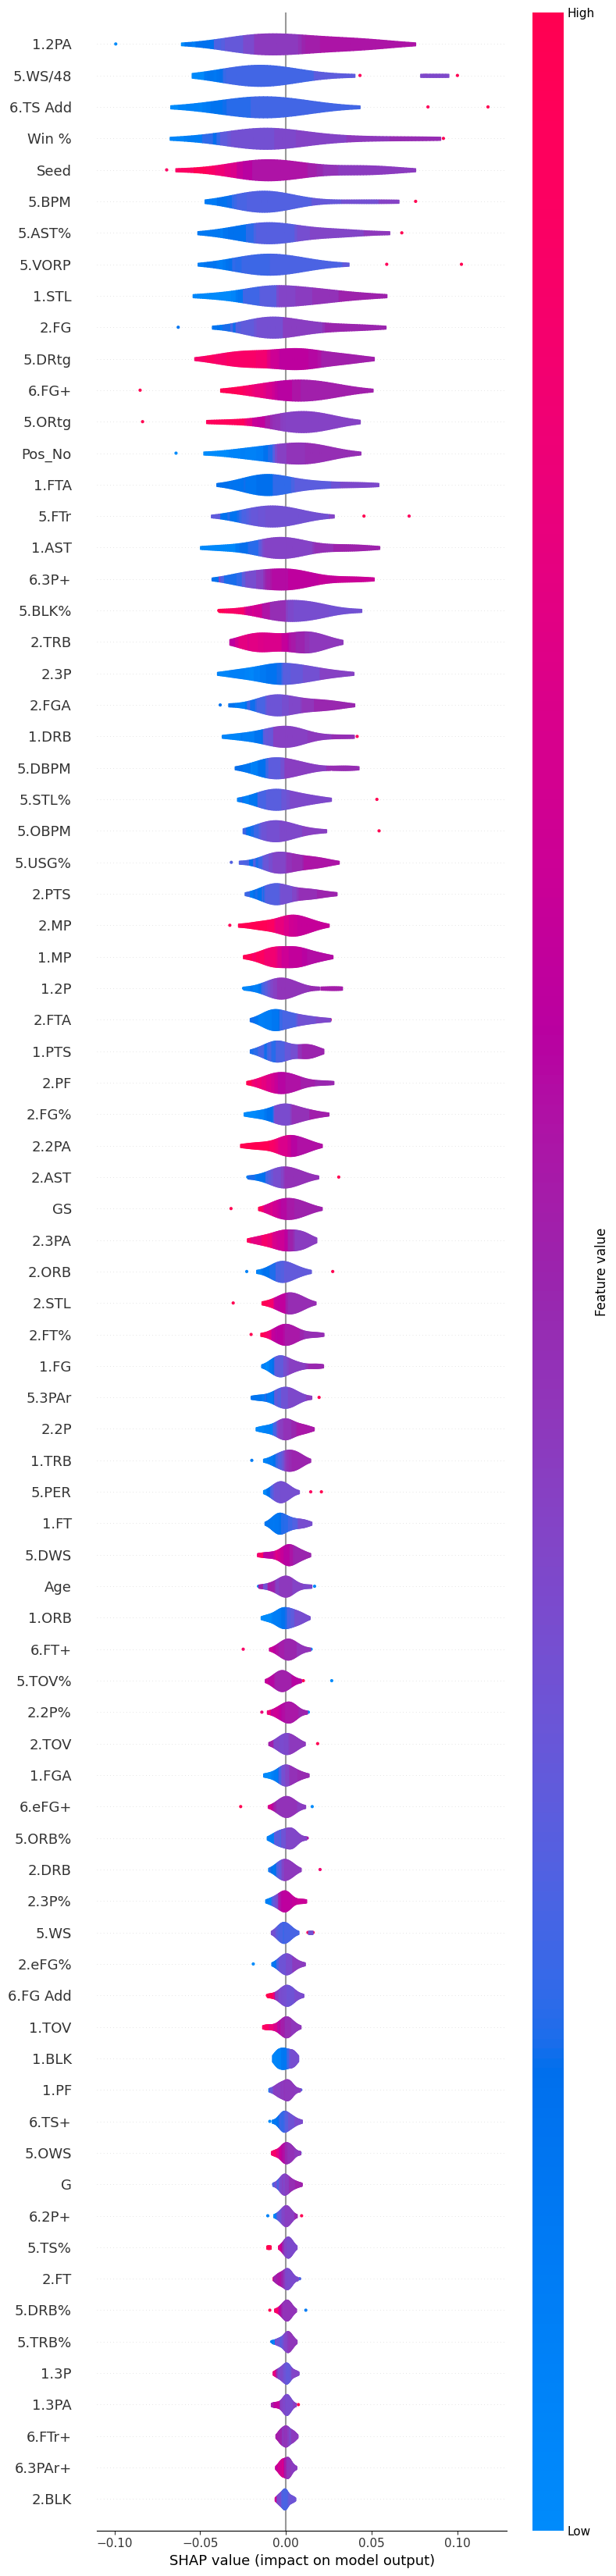

In [23]:
explainer = shap.Explainer(model.predict, normed_test_data)
shap_values = explainer(normed_test_data)
shap.summary_plot(shap_values, test, feature_names=test.columns ,plot_type='violin', max_display=len(test.columns))

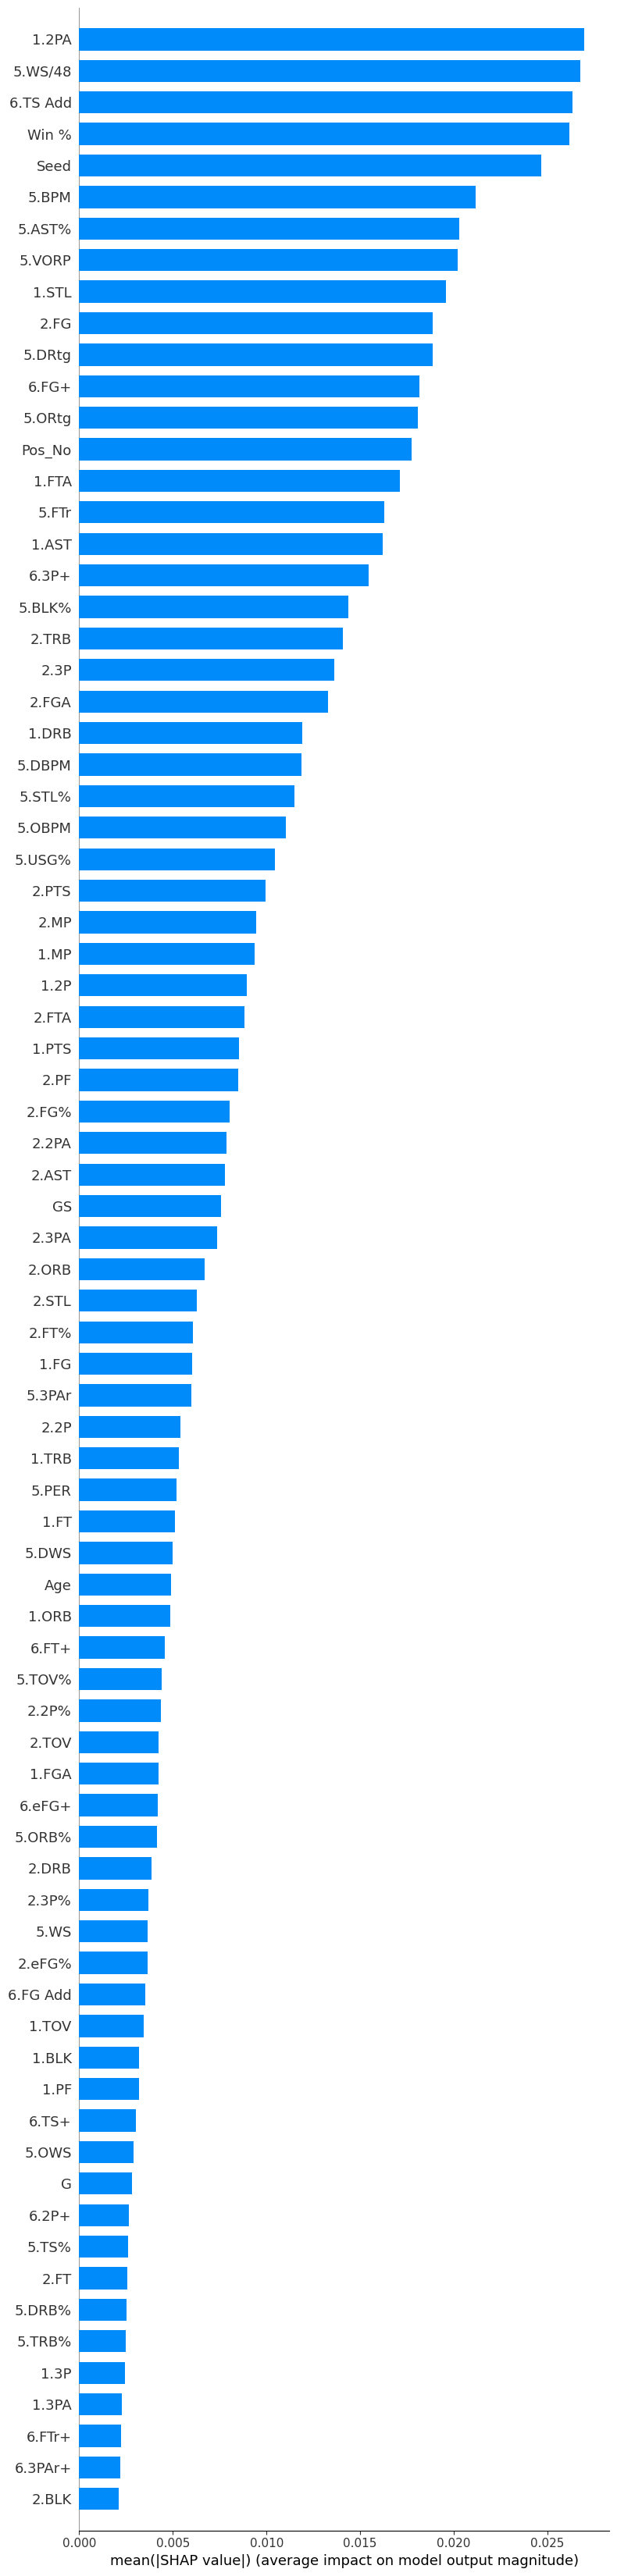

In [24]:
shap.summary_plot(shap_values, test, feature_names=test.columns ,plot_type='bar', max_display=len(test.columns))

In [25]:
leagueavs = pd.read_csv('LeagueAveragesByYear.csv')

In [26]:
histo_test2_1213 = pd.read_csv('HistoTest2-12_13.csv')

In [27]:
histo_test2_1213

,Unnamed: 0,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,Win %,...,6.eFG+,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Share,Year
0,24,LeBron James,PF,4,28,MIA,76,76,1,0.804878,...,121,100,120,146,77.0,288.7,336.6,1,0.998,2012-13
1,25,Michael Jordan,SG,2,32,CHI,82,82,1,0.878049,...,105,113,107,108,70.0,97.7,172.3,1,0.986,1995-96
2,26,Hakeem Olajuwon,C,5,31,HOU,80,80,2,0.707317,...,109,97,107,101,10.0,152.0,144.1,1,0.880,1993-94
3,27,Charles Barkley,PF,4,29,PHO,76,76,1,0.756098,...,111,101,111,131,153.0,148.4,193.4,1,0.852,1992-93
4,28,David Robinson,C,5,29,SAS,81,81,1,0.756098,...,106,105,111,171,7.0,95.5,218.9,1,0.858,1994-95
5,29,Karl Malone,PF,4,33,UTA,82,82,2,0.780488,...,112,102,112,137,4.0,179.1,240.9,1,0.857,1996-97


In [28]:
df1 = pd.read_csv('ModernEra.csv')

In [29]:
histo_test2_1213.drop(histo_test2_1213.columns[[0]], axis = 1, inplace=True)

In [30]:
training_data = df1.copy()
train = training_data.drop(['Player', 'Pos', 'Tm', 'MVP', 'MVP Rank', 'MVP Share', 'Year'] + col_to_drop, axis=1)
train_labels = training_data['MVP Share']

train.fillna(0)

scaler = StandardScaler()
normed_train_data = scaler.fit_transform(train)

In [31]:
test = histo_test2_1213.drop(['Player', 'Pos', 'Tm', 'MVP', 'MVP Share', 'Year'] + col_to_drop, axis=1)

test.fillna(0)
scaler = StandardScaler()
normed_test_data = scaler.fit_transform(test)

EPOCHS = 80
batch_size = 50

model = build_model3_five_hidden_layers()
print('Here is a summary of this model: ')
model.summary()


with tf.device('/CPU:0'): 
    history = model.fit(
        normed_train_data, 
        train_labels,
        batch_size = batch_size,
        epochs=EPOCHS, 
        verbose=1,
        shuffle=True,
        steps_per_epoch = int(normed_train_data.shape[0] / batch_size) ,
        callbacks=[tfdocs.modeling.EpochDots(), 
                ckpt_callback
                  ],
        
    )
Y_pred = model.predict(normed_test_data)
initial_results = histo_test2_1213[['Year', 'Player', 'Age', 'MVP']]
results = initial_results.copy()
results['Predicted MVP Share'] = Y_pred

print(results)

Here is a summary of this model: 
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_81 (Dense)            (None, 32)                2560      
                                                                 
 dense_82 (Dense)            (None, 64)                2112      
                                                                 
 dense_83 (Dense)            (None, 64)                4160      
                                                                 
 dense_84 (Dense)            (None, 64)                4160      
                                                                 
 dense_85 (Dense)            (None, 64)                4160      
                                                                 
 dense_86 (Dense)            (None, 64)                4160      
                                                                 
 dense_87 (Dense)  

2/2 [==============================] - 2s 30ms/step - loss: 1.1490 - mae: 0.7724 - mse: 1.1490 - mape: 14451.6953
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0906 - mae: 0.2227 - mse: 0.0906 - mape: 4312.7485.

2/2 [==============================] - 0s 18ms/step - loss: 0.1295 - mae: 0.2431 - mse: 0.1295 - mape: 2451.6062
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.1596 - mae: 0.2898 - mse: 0.1596 - mape: 2386.7888.

2/2 [==============================] - 0s 15ms/step - loss: 0.1359 - mae: 0.2506 - mse: 0.1359 - mape: 2080.9829
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0469 - mae: 0.1331 - mse: 0.0469 - mape: 992.1383.

2/2 [==============================] - 0s 16ms/step - loss: 0.1004 - mae: 0.1959 - mse: 0.1004 - mape: 1280.7150
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0864 - mae: 0.2334 - mse: 0.0864 - mape: 3887.9326.

2/2 [==============================] - 0s 18ms/step - loss: 0.0935 - mae: 0.2620 - mse: 0.0935 - mape: 5040.9619
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0915 - mae: 0.2642 - mse: 0.0915 - mape: 4551.2485.

2/2 [==============================] - 0s 17ms/step - loss: 0.0737 - mae: 0.2294 - mse: 0.0737 - mape: 4305.9194
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0375 - mae: 0.1315 - mse: 0.0375 - mape: 1468.7965.

2/2 [==============================] - 0s 18ms/step - loss: 0.0550 - mae: 0.1622 - mse: 0.0550 - mape: 1489.4694
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0445 - mae: 0.1548 - mse: 0.0445 - mape: 2664.2625.

2/2 [==============================] - 0s 21ms/step - loss: 0.0380 - mae: 0.1453 - mse: 0.0380 - mape: 2029.4905
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0250 - mae: 0.1082 - mse: 0.0250 - mape: 721.6851.

2/2 [==============================] - 0s 21ms/step - loss: 0.0267 - mae: 0.1173 - mse: 0.0267 - mape: 1500.8488
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0185 - mae: 0.1032 - mse: 0.0185 - mape: 1845.0057.

2/2 [==============================] - 0s 22ms/step - loss: 0.0205 - mae: 0.1075 - mse: 0.0205 - mape: 1582.6108
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0218 - mae: 0.0903 - mse: 0.0218 - mape: 587.5096.

2/2 [==============================] - 0s 19ms/step - loss: 0.0211 - mae: 0.0960 - mse: 0.0211 - mape: 623.6431
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0191 - mae: 0.0912 - mse: 0.0191 - mape: 1545.3549.

2/2 [==============================] - 0s 15ms/step - loss: 0.0168 - mae: 0.0853 - mse: 0.0168 - mape: 1097.2919
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0242 - mae: 0.1147 - mse: 0.0242 - mape: 1404.4392.

2/2 [==============================] - 0s 16ms/step - loss: 0.0206 - mae: 0.1087 - mse: 0.0206 - mape: 1394.4972
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0110 - mae: 0.0724 - mse: 0.0110 - mape: 1496.2684.

2/2 [==============================] - 0s 18ms/step - loss: 0.0158 - mae: 0.0845 - mse: 0.0158 - mape: 1129.9486
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0171 - mae: 0.0931 - mse: 0.0171 - mape: 1031.4005.

2/2 [==============================] - 0s 16ms/step - loss: 0.0138 - mae: 0.0820 - mse: 0.0138 - mape: 836.0775
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0077 - mae: 0.0657 - mse: 0.0077 - mape: 1139.5841.

2/2 [==============================] - 0s 20ms/step - loss: 0.0117 - mae: 0.0788 - mse: 0.0117 - mape: 997.9495
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0196 - mae: 0.0962 - mse: 0.0196 - mape: 857.4572.

2/2 [==============================] - 0s 19ms/step - loss: 0.0132 - mae: 0.0764 - mse: 0.0132 - mape: 614.7783
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0122 - mae: 0.0699 - mse: 0.0122 - mape: 567.5556.

2/2 [==============================] - 0s 22ms/step - loss: 0.0167 - mae: 0.0852 - mse: 0.0167 - mape: 622.9680
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0104 - mae: 0.0680 - mse: 0.0104 - mape: 964.1674.

2/2 [==============================] - 0s 21ms/step - loss: 0.0139 - mae: 0.0867 - mse: 0.0139 - mape: 1081.2465
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0209 - mae: 0.1107 - mse: 0.0209 - mape: 2445.6216.

2/2 [==============================] - 0s 19ms/step - loss: 0.0107 - mae: 0.0730 - mse: 0.0107 - mape: 1357.7589
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0153 - mae: 0.0839 - mse: 0.0153 - mape: 914.1033.

2/2 [==============================] - 0s 13ms/step - loss: 0.0142 - mae: 0.0831 - mse: 0.0142 - mape: 726.5900
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0136 - mae: 0.0826 - mse: 0.0136 - mape: 367.6249.

2/2 [==============================] - 0s 15ms/step - loss: 0.0106 - mae: 0.0688 - mse: 0.0106 - mape: 417.5600
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0079 - mae: 0.0661 - mse: 0.0079 - mape: 1155.5287.

2/2 [==============================] - 0s 13ms/step - loss: 0.0146 - mae: 0.0826 - mse: 0.0146 - mape: 839.0103
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0089 - mae: 0.0651 - mse: 0.0089 - mape: 481.8695.

2/2 [==============================] - 0s 14ms/step - loss: 0.0082 - mae: 0.0627 - mse: 0.0082 - mape: 618.7379
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0064 - mae: 0.0509 - mse: 0.0064 - mape: 862.8818.

2/2 [==============================] - 0s 15ms/step - loss: 0.0113 - mae: 0.0701 - mse: 0.0113 - mape: 572.9667
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0109 - mae: 0.0778 - mse: 0.0109 - mape: 1043.9689.

2/2 [==============================] - 0s 14ms/step - loss: 0.0101 - mae: 0.0798 - mse: 0.0101 - mape: 1481.5111
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0123 - mae: 0.0880 - mse: 0.0123 - mape: 1110.9199.

2/2 [==============================] - 0s 18ms/step - loss: 0.0107 - mae: 0.0793 - mse: 0.0107 - mape: 1112.8087
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0046 - mae: 0.0507 - mse: 0.0046 - mape: 386.3736.

2/2 [==============================] - 0s 18ms/step - loss: 0.0057 - mae: 0.0523 - mse: 0.0057 - mape: 397.9993
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0116 - mae: 0.0776 - mse: 0.0116 - mape: 1199.1034.

2/2 [==============================] - 0s 18ms/step - loss: 0.0085 - mae: 0.0666 - mse: 0.0085 - mape: 586.5735
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0044 - mae: 0.0415 - mse: 0.0044 - mape: 524.3918.

2/2 [==============================] - 0s 17ms/step - loss: 0.0053 - mae: 0.0481 - mse: 0.0053 - mape: 900.6852
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0061 - mae: 0.0623 - mse: 0.0061 - mape: 925.7514.

2/2 [==============================] - 0s 17ms/step - loss: 0.0065 - mae: 0.0636 - mse: 0.0065 - mape: 929.0678
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0046 - mae: 0.0550 - mse: 0.0046 - mape: 1498.1121.

2/2 [==============================] - 0s 19ms/step - loss: 0.0050 - mae: 0.0516 - mse: 0.0050 - mape: 903.5468
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0033 - mae: 0.0367 - mse: 0.0033 - mape: 304.5316.

2/2 [==============================] - 0s 18ms/step - loss: 0.0038 - mae: 0.0424 - mse: 0.0038 - mape: 309.7424
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0381 - mse: 0.0025 - mape: 398.6430.

2/2 [==============================] - 0s 17ms/step - loss: 0.0030 - mae: 0.0397 - mse: 0.0030 - mape: 514.9255
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0045 - mae: 0.0480 - mse: 0.0045 - mape: 314.3712.

2/2 [==============================] - 0s 15ms/step - loss: 0.0045 - mae: 0.0471 - mse: 0.0045 - mape: 447.4756
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0044 - mae: 0.0484 - mse: 0.0044 - mape: 462.3651.

2/2 [==============================] - 0s 13ms/step - loss: 0.0038 - mae: 0.0472 - mse: 0.0038 - mape: 570.8769
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0056 - mae: 0.0593 - mse: 0.0056 - mape: 873.9897.

2/2 [==============================] - 0s 15ms/step - loss: 0.0047 - mae: 0.0508 - mse: 0.0047 - mape: 715.1853
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0034 - mae: 0.0417 - mse: 0.0034 - mape: 405.9882.

2/2 [==============================] - 0s 15ms/step - loss: 0.0034 - mae: 0.0395 - mse: 0.0034 - mape: 453.4129
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0028 - mae: 0.0382 - mse: 0.0028 - mape: 381.2920.

2/2 [==============================] - 0s 14ms/step - loss: 0.0032 - mae: 0.0415 - mse: 0.0032 - mape: 371.5148
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0031 - mae: 0.0425 - mse: 0.0031 - mape: 345.9758.

2/2 [==============================] - 0s 16ms/step - loss: 0.0021 - mae: 0.0348 - mse: 0.0021 - mape: 405.4859
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0388 - mse: 0.0025 - mape: 402.5492.

2/2 [==============================] - 0s 21ms/step - loss: 0.0026 - mae: 0.0363 - mse: 0.0026 - mape: 364.0225
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0022 - mae: 0.0350 - mse: 0.0022 - mape: 386.1691.

2/2 [==============================] - 0s 14ms/step - loss: 0.0026 - mae: 0.0392 - mse: 0.0026 - mape: 665.2169
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0023 - mae: 0.0342 - mse: 0.0023 - mape: 785.9570.

2/2 [==============================] - 0s 16ms/step - loss: 0.0019 - mae: 0.0315 - mse: 0.0019 - mape: 477.0866
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0026 - mae: 0.0369 - mse: 0.0026 - mape: 325.2342.

2/2 [==============================] - 0s 17ms/step - loss: 0.0026 - mae: 0.0371 - mse: 0.0026 - mape: 451.1085
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0272 - mse: 0.0013 - mape: 252.1075.

2/2 [==============================] - 0s 15ms/step - loss: 0.0023 - mae: 0.0337 - mse: 0.0023 - mape: 467.7967
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0258 - mse: 0.0011 - mape: 435.1104.

2/2 [==============================] - 0s 14ms/step - loss: 0.0020 - mae: 0.0336 - mse: 0.0020 - mape: 596.5920
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - mae: 0.0416 - mse: 0.0027 - mape: 1111.3075.

2/2 [==============================] - 0s 16ms/step - loss: 0.0024 - mae: 0.0389 - mse: 0.0024 - mape: 872.9074
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0406 - mse: 0.0025 - mape: 769.9294.

2/2 [==============================] - 0s 16ms/step - loss: 0.0020 - mae: 0.0350 - mse: 0.0020 - mape: 703.5941
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0021 - mae: 0.0315 - mse: 0.0021 - mape: 245.6255.

2/2 [==============================] - 0s 16ms/step - loss: 0.0015 - mae: 0.0266 - mse: 0.0015 - mape: 231.9150
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0020 - mae: 0.0333 - mse: 0.0020 - mape: 393.4225.

2/2 [==============================] - 0s 14ms/step - loss: 0.0014 - mae: 0.0274 - mse: 0.0014 - mape: 334.1201
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0285 - mse: 0.0017 - mape: 174.3959.

2/2 [==============================] - 0s 16ms/step - loss: 0.0017 - mae: 0.0277 - mse: 0.0017 - mape: 214.6446
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0230 - mse: 0.0012 - mape: 246.9384.

2/2 [==============================] - 0s 15ms/step - loss: 0.0012 - mae: 0.0250 - mse: 0.0012 - mape: 221.8631
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 5.0001e-04 - mae: 0.0199 - mse: 5.0001e-04 - mape: 766.9590.

2/2 [==============================] - 0s 14ms/step - loss: 0.0014 - mae: 0.0255 - mse: 0.0014 - mape: 507.3060   
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0012 - mae: 0.0219 - mse: 0.0012 - mape: 232.3752.

2/2 [==============================] - 0s 15ms/step - loss: 0.0013 - mae: 0.0240 - mse: 0.0013 - mape: 251.9424
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0011 - mae: 0.0215 - mse: 0.0011 - mape: 325.3954.

2/2 [==============================] - 0s 20ms/step - loss: 0.0010 - mae: 0.0224 - mse: 0.0010 - mape: 266.0298
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0280 - mse: 0.0014 - mape: 198.2435.

2/2 [==============================] - 0s 14ms/step - loss: 0.0011 - mae: 0.0248 - mse: 0.0011 - mape: 242.9735
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 7.6149e-04 - mae: 0.0216 - mse: 7.6149e-04 - mape: 420.5426.

2/2 [==============================] - 0s 15ms/step - loss: 7.3957e-04 - mae: 0.0214 - mse: 7.3957e-04 - mape: 469.6483
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 8.2244e-04 - mae: 0.0229 - mse: 8.2244e-04 - mape: 399.1525.

2/2 [==============================] - 0s 15ms/step - loss: 6.2654e-04 - mae: 0.0203 - mse: 6.2654e-04 - mape: 404.8912
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 9.5416e-04 - mae: 0.0193 - mse: 9.5416e-04 - mape: 355.9444.

2/2 [==============================] - 0s 14ms/step - loss: 8.9778e-04 - mae: 0.0193 - mse: 8.9778e-04 - mape: 331.7242
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 3.7621e-04 - mae: 0.0150 - mse: 3.7621e-04 - mape: 153.3748.

2/2 [==============================] - 0s 16ms/step - loss: 4.0164e-04 - mae: 0.0154 - mse: 4.0164e-04 - mape: 181.3255
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 5.2431e-04 - mae: 0.0170 - mse: 5.2431e-04 - mape: 205.9279.

2/2 [==============================] - 0s 15ms/step - loss: 5.1654e-04 - mae: 0.0155 - mse: 5.1654e-04 - mape: 223.2691
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 4.8597e-04 - mae: 0.0146 - mse: 4.8597e-04 - mape: 206.3061.

2/2 [==============================] - 0s 16ms/step - loss: 4.6320e-04 - mae: 0.0140 - mse: 4.6320e-04 - mape: 173.8394
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 8.2787e-04 - mae: 0.0182 - mse: 8.2787e-04 - mape: 189.8250.

2/2 [==============================] - 0s 16ms/step - loss: 7.5729e-04 - mae: 0.0182 - mse: 7.5729e-04 - mape: 297.8533
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 3.6502e-04 - mae: 0.0143 - mse: 3.6502e-04 - mape: 215.1616.

2/2 [==============================] - 0s 15ms/step - loss: 6.1587e-04 - mae: 0.0158 - mse: 6.1587e-04 - mape: 169.9656
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 4.3640e-04 - mae: 0.0154 - mse: 4.3640e-04 - mape: 293.1859.

2/2 [==============================] - 0s 15ms/step - loss: 4.3538e-04 - mae: 0.0154 - mse: 4.3538e-04 - mape: 180.4622
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 5.6038e-04 - mae: 0.0172 - mse: 5.6038e-04 - mape: 207.6679.

2/2 [==============================] - 0s 16ms/step - loss: 6.5923e-04 - mae: 0.0178 - mse: 6.5923e-04 - mape: 197.0959
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 4.2396e-04 - mae: 0.0144 - mse: 4.2396e-04 - mape: 300.7660.

2/2 [==============================] - 0s 17ms/step - loss: 6.5243e-04 - mae: 0.0171 - mse: 6.5243e-04 - mape: 241.5146
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 2.3570e-04 - mae: 0.0124 - mse: 2.3570e-04 - mape: 298.3324.

2/2 [==============================] - 0s 18ms/step - loss: 2.5821e-04 - mae: 0.0127 - mse: 2.5821e-04 - mape: 274.4687
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 8.2451e-04 - mae: 0.0189 - mse: 8.2451e-04 - mape: 185.7728.

2/2 [==============================] - 0s 17ms/step - loss: 7.3934e-04 - mae: 0.0174 - mse: 7.3934e-04 - mape: 160.8783
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 2.7511e-04 - mae: 0.0116 - mse: 2.7511e-04 - mape: 74.4921.

2/2 [==============================] - 0s 16ms/step - loss: 3.7571e-04 - mae: 0.0130 - mse: 3.7571e-04 - mape: 178.9828
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 5.1482e-04 - mae: 0.0154 - mse: 5.1482e-04 - mape: 267.3711.

2/2 [==============================] - 0s 17ms/step - loss: 4.5794e-04 - mae: 0.0149 - mse: 4.5794e-04 - mape: 212.8654
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 6.0612e-04 - mae: 0.0166 - mse: 6.0612e-04 - mape: 196.3949.

2/2 [==============================] - 0s 16ms/step - loss: 5.3891e-04 - mae: 0.0156 - mse: 5.3891e-04 - mape: 177.1411
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 4.9763e-04 - mae: 0.0186 - mse: 4.9763e-04 - mape: 320.0236.

2/2 [==============================] - 0s 17ms/step - loss: 4.8497e-04 - mae: 0.0172 - mse: 4.8497e-04 - mape: 374.0368
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 2.0135e-04 - mae: 0.0126 - mse: 2.0135e-04 - mape: 296.5639.

2/2 [==============================] - 0s 16ms/step - loss: 2.9338e-04 - mae: 0.0123 - mse: 2.9338e-04 - mape: 197.3870
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 4.2091e-04 - mae: 0.0148 - mse: 4.2091e-04 - mape: 207.2892.

2/2 [==============================] - 0s 16ms/step - loss: 4.1469e-04 - mae: 0.0142 - mse: 4.1469e-04 - mape: 178.4240
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 4.6995e-04 - mae: 0.0131 - mse: 4.6995e-04 - mape: 94.6386.

2/2 [==============================] - 0s 17ms/step - loss: 4.7478e-04 - mae: 0.0131 - mse: 4.7478e-04 - mape: 135.0705
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 1.1071e-04 - mae: 0.0080 - mse: 1.1071e-04 - mape: 114.9160.

2/2 [==============================] - 0s 16ms/step - loss: 2.2795e-04 - mae: 0.0101 - mse: 2.2795e-04 - mape: 148.4461
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 5.2347e-04 - mae: 0.0156 - mse: 5.2347e-04 - mape: 158.4178.

2/2 [==============================] - 0s 16ms/step - loss: 3.9436e-04 - mae: 0.0139 - mse: 3.9436e-04 - mape: 171.7423
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 3.3890e-04 - mae: 0.0135 - mse: 3.3890e-04 - mape: 158.8163.

2/2 [==============================] - 0s 16ms/step - loss: 4.3371e-04 - mae: 0.0142 - mse: 4.3371e-04 - mape: 172.2650
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 3.6690e-04 - mae: 0.0119 - mse: 3.6690e-04 - mape: 174.8268.

1/1 [==============================] - 0s 96ms/step
      Year           Player  Age  MVP  Predicted MVP Share
0  2012-13     LeBron James   28    1             0.463800
1  1995-96   Michael Jordan   32    1             0.120449
2  1993-94  Hakeem Olajuwon   31    1            -0.016326
3  1992-93  Charles Barkley   29    1             0.000021
4  1994-95   David Robinson   29    1             0.071474
5  1996-97      Karl Malone   33    1                  NaN


In [33]:
results = results.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)
results

,Year,Player,Age,MVP,Predicted MVP Share
0,2012-13,LeBron James,28,1,0.463800
1,1995-96,Michael Jordan,32,1,0.120449
2,1994-95,David Robinson,29,1,0.071474
3,1992-93,Charles Barkley,29,1,0.000021
4,1993-94,Hakeem Olajuwon,31,1,-0.016326
5,1996-97,Karl Malone,33,1,NaN


HISTORICAL ANALYSIS FOR RECENT SEASONS

In [34]:
histo_test3 = pd.read_csv('HistoTest3.csv')

In [35]:
histo_test3

,Unnamed: 0,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,Win %,...,6.eFG+,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Share,Year
0,0,Michael Jordan,SG,2,33,CHI,82,82,1,0.841463,...,105,113,106,95,74.0,85.7,132.8,0,0.832,1996-97
1,1,Hakeem Olajuwon,C,5,34,HOU,78,78,4,0.695122,...,104,107,104,98,5.0,53.1,72.2,0,0.083,1996-97
2,2,Charles Barkley,PF,4,32,PHO,71,71,15,0.500000,...,104,105,108,148,75.0,51.9,121.7,0,0.007,1995-96
3,3,David Robinson,C,5,26,SAS,68,68,10,0.573171,...,113,92,112,171,9.0,139.1,174.2,0,0.351,1991-92
4,4,Karl Malone,PF,4,28,UTA,81,81,5,0.670732,...,108,103,113,187,13.0,122.7,256.3,0,0.273,1991-92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,70,Stephen Curry,PG,1,33,GSW,64,64,3,0.646341,...,104,119,106,98,153.0,53.4,96.0,0,0.004,2021-22
71,71,Nikola Jokić,C,5,26,DEN,74,74,10,0.585366,...,117,105,117,144,55.0,230.9,286.9,1,0.875,2021-22
72,72,Joel Embiid,C,5,27,PHI,68,68,8,0.621951,...,100,105,109,243,47.0,6.5,169.0,0,0.706,2021-22
73,73,Kevin Durant,PF,4,33,BRK,55,55,14,0.536585,...,107,117,112,148,67.0,85.3,177.1,0,0.001,2021-22


In [36]:
df1 = pd.read_csv('ModernEra.csv')

In [37]:
histo_test3.drop(histo_test3.columns[[0]], axis = 1, inplace=True)

In [38]:
histo_test3

,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,Win %,1.MP,...,6.eFG+,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Share,Year
0,Michael Jordan,SG,2,33,CHI,82,82,1,0.841463,3106,...,105,113,106,95,74.0,85.7,132.8,0,0.832,1996-97
1,Hakeem Olajuwon,C,5,34,HOU,78,78,4,0.695122,2852,...,104,107,104,98,5.0,53.1,72.2,0,0.083,1996-97
2,Charles Barkley,PF,4,32,PHO,71,71,15,0.500000,2632,...,104,105,108,148,75.0,51.9,121.7,0,0.007,1995-96
3,David Robinson,C,5,26,SAS,68,68,10,0.573171,2564,...,113,92,112,171,9.0,139.1,174.2,0,0.351,1991-92
4,Karl Malone,PF,4,28,UTA,81,81,5,0.670732,3054,...,108,103,113,187,13.0,122.7,256.3,0,0.273,1991-92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,Stephen Curry,PG,1,33,GSW,64,64,3,0.646341,2211,...,104,119,106,98,153.0,53.4,96.0,0,0.004,2021-22
71,Nikola Jokić,C,5,26,DEN,74,74,10,0.585366,2476,...,117,105,117,144,55.0,230.9,286.9,1,0.875,2021-22
72,Joel Embiid,C,5,27,PHI,68,68,8,0.621951,2297,...,100,105,109,243,47.0,6.5,169.0,0,0.706,2021-22
73,Kevin Durant,PF,4,33,BRK,55,55,14,0.536585,2047,...,107,117,112,148,67.0,85.3,177.1,0,0.001,2021-22


In [48]:
histo_test3[(histo_test3['Player'] == "Shaquille O'Neal")]

,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,Win %,1.MP,...,6.eFG+,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Share,Year
5,Shaquille O'Neal,C,5,28,LAL,74,74,2,0.682927,2924,...,121,69,111,222,1.0,281.2,209.3,0,0.466,2000-01
16,Shaquille O'Neal,C,5,28,LAL,74,74,2,0.682927,2924,...,121,69,111,222,1.0,281.2,209.3,0,0.466,2000-01
29,Shaquille O'Neal,C,5,29,LAL,67,66,2,0.707317,2422,...,121,74,113,199,NaN,251.2,214.8,0,0.552,2001-02
43,Shaquille O'Neal,C,5,22,ORL,79,79,4,0.695122,2923,...,117,72,108,161,2.0,266.5,176.4,0,0.576,1994-95
54,Shaquille O'Neal,C,5,32,MIA,73,73,2,0.719512,2492,...,125,61,110,215,NaN,259.7,153.2,0,0.813,2004-05
67,Shaquille O'Neal,C,5,27,LAL,79,79,1,0.817073,3163,...,120,70,111,161,NaN,319.7,223.9,1,0.998,1999-00


In [39]:
training_data = df1.copy()
train = training_data.drop(['Player', 'Pos', 'Tm', 'MVP', 'MVP Rank', 'MVP Share', 'Year'] + col_to_drop, axis=1)
train_labels = training_data['MVP Share']

train.fillna(0)

scaler = StandardScaler()
normed_train_data = scaler.fit_transform(train)

In [40]:
test = histo_test3.drop(['Player', 'Pos', 'Tm', 'MVP', 'MVP Share', 'Year'] + col_to_drop, axis=1)

test.fillna(0)
scaler = StandardScaler()
normed_test_data = scaler.fit_transform(test)

EPOCHS = 80
batch_size = 50

model = build_model3_five_hidden_layers()
print('Here is a summary of this model: ')
model.summary()


with tf.device('/CPU:0'): 
    history = model.fit(
        normed_train_data, 
        train_labels,
        batch_size = batch_size,
        epochs=EPOCHS, 
        verbose=1,
        shuffle=True,
        steps_per_epoch = int(normed_train_data.shape[0] / batch_size) ,
        callbacks=[tfdocs.modeling.EpochDots(), 
                ckpt_callback
                  ],
        
    )
Y_pred = model.predict(normed_test_data)
initial_results = histo_test3[['Year', 'Player', 'Age', 'MVP']]
results = initial_results.copy()
results['Predicted MVP Share'] = Y_pred

print(results)

Here is a summary of this model: 
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 32)                2560      
                                                                 
 dense_89 (Dense)            (None, 64)                2112      
                                                                 
 dense_90 (Dense)            (None, 64)                4160      
                                                                 
 dense_91 (Dense)            (None, 64)                4160      
                                                                 
 dense_92 (Dense)            (None, 64)                4160      
                                                                 
 dense_93 (Dense)            (None, 64)                4160      
                                                                 
 dense_94 (Dense)  

2/2 [==============================] - 2s 23ms/step - loss: 0.2598 - mae: 0.3904 - mse: 0.2598 - mape: 8089.8999
Epoch 2/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0800 - mae: 0.2094 - mse: 0.0800 - mape: 1739.8402.

2/2 [==============================] - 0s 15ms/step - loss: 0.0807 - mae: 0.1855 - mse: 0.0807 - mape: 1772.3342
Epoch 3/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0918 - mae: 0.1827 - mse: 0.0918 - mape: 788.2937.

2/2 [==============================] - 0s 14ms/step - loss: 0.0854 - mae: 0.1836 - mse: 0.0854 - mape: 1257.3071
Epoch 4/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0315 - mae: 0.1401 - mse: 0.0315 - mape: 2281.3777.

2/2 [==============================] - 0s 14ms/step - loss: 0.0378 - mae: 0.1503 - mse: 0.0378 - mape: 2310.4871
Epoch 5/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0578 - mae: 0.1633 - mse: 0.0578 - mape: 784.4106.

2/2 [==============================] - 0s 14ms/step - loss: 0.0427 - mae: 0.1315 - mse: 0.0427 - mape: 655.5887
Epoch 6/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0208 - mae: 0.0937 - mse: 0.0208 - mape: 1569.9482.

2/2 [==============================] - 0s 14ms/step - loss: 0.0293 - mae: 0.1083 - mse: 0.0293 - mape: 1354.9868
Epoch 7/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0441 - mae: 0.1519 - mse: 0.0441 - mape: 1903.8895.

2/2 [==============================] - 0s 19ms/step - loss: 0.0327 - mae: 0.1291 - mse: 0.0327 - mape: 2047.0752
Epoch 8/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0383 - mae: 0.1305 - mse: 0.0383 - mape: 1456.2526.

2/2 [==============================] - 0s 14ms/step - loss: 0.0232 - mae: 0.1083 - mse: 0.0232 - mape: 1472.7898
Epoch 9/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0461 - mae: 0.1330 - mse: 0.0461 - mape: 1014.8331.

2/2 [==============================] - 0s 13ms/step - loss: 0.0419 - mae: 0.1310 - mse: 0.0419 - mape: 939.5486
Epoch 10/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0336 - mae: 0.1191 - mse: 0.0336 - mape: 933.9612.

2/2 [==============================] - 0s 14ms/step - loss: 0.0366 - mae: 0.1204 - mse: 0.0366 - mape: 656.0211
Epoch 11/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0440 - mae: 0.1265 - mse: 0.0440 - mape: 510.3658.

2/2 [==============================] - 0s 15ms/step - loss: 0.0286 - mae: 0.1097 - mse: 0.0286 - mape: 724.1057
Epoch 12/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0225 - mae: 0.1039 - mse: 0.0225 - mape: 1320.6350.

2/2 [==============================] - 0s 15ms/step - loss: 0.0251 - mae: 0.1084 - mse: 0.0251 - mape: 1160.5195
Epoch 13/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0175 - mae: 0.0968 - mse: 0.0175 - mape: 703.9548.

2/2 [==============================] - 0s 19ms/step - loss: 0.0167 - mae: 0.0926 - mse: 0.0167 - mape: 631.8713
Epoch 14/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0268 - mae: 0.1067 - mse: 0.0268 - mape: 807.7229.

2/2 [==============================] - 0s 14ms/step - loss: 0.0245 - mae: 0.0986 - mse: 0.0245 - mape: 599.0952
Epoch 15/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0196 - mae: 0.0924 - mse: 0.0196 - mape: 586.7596.

2/2 [==============================] - 0s 15ms/step - loss: 0.0164 - mae: 0.0850 - mse: 0.0164 - mape: 1011.5749
Epoch 16/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0115 - mae: 0.0776 - mse: 0.0115 - mape: 846.0314.

2/2 [==============================] - 0s 15ms/step - loss: 0.0115 - mae: 0.0796 - mse: 0.0115 - mape: 1070.9777
Epoch 17/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0149 - mae: 0.0831 - mse: 0.0149 - mape: 554.0106.

2/2 [==============================] - 0s 14ms/step - loss: 0.0133 - mae: 0.0787 - mse: 0.0133 - mape: 560.4074
Epoch 18/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0095 - mae: 0.0682 - mse: 0.0095 - mape: 429.5646.

2/2 [==============================] - 0s 14ms/step - loss: 0.0098 - mae: 0.0655 - mse: 0.0098 - mape: 458.8330
Epoch 19/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0121 - mae: 0.0696 - mse: 0.0121 - mape: 595.6500.

2/2 [==============================] - 0s 14ms/step - loss: 0.0115 - mae: 0.0728 - mse: 0.0115 - mape: 676.5140
Epoch 20/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0055 - mae: 0.0570 - mse: 0.0055 - mape: 1286.3330.

2/2 [==============================] - 0s 13ms/step - loss: 0.0074 - mae: 0.0626 - mse: 0.0074 - mape: 938.4167
Epoch 21/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0094 - mae: 0.0640 - mse: 0.0094 - mape: 489.3327.

2/2 [==============================] - 0s 16ms/step - loss: 0.0084 - mae: 0.0598 - mse: 0.0084 - mape: 554.2001
Epoch 22/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0074 - mae: 0.0581 - mse: 0.0074 - mape: 517.9836.

2/2 [==============================] - 0s 17ms/step - loss: 0.0073 - mae: 0.0570 - mse: 0.0073 - mape: 504.2095
Epoch 23/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0067 - mae: 0.0635 - mse: 0.0067 - mape: 581.5530.

2/2 [==============================] - 0s 14ms/step - loss: 0.0070 - mae: 0.0617 - mse: 0.0070 - mape: 589.4130
Epoch 24/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0072 - mae: 0.0572 - mse: 0.0072 - mape: 472.7333.

2/2 [==============================] - 0s 13ms/step - loss: 0.0067 - mae: 0.0561 - mse: 0.0067 - mape: 497.1479
Epoch 25/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0067 - mae: 0.0567 - mse: 0.0067 - mape: 654.4752.

2/2 [==============================] - 0s 14ms/step - loss: 0.0066 - mae: 0.0576 - mse: 0.0066 - mape: 545.3320
Epoch 26/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0043 - mae: 0.0493 - mse: 0.0043 - mape: 620.9836.

2/2 [==============================] - 0s 15ms/step - loss: 0.0038 - mae: 0.0462 - mse: 0.0038 - mape: 543.3319
Epoch 27/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0076 - mae: 0.0564 - mse: 0.0076 - mape: 318.5487.

2/2 [==============================] - 0s 18ms/step - loss: 0.0057 - mae: 0.0489 - mse: 0.0057 - mape: 336.3873
Epoch 28/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0051 - mae: 0.0456 - mse: 0.0051 - mape: 272.8937.

2/2 [==============================] - 0s 13ms/step - loss: 0.0045 - mae: 0.0441 - mse: 0.0045 - mape: 360.9120
Epoch 29/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0030 - mae: 0.0408 - mse: 0.0030 - mape: 736.9996.

2/2 [==============================] - 0s 16ms/step - loss: 0.0033 - mae: 0.0408 - mse: 0.0033 - mape: 575.5240
Epoch 30/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0065 - mae: 0.0635 - mse: 0.0065 - mape: 1008.9314.

2/2 [==============================] - 0s 23ms/step - loss: 0.0052 - mae: 0.0547 - mse: 0.0052 - mape: 755.6035
Epoch 31/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0027 - mae: 0.0364 - mse: 0.0027 - mape: 227.1026.

2/2 [==============================] - 0s 21ms/step - loss: 0.0041 - mae: 0.0434 - mse: 0.0041 - mape: 267.9135
Epoch 32/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0049 - mae: 0.0481 - mse: 0.0049 - mape: 213.9025.

2/2 [==============================] - 0s 16ms/step - loss: 0.0026 - mae: 0.0337 - mse: 0.0026 - mape: 428.4144
Epoch 33/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0041 - mae: 0.0485 - mse: 0.0041 - mape: 442.1868.

2/2 [==============================] - 0s 15ms/step - loss: 0.0043 - mae: 0.0494 - mse: 0.0043 - mape: 411.8525
Epoch 34/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0026 - mae: 0.0372 - mse: 0.0026 - mape: 704.0251.

2/2 [==============================] - 0s 14ms/step - loss: 0.0025 - mae: 0.0342 - mse: 0.0025 - mape: 540.5393
Epoch 35/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0067 - mae: 0.0564 - mse: 0.0067 - mape: 212.7821.

2/2 [==============================] - 0s 14ms/step - loss: 0.0037 - mae: 0.0399 - mse: 0.0037 - mape: 317.0570
Epoch 36/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0025 - mae: 0.0315 - mse: 0.0025 - mape: 175.5917.

2/2 [==============================] - 0s 15ms/step - loss: 0.0025 - mae: 0.0330 - mse: 0.0025 - mape: 209.9754
Epoch 37/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0024 - mae: 0.0328 - mse: 0.0024 - mape: 346.9962.

2/2 [==============================] - 0s 19ms/step - loss: 0.0024 - mae: 0.0339 - mse: 0.0024 - mape: 273.7648
Epoch 38/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0030 - mae: 0.0352 - mse: 0.0030 - mape: 199.8648.

2/2 [==============================] - 0s 16ms/step - loss: 0.0021 - mae: 0.0295 - mse: 0.0021 - mape: 167.4382
Epoch 39/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0037 - mae: 0.0357 - mse: 0.0037 - mape: 196.7451.

2/2 [==============================] - 0s 13ms/step - loss: 0.0028 - mae: 0.0320 - mse: 0.0028 - mape: 262.1961
Epoch 40/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0277 - mse: 0.0014 - mape: 361.0002.

2/2 [==============================] - 0s 12ms/step - loss: 0.0022 - mae: 0.0340 - mse: 0.0022 - mape: 333.1802
Epoch 41/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0017 - mae: 0.0277 - mse: 0.0017 - mape: 329.1094.

2/2 [==============================] - 0s 17ms/step - loss: 0.0014 - mae: 0.0241 - mse: 0.0014 - mape: 199.1651
Epoch 42/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0278 - mse: 0.0014 - mape: 147.7139.

2/2 [==============================] - 0s 13ms/step - loss: 0.0014 - mae: 0.0264 - mse: 0.0014 - mape: 172.3070
Epoch 43/80
1/2 [==============>...............] - ETA: 0s - loss: 7.3304e-04 - mae: 0.0197 - mse: 7.3304e-04 - mape: 329.6099.

2/2 [==============================] - 0s 16ms/step - loss: 7.7882e-04 - mae: 0.0205 - mse: 7.7882e-04 - mape: 266.4857
Epoch 44/80
1/2 [==============>...............] - ETA: 0s - loss: 9.3278e-04 - mae: 0.0211 - mse: 9.3278e-04 - mape: 154.8686.

2/2 [==============================] - 0s 12ms/step - loss: 9.0069e-04 - mae: 0.0218 - mse: 9.0069e-04 - mape: 224.1966
Epoch 45/80
1/2 [==============>...............] - ETA: 0s - loss: 6.4303e-04 - mae: 0.0190 - mse: 6.4303e-04 - mape: 282.2898.

2/2 [==============================] - 0s 15ms/step - loss: 6.6075e-04 - mae: 0.0185 - mse: 6.6075e-04 - mape: 265.2222
Epoch 46/80
1/2 [==============>...............] - ETA: 0s - loss: 6.2961e-04 - mae: 0.0159 - mse: 6.2961e-04 - mape: 145.9023.

2/2 [==============================] - 0s 15ms/step - loss: 8.6044e-04 - mae: 0.0206 - mse: 8.6044e-04 - mape: 140.6931
Epoch 47/80
1/2 [==============>...............] - ETA: 0s - loss: 7.1419e-04 - mae: 0.0179 - mse: 7.1419e-04 - mape: 156.4652.

2/2 [==============================] - 0s 14ms/step - loss: 6.5688e-04 - mae: 0.0182 - mse: 6.5688e-04 - mape: 277.4467
Epoch 48/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0013 - mae: 0.0263 - mse: 0.0013 - mape: 184.1385.

2/2 [==============================] - 0s 15ms/step - loss: 0.0012 - mae: 0.0263 - mse: 0.0012 - mape: 216.6089
Epoch 49/80
1/2 [==============>...............] - ETA: 0s - loss: 3.8982e-04 - mae: 0.0153 - mse: 3.8982e-04 - mape: 144.5071.

2/2 [==============================] - 0s 18ms/step - loss: 6.1878e-04 - mae: 0.0177 - mse: 6.1878e-04 - mape: 167.0026
Epoch 50/80
1/2 [==============>...............] - ETA: 0s - loss: 0.0014 - mae: 0.0274 - mse: 0.0014 - mape: 215.6404.

2/2 [==============================] - 0s 14ms/step - loss: 8.6948e-04 - mae: 0.0218 - mse: 8.6948e-04 - mape: 207.4513
Epoch 51/80
1/2 [==============>...............] - ETA: 0s - loss: 4.1785e-04 - mae: 0.0165 - mse: 4.1785e-04 - mape: 325.8250.

2/2 [==============================] - 0s 15ms/step - loss: 5.2110e-04 - mae: 0.0181 - mse: 5.2110e-04 - mape: 289.1251
Epoch 52/80
1/2 [==============>...............] - ETA: 0s - loss: 8.4666e-04 - mae: 0.0215 - mse: 8.4666e-04 - mape: 384.4890.

2/2 [==============================] - 0s 14ms/step - loss: 5.6441e-04 - mae: 0.0168 - mse: 5.6441e-04 - mape: 239.5548
Epoch 53/80
1/2 [==============>...............] - ETA: 0s - loss: 4.2430e-04 - mae: 0.0159 - mse: 4.2430e-04 - mape: 134.9937.

2/2 [==============================] - 0s 24ms/step - loss: 6.0048e-04 - mae: 0.0184 - mse: 6.0048e-04 - mape: 146.3781
Epoch 54/80
1/2 [==============>...............] - ETA: 0s - loss: 6.8793e-04 - mae: 0.0192 - mse: 6.8793e-04 - mape: 130.5710.

2/2 [==============================] - 0s 18ms/step - loss: 6.8306e-04 - mae: 0.0188 - mse: 6.8306e-04 - mape: 165.5559
Epoch 55/80
1/2 [==============>...............] - ETA: 0s - loss: 7.5992e-04 - mae: 0.0211 - mse: 7.5992e-04 - mape: 216.1769.

2/2 [==============================] - 0s 19ms/step - loss: 9.2486e-04 - mae: 0.0244 - mse: 9.2486e-04 - mape: 397.3162
Epoch 56/80
1/2 [==============>...............] - ETA: 0s - loss: 4.2353e-04 - mae: 0.0168 - mse: 4.2353e-04 - mape: 279.3183.

2/2 [==============================] - 0s 21ms/step - loss: 4.4334e-04 - mae: 0.0170 - mse: 4.4334e-04 - mape: 278.6683
Epoch 57/80
1/2 [==============>...............] - ETA: 0s - loss: 5.9557e-04 - mae: 0.0172 - mse: 5.9557e-04 - mape: 189.3295.

2/2 [==============================] - 0s 15ms/step - loss: 5.0277e-04 - mae: 0.0161 - mse: 5.0277e-04 - mape: 149.3974
Epoch 58/80
1/2 [==============>...............] - ETA: 0s - loss: 2.6739e-04 - mae: 0.0120 - mse: 2.6739e-04 - mape: 136.8040.

2/2 [==============================] - 0s 15ms/step - loss: 3.8380e-04 - mae: 0.0144 - mse: 3.8380e-04 - mape: 116.4511
Epoch 59/80
1/2 [==============>...............] - ETA: 0s - loss: 2.2045e-04 - mae: 0.0112 - mse: 2.2045e-04 - mape: 162.6173.

2/2 [==============================] - 0s 13ms/step - loss: 2.0146e-04 - mae: 0.0107 - mse: 2.0146e-04 - mape: 139.1953
Epoch 60/80
1/2 [==============>...............] - ETA: 0s - loss: 2.6122e-04 - mae: 0.0123 - mse: 2.6122e-04 - mape: 92.2284.

2/2 [==============================] - 0s 16ms/step - loss: 2.9942e-04 - mae: 0.0131 - mse: 2.9942e-04 - mape: 173.5926
Epoch 61/80
1/2 [==============>...............] - ETA: 0s - loss: 2.3679e-04 - mae: 0.0116 - mse: 2.3679e-04 - mape: 141.5150.

2/2 [==============================] - 0s 16ms/step - loss: 2.1077e-04 - mae: 0.0112 - mse: 2.1077e-04 - mape: 173.0235
Epoch 62/80
1/2 [==============>...............] - ETA: 0s - loss: 1.5266e-04 - mae: 0.0101 - mse: 1.5266e-04 - mape: 168.0930.

2/2 [==============================] - 0s 16ms/step - loss: 1.8428e-04 - mae: 0.0104 - mse: 1.8428e-04 - mape: 148.9536
Epoch 63/80
1/2 [==============>...............] - ETA: 0s - loss: 1.3411e-04 - mae: 0.0087 - mse: 1.3411e-04 - mape: 120.7952.

2/2 [==============================] - 0s 15ms/step - loss: 1.8484e-04 - mae: 0.0097 - mse: 1.8484e-04 - mape: 138.8746
Epoch 64/80
1/2 [==============>...............] - ETA: 0s - loss: 1.2709e-04 - mae: 0.0089 - mse: 1.2709e-04 - mape: 76.7695.

2/2 [==============================] - 0s 18ms/step - loss: 1.5197e-04 - mae: 0.0093 - mse: 1.5197e-04 - mape: 116.8028
Epoch 65/80
1/2 [==============>...............] - ETA: 0s - loss: 1.8708e-04 - mae: 0.0091 - mse: 1.8708e-04 - mape: 162.1766.

2/2 [==============================] - 0s 17ms/step - loss: 1.9154e-04 - mae: 0.0090 - mse: 1.9154e-04 - mape: 130.8910
Epoch 66/80
1/2 [==============>...............] - ETA: 0s - loss: 1.0609e-04 - mae: 0.0079 - mse: 1.0609e-04 - mape: 141.8089.

2/2 [==============================] - 0s 17ms/step - loss: 1.2219e-04 - mae: 0.0087 - mse: 1.2219e-04 - mape: 197.6913
Epoch 67/80
1/2 [==============>...............] - ETA: 0s - loss: 1.3524e-04 - mae: 0.0087 - mse: 1.3524e-04 - mape: 137.5377.

2/2 [==============================] - 0s 19ms/step - loss: 1.3698e-04 - mae: 0.0090 - mse: 1.3698e-04 - mape: 134.0891
Epoch 68/80
1/2 [==============>...............] - ETA: 0s - loss: 9.4548e-05 - mae: 0.0073 - mse: 9.4548e-05 - mape: 129.4680.

2/2 [==============================] - 0s 17ms/step - loss: 1.0386e-04 - mae: 0.0078 - mse: 1.0386e-04 - mape: 113.4075
Epoch 69/80
1/2 [==============>...............] - ETA: 0s - loss: 1.6963e-04 - mae: 0.0096 - mse: 1.6963e-04 - mape: 149.4660.

2/2 [==============================] - 0s 15ms/step - loss: 1.3909e-04 - mae: 0.0086 - mse: 1.3909e-04 - mape: 137.1129
Epoch 70/80
1/2 [==============>...............] - ETA: 0s - loss: 1.0439e-04 - mae: 0.0071 - mse: 1.0439e-04 - mape: 86.2566.

2/2 [==============================] - 0s 16ms/step - loss: 1.1652e-04 - mae: 0.0078 - mse: 1.1652e-04 - mape: 149.7262
Epoch 71/80
1/2 [==============>...............] - ETA: 0s - loss: 9.1931e-05 - mae: 0.0075 - mse: 9.1931e-05 - mape: 260.8462.

2/2 [==============================] - 0s 16ms/step - loss: 1.2153e-04 - mae: 0.0080 - mse: 1.2153e-04 - mape: 206.5981
Epoch 72/80
1/2 [==============>...............] - ETA: 0s - loss: 9.2201e-05 - mae: 0.0077 - mse: 9.2201e-05 - mape: 94.7614.

2/2 [==============================] - 0s 16ms/step - loss: 7.5958e-05 - mae: 0.0071 - mse: 7.5958e-05 - mape: 107.8162
Epoch 73/80
1/2 [==============>...............] - ETA: 0s - loss: 7.3165e-05 - mae: 0.0062 - mse: 7.3165e-05 - mape: 85.8953.

2/2 [==============================] - 0s 17ms/step - loss: 1.0563e-04 - mae: 0.0073 - mse: 1.0563e-04 - mape: 97.4636
Epoch 74/80
1/2 [==============>...............] - ETA: 0s - loss: 1.2357e-04 - mae: 0.0072 - mse: 1.2357e-04 - mape: 110.1148.

2/2 [==============================] - 0s 15ms/step - loss: 7.4514e-05 - mae: 0.0062 - mse: 7.4514e-05 - mape: 94.2114
Epoch 75/80
1/2 [==============>...............] - ETA: 0s - loss: 1.4979e-04 - mae: 0.0092 - mse: 1.4979e-04 - mape: 177.6439.

2/2 [==============================] - 0s 16ms/step - loss: 1.2062e-04 - mae: 0.0080 - mse: 1.2062e-04 - mape: 126.8574
Epoch 76/80
1/2 [==============>...............] - ETA: 0s - loss: 1.0280e-04 - mae: 0.0067 - mse: 1.0280e-04 - mape: 157.6355.

2/2 [==============================] - 0s 16ms/step - loss: 1.0890e-04 - mae: 0.0076 - mse: 1.0890e-04 - mape: 178.5226
Epoch 77/80
1/2 [==============>...............] - ETA: 0s - loss: 1.0050e-04 - mae: 0.0084 - mse: 1.0050e-04 - mape: 213.9171.

2/2 [==============================] - 0s 16ms/step - loss: 9.6777e-05 - mae: 0.0078 - mse: 9.6777e-05 - mape: 161.0820
Epoch 78/80
1/2 [==============>...............] - ETA: 0s - loss: 1.0643e-04 - mae: 0.0075 - mse: 1.0643e-04 - mape: 89.2296.

2/2 [==============================] - 0s 17ms/step - loss: 9.7215e-05 - mae: 0.0073 - mse: 9.7215e-05 - mape: 90.5488
Epoch 79/80
1/2 [==============>...............] - ETA: 0s - loss: 1.0427e-04 - mae: 0.0059 - mse: 1.0427e-04 - mape: 63.7460.

2/2 [==============================] - 0s 17ms/step - loss: 1.1289e-04 - mae: 0.0073 - mse: 1.1289e-04 - mape: 91.9788
Epoch 80/80
1/2 [==============>...............] - ETA: 0s - loss: 8.6992e-05 - mae: 0.0073 - mse: 8.6992e-05 - mape: 145.4315.

3/3 [==============================] - 0s 4ms/step
       Year           Player  Age  MVP  Predicted MVP Share
0   1996-97   Michael Jordan   33    0             0.533897
1   1996-97  Hakeem Olajuwon   34    0             0.013999
2   1995-96  Charles Barkley   32    0             0.009020
3   1991-92   David Robinson   26    0             0.058973
4   1991-92      Karl Malone   28    0             0.194195
..      ...              ...  ...  ...                  ...
70  2021-22    Stephen Curry   33    0             0.002455
71  2021-22     Nikola Jokić   26    1             0.714578
72  2021-22      Joel Embiid   27    0             0.340948
73  2021-22     Kevin Durant   33    0             0.000472
74  2021-22     LeBron James   37    0             0.003718

[75 rows x 5 columns]


In [51]:
results[(results['Player'] == "Shaquille O'Neal")]

,Year,Player,Age,MVP,Predicted MVP Share
5,2000-01,Shaquille O'Neal,28,0,NaN
16,2000-01,Shaquille O'Neal,28,0,NaN
29,2001-02,Shaquille O'Neal,29,0,NaN
43,1994-95,Shaquille O'Neal,22,0,NaN
54,2004-05,Shaquille O'Neal,32,0,NaN
67,1999-00,Shaquille O'Neal,27,1,NaN


In [41]:
r1 = results.iloc[0:11]
r1 = r1.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)
r1

,Year,Player,Age,MVP,Predicted MVP Share
0,2015-16,Stephen Curry,27,1,0.949247
1,1996-97,Michael Jordan,33,0,0.533897
2,2015-16,LeBron James,31,0,0.477989
3,1991-92,Karl Malone,28,0,0.194195
4,1991-92,David Robinson,26,0,0.058973
5,2002-03,Allen Iverson,27,0,0.022649
6,2015-16,Kevin Durant,27,0,0.015860
7,1996-97,Hakeem Olajuwon,34,0,0.013999
8,2015-16,James Harden,26,0,0.010196
9,1995-96,Charles Barkley,32,0,0.009020


In [42]:
r2 = results.iloc[11:24]
r2 = r2.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)
r2

,Year,Player,Age,MVP,Predicted MVP Share
0,2017-18,James Harden,28,1,0.819187
1,2017-18,LeBron James,33,0,0.733632
2,1996-97,Michael Jordan,33,0,0.533897
3,1991-92,Karl Malone,28,0,0.194195
4,2017-18,Kevin Durant,29,0,0.067626
5,1991-92,David Robinson,26,0,0.058973
6,2002-03,Allen Iverson,27,0,0.022649
7,1996-97,Hakeem Olajuwon,34,0,0.013999
8,2017-18,Joel Embiid,23,0,0.012446
9,2017-18,Giannis Antetokounmpo,23,0,0.010169


In [43]:
r3 = results.iloc[24:38]
r3 = r3.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)
r3

,Year,Player,Age,MVP,Predicted MVP Share
0,1990-91,Michael Jordan,27,1,0.845050
1,2018-19,James Harden,29,0,0.712262
2,2018-19,Giannis Antetokounmpo,24,1,0.565232
3,1990-91,David Robinson,25,0,0.212070
4,2018-19,Kevin Durant,30,0,0.056799
5,2018-19,Nikola Jokić,23,0,0.022062
6,2018-19,Joel Embiid,24,0,0.013688
7,1994-95,Hakeem Olajuwon,32,0,0.011187
8,2018-19,LeBron James,34,0,0.011162
9,1994-95,Karl Malone,31,0,0.011083


In [44]:
r4 = results.iloc[38:49]
r4 = r4.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)
r4

,Year,Player,Age,MVP,Predicted MVP Share
0,2019-20,Giannis Antetokounmpo,25,1,0.597347
1,1997-98,Michael Jordan,34,1,0.390313
2,1995-96,David Robinson,30,0,0.266251
3,2019-20,James Harden,30,0,0.261991
4,2019-20,LeBron James,35,0,0.158241
5,2004-05,Allen Iverson,29,0,0.012514
6,1995-96,Hakeem Olajuwon,33,0,0.011234
7,1994-95,Charles Barkley,31,0,0.010391
8,2019-20,Nikola Jokić,24,0,0.005970
9,1998-99,Karl Malone,35,1,NaN


In [45]:
r5 = results.iloc[49:62]
r5 = r5.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)
r5

,Year,Player,Age,MVP,Predicted MVP Share
0,1993-94,David Robinson,28,0,0.653950
1,2020-21,Nikola Jokić,25,1,0.616022
2,1991-92,Michael Jordan,28,1,0.574465
3,1997-98,Karl Malone,34,0,0.471999
4,2020-21,Stephen Curry,32,0,0.169802
5,1990-91,Charles Barkley,27,0,0.048562
6,2020-21,Giannis Antetokounmpo,26,0,0.012659
7,2020-21,Joel Embiid,26,0,0.011036
8,2020-21,LeBron James,36,0,0.007153
9,1998-99,Allen Iverson,23,0,0.005969


In [47]:
r6 = results.iloc[62:]
r6 = r6.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)
r6

,Year,Player,Age,MVP,Predicted MVP Share
0,1995-96,Michael Jordan,32,1,0.767007
1,2021-22,Nikola Jokić,26,1,0.714578
2,1994-95,David Robinson,29,1,0.535168
3,2021-22,Giannis Antetokounmpo,27,0,0.418714
4,1993-94,Hakeem Olajuwon,31,1,0.411967
5,2021-22,Joel Embiid,27,0,0.340948
6,2000-01,Allen Iverson,25,1,0.155643
7,1992-93,Charles Barkley,29,1,0.013223
8,2021-22,LeBron James,37,0,0.003718
9,2021-22,Stephen Curry,33,0,0.002455
